In [95]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh as PMnew
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog
from matplotlib.colors import LogNorm
from scipy.integrate import simps
from time import time

from scipy.optimize import minimize

# import os, sys
# sys.path.append('../cosmo4d/')
# from lab import *

# import h5py, bigfile, json
# import importlib
# import os, sys

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Illustris stellar mass

Text(0, 0.5, 'M_star')

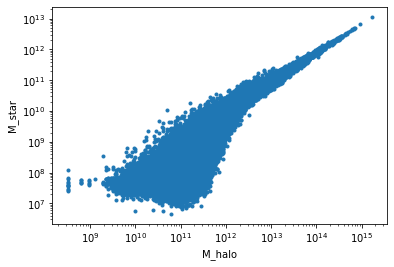

In [11]:
mm = np.load('../Illustris_halo_groupmass.npy').T

plt.plot(mm[1]*1e10, mm[2]*1e10, '.')
plt.loglog()
plt.xlabel('M_halo')
plt.ylabel('M_star')

[]

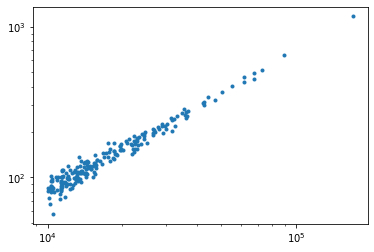

In [188]:
mask = mm[1]*1e10 > 1e14
plt.plot(mm[1][mask], mm[2][mask], '.')
plt.loglog()

In [57]:
print((mm[1] > 5e3).sum())

mm.size/(205)**3
num = int(205**3 * 1e-3)
mm[1][num]

560


429.2222900390625

In [159]:
# mbins = 10**np.arange(12, 14, 0.1)
# for i in range(mbins.size-1):
#     mask = (mm[1]*1e10 > mbins[i]) & (mm[1]*1e10<mbins[i+1])
#     print(mask.sum())
#     plt.hist(np.log10(mm[2][mask]*1e10), bins=50)
#     plt.show()
    

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in add
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarn

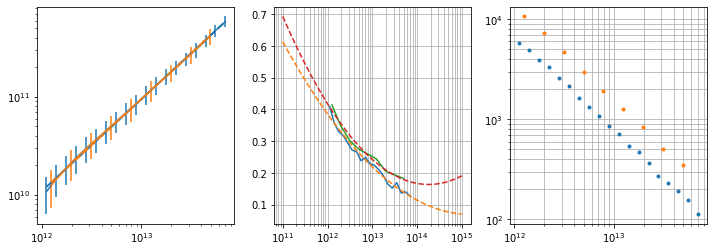

In [163]:
# mbins = np.logspace(11, 14)
def getstellar(mbins):
    scount, smass, sstd = np.zeros_like(mbins), np.zeros_like(mbins), np.zeros_like(mbins)
    hmass = np.zeros_like(mbins)

    for i in range(mbins.size-1):
        if i == mbins.size-1: mask = (mm[1]*1e10 > mbins[i])
        else: mask = (mm[1]*1e10 > mbins[i]) & (mm[1]*1e10<mbins[i+1])
        scount[i] = mask.sum() 
        smass[i] = mm[2][mask].mean()*1e10
        sstd[i] = mm[2][mask].std()*1e10
        hmass[i] = mm[1][mask].mean()*1e10
    
    return scount, smass, sstd, hmass

def fitstellar(p, smass, hmass):
    p0, p1 = p
    return sum((np.log(smass[:-1]) - p1*np.log(hmass[:-1])-p0)**2)

def fitscatter(p, hmass, rstd, rety=False):
    p0, p1, p2 = p
    xx = np.log(hmass)
    yy = p0 + p1*xx + p2*xx**2
    if rety: return yy
    return sum((yy[:-1] - rstd[:-1])**2)

mbins = 10**np.arange(12, 14, 0.1)
scount, smass, sstd, hmass = getstellar(mbins)
pp = minimize(lambda p: fitstellar(p, smass, hmass), [1, 1])
pps = minimize(lambda p: fitscatter(p, hmass, sstd/smass), [0.3, 0.0, .0])

mbins2 = 10**np.arange(12, 14, 0.2)
scount2, smass2, sstd2, hmass2 = getstellar(mbins2)
pp2 = minimize(lambda p: fitstellar(p, smass2, hmass2), [1, 1])
pps2 = minimize(lambda p: fitscatter(p, hmass2, sstd2/smass2), [1, 1, 1])


plt.figure(figsize = (12, 4))
plt.subplot(131)
plt.errorbar(hmass[:-1], smass[:-1], sstd[:-1], color='C0')
plt.errorbar(hmass2[:-1], smass2[:-1], sstd2[:-1], color='C1')
plt.plot(hmass[:-1], np.exp(pp.x[0] + pp.x[1]*np.log(hmass[:-1])), 'C0--', lw=2)
plt.plot(hmass2[:-1], np.exp(pp2.x[0] + pp2.x[1]*np.log(hmass2[:-1])), 'C1--', lw=2)
plt.loglog()

plt.subplot(132)
xx = hmass.copy()
plt.plot(hmass, sstd/smass)
plt.plot(np.logspace(11, 15), fitscatter(pps.x, np.logspace(11, 15), None, True), '--')
plt.plot(hmass2, sstd2/smass2)
plt.plot(np.logspace(11, 15), fitscatter(pps2.x, np.logspace(11, 15), None, True), '--')
plt.grid(which='both')
plt.semilogx()

plt.subplot(133)
plt.plot(hmass, scount, '.')
plt.plot(hmass2, scount2, '.')
plt.semilogx()
plt.loglog()
plt.grid(which='both')


In [2]:
# from scipy.optimize import minimize
# from scipy.integrate import quad
# from scipy.interpolate import InterpolatedUnivariateSpline as interpolate

# from pmesh.particlemesh import ParticleMesh
# from pmesh.pm import ParticleMesh as PMnew

# from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower
# from nbodykit.cosmology import Planck15, EHPower


In [4]:
# import sys
# sys.path.append("/global/homes/c/chmodi/Programs/cosmo4d/")
# sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/')
# sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets')
# import features as ft
# import datalib as lib
# import datatools as dtools
# import nettools as ntools
# import sigtools as stools
# import diagnostic as dg
# import mymass_function as mass_function
# %matplotlib inline

# pfile = "/global/homes/c/chmodi/Data/ics_matterpow_0.dat"
# klin, plin = np.loadtxt(pfile, unpack=True)
# mf = mass_function.Mass_Func(pfile, 0.3175)
# cosmo = Planck15.clone(Omega_cdm = 0.2685, h = 0.6711, Omega_b = 0.049)

# from cosmo4d import maplhd as mapp
# from cosmo4d import nbody
# from cosmo4d import report as dgrep
# from cosmo4d.iotools import load_map as loadmap

# # sys.path.append('/global/homes/c/chmodi/Programs/Py_codes/modules/')
# # import mytools as tools
# # import mycosmology

# #import mysigmoid as sigmoid



In [9]:
seed, nsteps = 100, 5
bs, nc = 400., 128
pm = PMnew(BoxSize=bs, Nmesh=[nc, nc, nc], dtype = "f8")
numd = 5e-4
numd1 = 1e-3
num = int(numd*pm.BoxSize.prod())
M0 = 1e11
Rsm = 3

In [11]:
proj = '/project/projectdirs/cosmosim/lbl/chmodi/cosmo4d/'
scratch = '/global/cscratch1/sd/chmodi/cosmo4d/'
train = scratch + 'train/'
dpath = proj + 'data/L%04d_N%04d_S%04d_%02dstep/lhd/n%02d/'
ppath = proj + 'train/L%04d_N%04d_%02dstep-n%02d/cfcl273noa/'%(bs, nc, nsteps, numd*1e4)
outpath = scratch + 'output/L%04d_N%04d_%02dstep-fof/lhd_S%04d/n%02d/'


outpath2 = proj + 'output/L%04d_N%04d_S%04d_%02dstep-fof/lhd/n%02d/'


In [12]:
# del fitp, bestp, datap, report, reportf
ftup, fitp, bestp, datap = {}, {}, {}, {}
report, reportf = {}, {}

In [15]:
numd = 5e-4
numd1 = 1e-3

ftup['400'] = (400, 128, nsteps, seed, numd*1e4)

def loadfile(key, folder, ipath, subf = 'best-fit', mesh=False, keycheck=True, keyskip = True, verbose=False):
    if key in report.keys() and keycheck:
        if verbose: print('Key clash for %s'%key)
        if keyskip: return None
    bestm = mapp.Observable.load(ipath + '%s/%s'%(folder, subf))
    datam = mapp.Observable.load(ipath + 'datap')
    fitm = mapp.Observable.load(ipath + 'fitp').mapp
    report[key] = dgrep.evaluate(bestm, datam)[:-2]
    reportf[key] = dgrep.evaluate1(fitm, datam.mapp)
    if mesh:
        bestp[key], datap[key], fitp[key] = bestm, datam, fitm

In [16]:
def skeys(pattern, dd=report):
    toret = []
    for key in dd.keys():
        if pattern in key: toret.append(key)
    return toret

def skeys2(pattern, dd=report):
    toret = []
    for key in dd.keys():
        if re.search(pattern , key) is not None: toret.append(key)
    return toret

def rd(rp, report=report):
    tr = {}
    tr['k'] = rp[0]['k']
    tr['modes'] = rp[0]['modes']
    keys = ['xm', 'xs', 'xd', 'pm1', 'pm2', 'ps1', 'ps2', 'pd1', 'pd2']
    for i, key in enumerate(keys):
        tr[key] = rp[i]['power']
    for key in tr.keys(): tr[key] = tr[key][1:]
    return tr

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [11]:
    
# # # # #200
# # loadfile('200m11', '64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_r3rf1b100eluMe11sm3/')
# # loadfile('200m11-5N', '64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_r3rf1b100eluMe11iMe12sm3/')
# # loadfile('200m11', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3/')
# # loadfile('200m10', 'M0_10/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3/', subf='0000/fit_p')
# # loadfile('200m11-4128', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1p-4128sm3/')

# # loadfile('200m11-3dnoff', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# # loadfile('200m10-3dnoff', 'M0_10/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# # loadfile('200m11-sg20', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3sg20/')
# # loadfile('200m11-offsg20', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1psm3offsg20/')

# # #na
# # loadfile('200m11-naoff', 'M0_11/64-03-0.00', ipath=outpath%ftup['200']+ 'opt_s999_MdowniM12-3N1pnasm3off/', keyskip=False)
# # loadfile('200m11-naoffsg20', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1pnasm3offsg20/', keyskip=False)       
# # loadfile('200m11-tf0p9naoff', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-3N1pna_tf0p90sm3off/', keyskip=False)                                           
# # loadfile('200m11-tf1p1naoff', 'M0_11/64-03-0.00', ipath=outpath%ftup['200']+ 'opt_s999_MdowniM12-3N1pna_tf1p10sm3off/', keyskip=False) 
# # loadfile('200m11-nacoffsg20', 'M0_11/64-03-0.00', ipath=outpath%ftup['200']+ 'opt_s999_MdowniM12-3N1pna_coffsm3offsg20/', keyskip=False)


# # #na-scatter
# # loadfile('200m11-nas12off', 'M0_11/64-03-0.00', ipath=outpath%ftup['200']+ 'opt_s999_MdowniM12-nas1020sm3off/')                                         
# # loadfile('200m11-nas12offsg15', 'M0_11/64-03-0.00', ipath = outpath%ftup['200'] + 'opt_s999_MdowniM12-nas1020sm3offsg15/')       

# # loadfile('200s9m11-nas12off', 'M0_11/64-03-0.00', ipath = outpath%ftup['2009'] + 'opt_s999_MdowniM12-nas1020sm3off/')       
# # # loadfile('4001m11-tf0p9naoff', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020tf0p9sm3off/')                                           
# # # loadfile('4001m11-tf1p1naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nas1020tf1p1sm3off/') 


# # # #300
# # # loadfile('300611', '64-03-0.00', ipath = outpath%ftup['300-64'] + prefixnoa%(11 , 'sm3/'))
# # # loadfile('300612', '64-03-0.00', ipath = outpath%ftup['300-64'] + prefixnoa%(12 , 'sm3/'))
# # # loadfile('300610', '64-03-0.00', ipath = outpath%ftup['300-64'] + prefixnoa%(10 , 'sm3/'))

# # #200-128
# # loadfile('200fm10s2', '128-03-0.00', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me10sm2/')
# # loadfile('200fm11', '128-03-0.00', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me11sm3/', subf='0000/fit_p')
# # loadfile('200fm11-noW', '128-03-0.50', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me11noWsm3/', subf='0000/fit_p')
# # loadfile('200fm12', '128-03-0.00', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me12sm3/')
# # loadfile('200fm10', '128-03-0.00', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me10sm3/')
# # loadfile('200fm510', '128-03-0.50', ipath = outpath%ftup['200-128'] + 'opt_s999_cfcl273Me96sm2/')

# # #300
# # loadfile('300m12', '128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_cfcl2732Me12sm3/')
# # loadfile('300m110', '128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_cfcl2732Me11sm3/')
# # loadfile('300m11-1N', 'M0_11/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_cfcl2732MdowniM12noNsm3/')
# # loadfile('300m11W-5N', 'M0_11/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_cfcl2732MdowniM12N1sm3/')
# # loadfile('300rpm12', 'M0_12/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_regp_Me12sm3/')
# # loadfile('300rpm11-5N', 'M0_11/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_regp_Me12sm3/')
# # loadfile('300m11-5Nsg10', 'M0_11/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_MdowniM12-5Nsm3sg10/')
# # loadfile('300m11-sg10', 'M0_11/128-03-0.00', ipath=outpath%ftup['300']+ 'opt_s999_MdowniM12-3N1psm3sg20/', subf='0020/fit_p')

# # loadfile('3001rpm12', 'M0_12/128-03-0.00', ipath=outpath%ftup['3001']+ 'opt_s999_regp_MdowniM12-3Nsm3/')
# # loadfile('3001rpm11', 'M0_11/128-03-0.00', ipath=outpath%ftup['3001']+ 'opt_s999_regp_MdowniM12-3Nsm3/')
# # loadfile('3001rprm12', 'M0_12/128-03-0.00', ipath=outpath%ftup['3001']+ 'opt_s999_regp_reg_Me12sm3/')
# # loadfile('3001rprm11', 'M0_11/128-03-0.00', ipath=outpath%ftup['3001']+ 'opt_s999_regp_reg_Me12sm3/')

# # # #400
# # loadfile('400m110-5p', '128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_cfcl273Me11sm3/')
# # loadfile('400m12-5p', '128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_cfcl273Me12sm3/')
# # loadfile('400m11-5N5p', '128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_cfcl273Me11iM12sm3/')
# # loadfile('400m11-5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_MdowniM12-3Nsm3/', subf='0040/fit_p/')
# # # loadfile('400m10i11', '128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_cfcl273Me10iM11M12sm3/')
# # loadfile('400m11-1N5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['400']+'opt_s999_cfcl273MdowniM12-1Nsm3/')
# # loadfile('400rm12-5p', 'M0_12/128-03-0.00', ipath=outpath%ftup['400']+ 'opt_s999_reg_Me12sm3/')
# # loadfile('400rm11-5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['400']+ 'opt_s999_reg_Me12sm3/')

# # loadfile('4001m12-5p', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3Nsm3/')
# # loadfile('4001m11-5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3Nsm3/')
# # loadfile('4001rm12-5p', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_reg_Me12sm3/')
# # loadfile('4001rm11-5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_reg_Me12sm3/')

# # loadfile('4001m12', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3/')
loadfile('4001m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3/')
# loadfile('4001m10', 'M0_10/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3/', subf='0040/fit_p')
# loadfile('4001m11-s2', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm2/')


# #Different noise
# loadfile('4001m11-10v', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1p10vsm3/')
# loadfile('4001m11-50v', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1p50vsm3/')
# loadfile('4001m11-3N-2', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+'opt_s999_MdowniM12-3N1p-2sm3/')

# #Diff seed
# # loadfile('40017m12', 'M0_12/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-3N1psm3/')
# loadfile('40017m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-3N1psm3/')
# loadfile('40017m11sg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-3N1psm3sg20/', subf='0020/fit_p')
# #Diff redshift
# loadfile('4001m11-z5', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'z05/opt_s999_MdowniM12-3N1psm3/')

# #Offset
loadfile('4001m11-off', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3off/')
# loadfile('4001m10-off', 'M0_10/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3off/')
# loadfile('4001m09-off', 'M0_09/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3off/')
loadfile('4001m11-3dnoff', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# loadfile('4001m10-3dnoff', 'M0_10/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# loadfile('4001m09-3dnoff', 'M0_09/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# # loadfile('4001m12-off', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3off/')
# # loadfile('4001m12-3dnoff', 'M0_12/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
    
# #Scatter
# loadfile('4001m11-sg10', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3sg10/')
# loadfile('4001m11-sg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3sg20/')
# loadfile('4001m11-sg30', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3sg30/', subf='0060/fit_p')
# # loadfile('4001m12-offsg20', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# loadfile('4001m11-offsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# loadfile('4001m10-offsg20', 'M0_10/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# loadfile('4001m09-offsg20', 'M0_09/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# loadfile('4001m11-3dnoffsg20', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voffsg20/')
# loadfile('4001m10-3dnoffsg20', 'M0_10/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voffsg20/')
# loadfile('4001m09-3dnoffsg20', 'M0_09/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1psm3n3d10voffsg20/')
# #diff off 
# loadfile('4001m11-doffsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1pdoffsm3offsg20/')
# # loadfile('4001m10-doffsg20', 'M0_10/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1pdoffsm3offsg20/')

# # ####Transfers                                                                                                                                                  
# # # loadfile('4001m12-tf1p1', 'M0_12/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1p_tf1p1sm3/')                                               
# # # loadfile('4001m12-tf0p9', 'M0_12/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1p_tf0p9sm3/')                                           
# # loadfile('4001m11-tf1p1', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1p_tf1p1sm3/')                                               
# # loadfile('4001m11-tf0p9', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1p_tf0p9sm3/')                                           
# # loadfile('4001m10-tf1p1', 'M0_10/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1p_tf1p1sm3/')                                               
# # loadfile('4001m10-tf0p9', 'M0_10/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-3N1p_tf0p9sm3/', subf='0040/fit_p')       

# # ####single
# # loadfile('4001m11-spl', 'M0_11/128-05-0.50', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-splsm3/')

# # ####4ft                                                                                                                                                        
# # loadfile('4001m11-4ft', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-4ftsm3/') 

# # #na
# # loadfile('4001m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nasm3off/')                                         
# # loadfile('4001m11-naoffsg20', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nasm3offsg20/')       
# # loadfile('4001m11-natf0p9off', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-natf0p9sm3off/')
# # loadfile('4001m11-natf1p1off', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-natf1p1sm3off/') 
# # loadfile('4001m11-nacoffsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nacoffsm3offsg20/')
# # loadfile('4001m11-natf0p9offsg20', 'M0_11/128-03-0.00', ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-natf0p9sm3offsg20/')                                           
# # loadfile('4001m11-natf1p1offsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-natf1p1sm3offsg20/') 

# # #na-scatter
# # loadfile('4001m11-nas12off', 'M0_11/128-03-0.00', 
# #          ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nas1020sm3off/', keyskip=True)
# # loadfile('4001m11-nas12offsg20', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3offsg20/', keyskip=True)       
# # loadfile('4001m11-nas12offsg10', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3offsg10/', keyskip=True) 
# # loadfile('4001m11-nas12offsg15', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3offsg15/', keyskip=True)  
# # loadfile('4001m11-nas12offsg13', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3offsg17/', keyskip=True)  
# # loadfile('4001m11-nas12offsg17', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3offsg17/', keyskip=True)  
# # loadfile('4001m11-nas12tf0p9off', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020tf0p9sm3off/', keyskip=True)
# # loadfile('4001m11-nas12tf1p1off', 'M0_11/128-03-0.00', 
# #              ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nas1020tf1p1sm3off/', keyskip=True) 
# # loadfile('4001m11-nas12tf0p9offsg15', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020tf0p9sm3offsg15/', keyskip=True)
# # loadfile('4001m11-nas12tf1p1offsg15', 'M0_11/128-03-0.00', 
# #          ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nas1020tf1p1sm3offsg15/', keyskip=True)

# # loadfile('4001m11-nas12off3d', 'M0_11/128-03-0.00', 
# #          ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nas1020sm3n3d25voff/', keyskip=False)
# # loadfile('4001m11-nas12off3dsg15', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nas1020sm3n3d25voffsg15/', keyskip=False)       

# # #corect scatter

# # loadfile('4001m11-nacfs12off', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nacfs1020sm3off/')       
# # loadfile('4001m11-nacfs12offsg15', 'M0_11/128-03-0.00', 
# #              ipath = outpath%ftup['4001'] + 'opt_s999_MdowniM12-nacfs1020sm3offsg15/')       



# # # #500
# # loadfile('500m110-5p', '128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_Me11sm3/')
# # loadfile('500m12-5p', '128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_Me12sm3/')
# # loadfile('500m110-5N5p', '128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_Me11iM12sm3/')
# # loadfile('500m11-1N', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-1Nsm3/')
# # loadfile('5001m12', 'M0_12/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3/')
loadfile('500m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3/')
# # loadfile('500rm11', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_reg_MdowniM12-3N1psm3/')
# # #Scatter
# # loadfile('500m11-sg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3sg20/', subf='0040/fit_p')
# # loadfile('500m11-sg10', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3sg10/')
# # loadfile('500m11-offsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# # loadfile('500m12-offsg20', 'M0_12/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# # #offset
# # loadfile('500m11-off', 'M0_11/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3off/')
# # loadfile('500m12-off', 'M0_12/128-03-0.00', ipath=outpath%ftup['500']+ 'opt_s999_MdowniM12-3N1psm3off/')

# # #5001
# # loadfile('5001m12-5p', 'M0_12/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3Nsm3/')
# # loadfile('5001m11-5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3Nsm3/')
# # loadfile('5001m11-5N5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-5Nsm3/')
# # loadfile('5001m11-1N5p', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-1Nsm3/')
loadfile('5001m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3/')
# # loadfile('5001m11-tol', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1ptolsm3/')
# # ##offset
# # loadfile('5001m11-off', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3off/')
# # loadfile('5001m12-off', 'M0_12/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3off/')
# # loadfile('5001m11-3dnoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# # loadfile('5001m12-3dnoff', 'M0_12/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3n3d10voff/')
# # #scatter
# # loadfile('5001m11-offsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')
# # loadfile('5001m12-offsg20', 'M0_12/128-03-0.00', ipath=outpath%ftup['5001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')



# white = 1+(pm.generate_whitenoise(100)*np.sqrt(1e3)).c2r()
# whitesm = ft.smooth(white, 3, 'fingauss')
# whiterp = dgrep.evaluate1(whitesm, white)


Error: b"Failed to open physical file `/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3n3d10voff/M0_11/128-03-0.00/best-fit/mapp/000000' with mode `r' (No such file or directory) @(src/bigfile.c:1737) @(src/bigfile.c:766)"

In [ ]:
loadfile('4001m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3/')
loadfile('4001m11-off', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3off/')
loadfile('4001m11-offsg20', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-3N1psm3offsg20/')

loadfile('4001m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('4001m11m10v3d', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_10vsm3n3d1000voff/')

loadfile('4001m11m02v', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_02vsm3off/')
loadfile('4001m11m02v3dbf', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM11bf12_02vsm3n3d200voff/',
         subf='0080/fit_p')
loadfile('4001m11m01v', 'M0_110/128-03-0.50', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_01vsm3off/', 
         subf='0080/fit_p')
loadfile('4001m11m01v3dbf', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM11bf12_01vsm3n3d100voff/', 
         keyskip=True)


loadfile('4001m11m01vsg20', 'M0_110/128-03-0.50', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_01vsm3offsg20/', 
         subf='0020/fit_p', keyskip=True)
loadfile('4001m11m01v3dsg20noW', 'M0_110/128-03-0.50', ipath=outpath%ftup['4001']+ 
         'nolog/opt_s999_iM11bf12_01vsm3n3d100voffsg20-noW/', subf='0020/fit_p', keyskip=True)
loadfile('4001m11m01v3dsg20', 'M0_110/128-01-0.00', ipath=outpath%ftup['4001']+ 
         'nolog/opt_s999_iM11bf12_01vsm3n3d100voffsg20/', subf='0000/fit_p', keyskip=True)


loadfile('4001m12m01v', 'M0_120/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_01vsm3off/', 
         keyskip=True)
loadfile('40017m12m01v', 'M0_120/128-03-0.00', ipath=outpath%ftup['40017']+ 'nolog/opt_s999_iM12_01vsm3off/', 
         keyskip=True)

loadfile('4001m11-off2x', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_iM12-nam2xsm3off/')
loadfile('4001m11-off5xt', 'M0_115/128-03-0.50', ipath=outpath%ftup['4001']+ 'opt_s999_iM125-nam5xsm3off/', 
        subf = '0020/fit_p')

###################


# loadfile('4001m11mt', 'M0_110/128-01-0.50', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM12_01vsmoff/')
loadfile('4001m11m01vbf3dt', 'M0_110/128-01-0.50', ipath=outpath%ftup['4001']+ 
         'nolog/opt_s999_iM11bf12_01vsm3n3d100voff/', subf='0000/fit_p', keyskip=True)
loadfile('4001m11m01vbft', 'M0_110/128-01-0.50', ipath=outpath%ftup['4001']+ 'nolog/opt_s999_iM11bf12_01vsm3off/', 
         subf='0000/fit_p')
loadfile('40017m11m01vbf3dt', 'M0_110/128-01-0.50', ipath=outpath%ftup['40017']+ 
         'nolog/opt_s999_iM11bf12_01vsm3n3d100voff/', subf='0000/fit_p')

loadfile('4001m12m01vsg20nft', 'M0_120/128-03-0.00', ipath=outpath%ftup['4001']+ 
             'nolog/opt_s999_iM12_01v-nfnosc-sm3offsg20/', keyskip=True)
loadfile('4001m12m01vt', 'M0_120/128-03-0.00', ipath=outpath%ftup['4001']+ 
             'nolog/opt_s999_iM12_01vsm3off/', keyskip=True)
loadfile('4001m12m01vsg20t', 'M0_120/128-03-0.00', ipath=outpath%ftup['4001']+ 
             'nolog/opt_s999_iM12_01vsm3offsg20/', keyskip=True)
loadfile('40017m12m01vsg20t', 'M0_120/128-03-0.00', ipath=outpath%ftup['40017']+ 
             'nolog/opt_s999_iM12_01vsm3offsg20/', keyskip=True)

###################

# loadfile('4001s98m25vt', 'M0_98/128-01-1.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_25vsm3off/', 
#          subf='0040/fit_p')
# loadfile('4001s98m50vt', 'M0_98/128-01-1.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_50vsm3off/',
#          subf='0040/fit_p')
# loadfile('4001s98m100vt', 'M0_98/128-01-1.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/', 
#          keyskip=True)
# loadfile('4001s98m200vt', 'M0_98/128-01-1.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_200vsm3off/', 
#          keyskip=True)
# loadfile('4001s92m100vt', 'M0_92/128-03-2.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/', 
#          subf='0040/fit_p', keyskip=True)
# loadfile('4001s92m200vt', 'M0_92/128-03-0.50', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_200vsm3off/',
#         subf='0040/fit_p')
# loadfile('4001s90m100v3dbft', 'M0_90/128-03-2.00', ipath=outpath%ftup['4001']+ 
#              'nolog/Mexp50/opt_s999_iM90bf98_100vsm3n3d100voff/')
# loadfile('4001s90m50v3dbft', 'M0_90/128-03-2.00', ipath=outpath%ftup['4001']+ 
#              'nolog/Mexp50/opt_s999_iM90bf98_50vf100vsm3n3d50voff/')
# loadfile('4001s90m200v3dbft', 'M0_90/128-03-2.00', ipath=outpath%ftup['4001']+ 
#              'nolog/Mexp50/opt_s999_iM90bf98_200vf100vsm3n3d200voff/')
# loadfile('4001s92m100v3dbft', 'M0_92/128-03-2.00', ipath=outpath%ftup['4001']+ 
#          'nolog/Mexp50/opt_s999_iM92bf98_100vsm3n3d100voff/')

###################

loadfile('4001s92100vt', 'M0_92/128-03-1.00', ipath=outpath%ftup['4001']+ '/Mexp50/opt_s999_iM98_10vsm3/')

loadfile('4001s98m100v', 'M0_98/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/')
loadfile('4001s98m200v', 'M0_98/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_200vsm3off/')
loadfile('4001s92m100v', 'M0_92/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/')
loadfile('4001s92m100v3dbf', 'M0_92/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM92bf98_100vsm3n3d100voff/')
loadfile('4001s90m100v', 'M0_90/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/')
loadfile('4001s85m100v', 'M0_90/128-03-1.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3off/', 
        subf='0040/fit_p/')

loadfile('4001s92m100vsg20', 'M0_92/128-03-0.00', ipath=outpath%ftup['4001']+ 'nolog/Mexp50/opt_s999_iM98_100vsm3offsg20/',
        subf='0100/fit_p/')

loadfile('4001m11Ms', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_iM12-Msmsm3/', subf='0020/fit_p')

#seeds
# loadfile('40017m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-3N1psm3/')
loadfile('4001m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40017m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40019m11-naoff', 'M0_110/128-03-0.00', ipath=outpath%ftup['40019']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40018m11-naoff', 'M0_110/128-03-0.00', ipath=outpath%ftup['40018']+ 'opt_s999_MdowniM12-nasm3off/')                                         


# loadfile('4001m11-2x', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_iM12-nam2xsm3off/')                                         

loadfile('4001s11-hssg10', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'Mexp50/opt_s999_iM12-hssm3offsg10/')                                         
loadfile('4001s11-hssg20', 'M0_110/128-03-0.00', ipath=outpath%ftup['4001']+ 'Mexp50/opt_s999_iM12-hssm3offsg20/')                                         


In [ ]:
skeys('4001s92')

In [ ]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12
i=0

# for i, key in enumerate(skeys('4001s98')[:-2]):
#     dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '--', label=key)

dgrep.summary(report['4001m11-off'], fig, ax, c='k', lw=2, ls=":", label='Halos')


labels = [key for key in skeys('4001s92')[1:]]
labels = ['L2 loss, M0= 9.2, $\sigma=0$', 'L2 loss, M0= 9.2, $\sigma=0$ \n3d-Noise', 'L2 loss, M0= 9.2, $\sigma=0.2$']
for i, key in enumerate(skeys('4001s92')[1:]):
    dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '--', label=labels[i])

labels = [key for key in skeys('4001s11')]
labels = ['LogLoss, M0= 11, $\sigma=0.1$', 'LogLoss, M0= 11, $\sigma=0.2$']
for i, key in enumerate(skeys('4001s11')):
    dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '-', label=labels[i])

for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.3)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Inverse transform of Stellar Mass', fontsize =14)

# fig.savefig('./figs/invstellar.pdf')

In [ ]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12
i=0

# for i, key in enumerate(skeys('4001s98')[:-2]):
#     dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '--', label=key)

dgrep.summary(report['4001m11-off'], fig, ax, c='k', lw=2, ls="-", label='Halos')
dgrep.summary(report['4001m11-off2x'], fig, ax, c='r', lw=2, ls="-", label='2x')
dgrep.summary(report['4001m11-off5xt'], fig, ax, c='b', lw=2, ls="-", label='5x, R=0.5')


# labels = [key for key in skeys('4001s92')[1:]]
# labels = ['L2 loss, M0= 9.2, $\sigma=0$', 'L2 loss, M0= 9.2, $\sigma=0$ \n3d-Noise', 'L2 loss, M0= 9.2, $\sigma=0.2$']
# for i, key in enumerate(skeys('4001s92')[1:]):
#     dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '--', label=labels[i])

# labels = [key for key in skeys('4001s11')]
# labels = ['LogLoss, M0= 11, $\sigma=0.1$', 'LogLoss, M0= 11, $\sigma=0.2$']
# for i, key in enumerate(skeys('4001s11')):
#     dgrep.summary(report[key], fig, ax, c=colors[i], lw=2, ls = '-', label=labels[i])

for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.7)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Scale Mass', fontsize =14)

# fig.savefig('./figs/scalemass.pdf')

In [ ]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12
i=0

# dgrep.summary(report['4001m11'], fig, ax, c='k', lw=2, ls = ':', label='$L=%d, N=5*10^{-4}$'%300)

# dgrep.summary(report['4001m11m01v'], fig, ax, c='r', lw=2, ls = '-', label='L2, sameN')
dgrep.summary(report['4001m11m01vbf3dt'], fig, ax, c='b', lw=2, ls = '-', label='L2, 3dN')
dgrep.summary(report['40017m11m01vbf3dt'], fig, ax, c='g', lw=2, ls = '-', label='L2, 3dN')
# dgrep.summary(report['4001m11m01v3dbf'], fig, ax, c='b', lw=2, ls = '--', label='L2, 3dN')
# dgrep.summary(report['4001m11m01vbft'], fig, ax, c='g', lw=2, ls = '-', label='L2, sameN, 4W')
# dgrep.summary(report['4001m11m01vbft'], fig, ax, c='g', lw=2, ls = '-', label='L2, sameN, 4W')

dgrep.summary(report['4001m12m01v'], fig, ax, c='b', lw=2, ls = '--', label='L2, 100')
dgrep.summary(report['40017m12m01v'], fig, ax, c='g', lw=2, ls = '--', label='L2, 700')


for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.5)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3)

# fig.suptitle(r'For scattered catalog, effect of noise', fontsize =14)

# fig.savefig('./figs/bfit_resolution.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

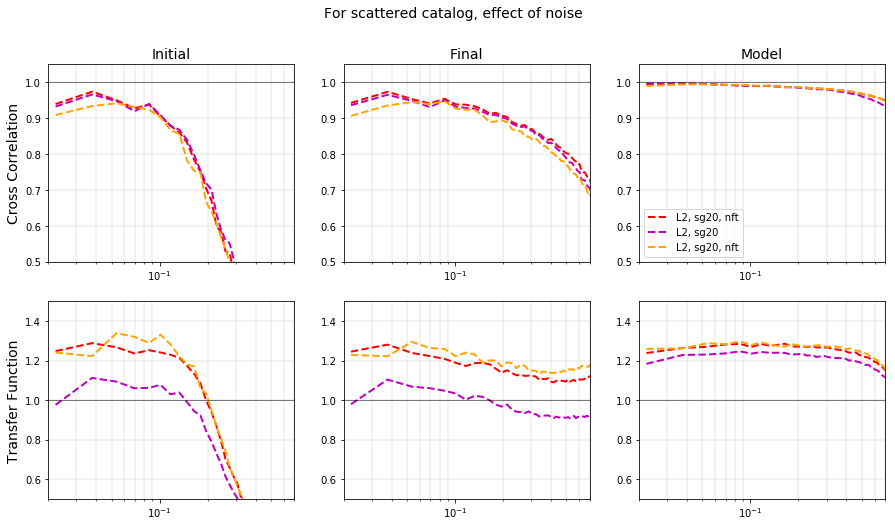

In [14]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12
i=0

# dgrep.summary(report['4001m11'], fig, ax, c='k', lw=2, ls = ':', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m01v3dbf'], fig, ax, c='k', lw=2, ls = ':', label='L2, 3dN')

# dgrep.summary(report['4001m11m01vsg20'], fig, ax, c='g', lw=2, ls = '--', label='L2,sg20')
# dgrep.summary(report['4001m11m01v3dsg20'], fig, ax, c='c', lw=2, ls = '--', label='L2, 3dN,sg20')
# dgrep.summary(report['4001m11m01v3dsg20noW'], fig, ax, c='b', lw=2, ls = '--', label='L2, 3dN, sg20now')
dgrep.summary(report['4001m12m01vsg20nft'], fig, ax, c='r', lw=2, ls = '--', label='L2, sg20, nft')
dgrep.summary(report['4001m12m01vsg20t'], fig, ax, c='m', lw=2, ls = '--', label='L2, sg20')
# dgrep.summary(report['4001m12m01vt'], fig, ax, c='orange', lw=2, ls = '--', label='L2')
dgrep.summary(report['40017m12m01vsg20t'], fig, ax, c='orange', lw=2, ls = '--', label='L2, sg20, nft')


for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.5)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3)

fig.suptitle(r'For scattered catalog, effect of noise', fontsize =14)

# fig.savefig('./figs/bfit_resolution.pdf')

In [15]:
tpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/'
tmpd = BigFileMesh(tpath + 'opt_s999_iM12_01v-nfnosc-sm3offsg20/datap', 'mapp').paint()
tmp = BigFileMesh(tpath + 'opt_s999_iM12_01v-nfnosc-sm3offsg20/noise_M120', 'offset').paint()
tmp2 = BigFileMesh(tpath + 'opt_s999_iM12_01vsm3off/noise_M120', 'offset').paint()
tmp3 = BigFileMesh(tpath + 'opt_s999_iM12_01vsm3offsg20/noise_M120', 'offset').paint()


tmpn = BigFileMesh(tpath + 'opt_s999_iM12_01v-nfnosc-sm3offsg20/noise_M120', 'ivar3d').paint()
tmp2n = BigFileMesh(tpath + 'opt_s999_iM12_01vsm3off/noise_M120', 'ivar3d').paint()

Error: b"Failed to open physical file `/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/opt_s999_iM12_01v-nfnosc-sm3offsg20/datap/mapp/000000' with mode `r' (No such file or directory) @(src/bigfile.c:1737) @(src/bigfile.c:766)"

In [14]:
np.unique(tmp3) , np.unique(tmp2), np.unique(tmp)

NameError: name 'tmp3' is not defined

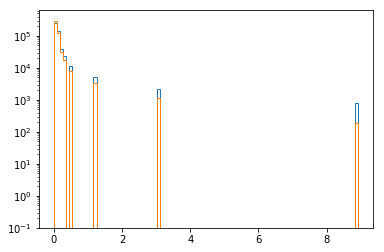

In [1159]:
plt.hist(tmp[(tmp - tmp2)[...]!=0], log=True, histtype='step', bins=100)
plt.hist(tmp2[(tmp - tmp2)[...]!=0], alpha=1, log=True, histtype='step', bins=100)
plt.show()

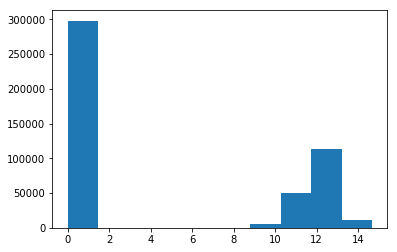

In [1136]:
dummy = plt.hist(np.log10(1+tmpd[((tmp - tmp2)[...]!=0).astype(bool)]))

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:167: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

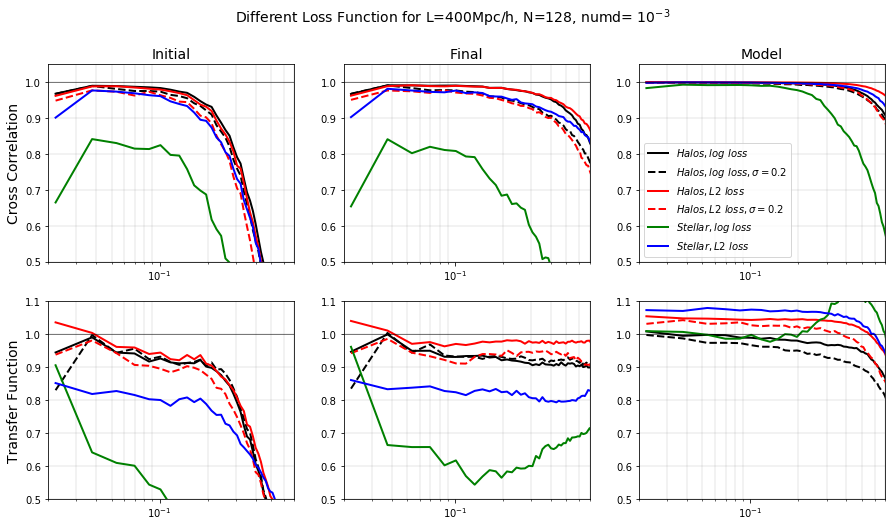

In [957]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12
i=0

dgrep.summary(report['4001m11-off'], fig, ax, c='k', lw=2, ls = '-', label='$Halos, log\ loss$')
dgrep.summary(report['4001m11-offsg20'], fig, ax, c='k', lw=2, ls = '--', label='$Halos, log\ loss, \sigma=0.2$')

dgrep.summary(report['4001m11m01v3dbf'], fig, ax, c='r', lw=2, ls = '-', label='$Halos, L2\ loss$')
dgrep.summary(report['4001m11m01v3dsg20'], fig, ax, c='r', lw=2, ls = '--', label='$Halos, L2\ loss, \sigma=0.2$')

dgrep.summary(report['4001s92100vt'], fig, ax, c='g', lw=2, ls = '-', label='$Stellar, log\ loss$')
dgrep.summary(report['4001s92m100v'], fig, ax, c='b', lw=2, ls = '-', label='$Stellar, L2\ loss$')


for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.1)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3)

fig.suptitle(r'Different Loss Function for L=400Mpc/h, N=128, numd= $10^{-3}$', fontsize =14)

fig.savefig('./figs/bfit_resolution.pdf')

In [688]:
tmp1 = mapp.Observable.load('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/opt_s999_iM12_01vsm3offsg20/datap/')
tmp2 = mapp.Observable.load('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1pdoffsm3offsg20/datap/')

In [695]:
abs(tmp1.mapp - tmp2.mapp).csum()


11594.8523997546

In [ ]:
# dgrep.summary(report['4001m11'], fig, ax, c='r', lw=1, ls = '-', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m'], fig, ax, c='b', lw=1, ls = '--', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m2'], fig, ax, c='b', lw=1, ls = '-', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m1'], fig, ax, c='b', lw=1, ls = ':', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m23d'], fig, ax, c='orange', lw=2, ls = '-.', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11m23d2'], fig, ax, c='orange', lw=2, ls = ':', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001m11Ms'], fig, ax, c='orange', lw=1, ls = '--', label='$L=%d, N=5*10^{-4}$'%300)

# dgrep.summary(report['4001s92'], fig, ax, c='m', lw=2, ls = '-', label='$L=%d, N=5*10^{-4}$'%300)
# dgrep.summary(report['4001s92bf'], fig, ax, c='m', lw=2, ls = '--', label='$L=%d, N=5*10^{-4}$'%300)

# dgrep.summary(report['4001m11-naoff'], fig, ax, c='r', lw=1, ls = '-', label='100')
# dgrep.summary(report['40017m11-naoff'], fig, ax, c='b', lw=1, ls = '-', label='700')
# dgrep.summary(report['40018m11-naoff'], fig, ax, c='m', lw=1, ls = '-', label='800')
# dgrep.summary(report['40019m11-naoff'], fig, ax, c='g', lw=1, ls = '-', label='900')


In [452]:
# %matplotlib inline
# colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

# fig, ax = plt.subplots(2, 3, figsize = (15, 8))

# ###down from M12
# i=0
# dgrep.summary(report['300m11i12W'], fig, ax, c=colors[i], lw=1, ls = '-', label='$L=%d, N=5*10^{-4}$'%300)
# for i, l in enumerate([400, 500]):    
# #     dgrep.summary(report['%dm11i12-1N'%l], fig, ax, c=colors[i], lw=2, ls = '-', label='$%d, M=1e11(12)$'%l)
#     dgrep.summary(report['%dm11i12-1N'%l], fig, ax, c=colors[i+1], lw=1, ls = '-', label='$L=%d, N=5*10^{-4}$'%l)

# # ##regression
# # for i, l in enumerate([300, 400]):    
# #     dgrep.summary(report['%drm11i12'%l], fig, ax, c=colors[i], lw=2, ls = ':', label='$%d, M=1e11(12)(reg)$'%l)

# ###Direct m11
# # for i, l in enumerate([300, 400, 500]):    
# #     dgrep.summary(report['%dm11'%l], fig, ax, c=colors[i], lw=2, ls = ':', label='$%d, M=1e11$'%l)

# # ##Direct m12
# # for i, l in enumerate([ 300, 400, 500]):    
# #     dgrep.summary(report['%dm12'%l], fig, ax, c=colors[i], lw=2, ls = '-', label='$%d, M=1e12$'%l)

# # ###N10, Direct m12
# # for i, l in enumerate([ 300, 400, 500]):    
# #     dgrep.summary(report['%dm12'%(l*10+1)], fig, ax, c=colors[i], lw=2, ls = '--', label='$%d, M=1e12$'%l)

# ###N11, down from 12
# for i, l in enumerate([300, 400, 500]):    
#     dgrep.summary(report['%dm11i12-3N'%(l*10+1)], fig, ax, c=colors[i], lw=1.5, ls = '--', label='$L=%d, N=1*10^{-3}$'%l)

# ###N11, down from 12
# for i, l in enumerate([400, 500]):    
#     dgrep.summary(report['%dm11i12-3N1p'%(l*10+1)], fig, ax, c=colors[i+1], lw=1.5, ls = ':', label='$L=%d, 1p, N=1*10^{-3}$'%l)
    
# # dgrep.summary(report['%dm11i12-3N1ps2'%(400*10+1)], fig, ax, c='r', lw=1.5, ls = ':', label='$L=%d, 1ps2, N=1*10^{-3}$'%l)
# # dgrep.summary(report['%dm11i12-3N'%(400*10+1)], fig, ax, c='b', lw=1.5, ls = ':', label='$L=%d, 5p, N=1*10^{-3}$'%l)
# # dgrep.summary(report['%dm11i12-3N1p'%(400*10+1)], fig, ax, c='g', lw=1.5, ls = ':', label='$L=%d, 1p, N=1*10^{-3}$'%l)
# # ###N11, down from 12
# # for i, l in enumerate([400, 500]):    
# #     dgrep.summary(report['%dm11i12-3N1p'%(l*10+1)], fig, ax, c=colors[i], lw=2, ls = ':', label='$%d, 1p, N=1*10^{-3}$'%l)

# # dgrep.summary(report['500m11i12-5N'], fig, ax, c='c', lw=2, ls = '--', label='$%d, N=1*10^{-3}$'%l)
# # dgrep.summary(report['500m11i12-3N1p'], fig, ax, c='y', lw=2, ls = '--', label='$%d, 1p, N=1*10^{-3}$'%l)

# dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

# for axis in ax[0]:
#     axis.set_ylim(0.5, 1.1)
#     axis.set_xlim(2e-2, 0.7)
#     axis.axhline(1, lw=0.5, color ='k')
# for axis in ax[1]:
#     axis.set_ylim(0.5, 1.1)
#     axis.set_xlim(2e-2, 0.7)
#     axis.axhline(1, lw=0.5, color ='k')

# ax[0, 2].legend(loc=3)

# fig.suptitle(r'Best fits for different resolution and number densities', fontsize =14)

# # fig.savefig('./figs/bfit_resolution.pdf')

# Offset

In [ ]:
skeys('doff')


m11-nas12offsg10 not found and hence skipped

m11-doffsg20 not found and hence skipped

m11-off not found and hence skipped


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

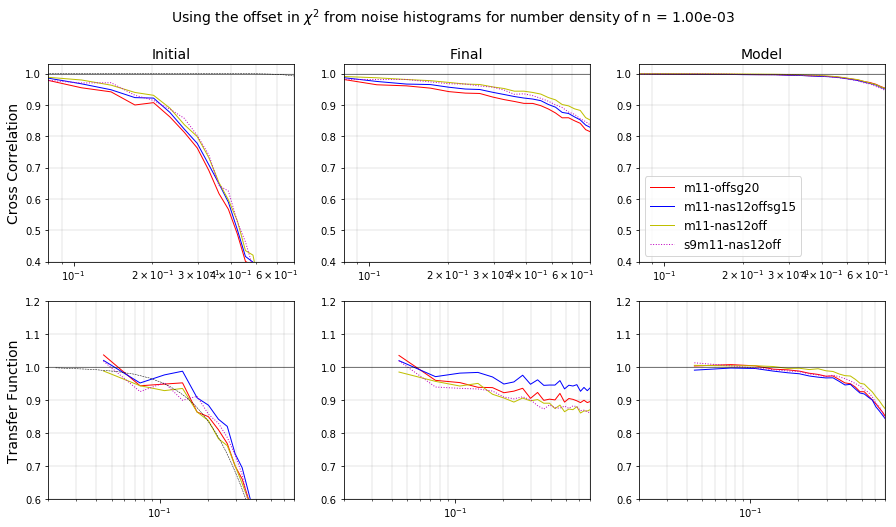

In [425]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'orange', 'k', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

l = 200
keys = ['m%02d-offsg20'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls='-', alpha=1)

keys = ['m%02d-nas12offsg15'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls='-', alpha=1, colors=colors[1:])
keys = ['m%02d-nas12offsg10'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls='--', alpha=1, colors=colors[1:])

keys = ['m%02d-doffsg20'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls='-', alpha=1, colors=colors[2:])

keys = ['m%02d-nas12off'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls='-', alpha=1, colors=colors[3:])

keys = ['m%02d-off'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls=':', alpha=1, colors=colors[4:])

keys = ['s9m%02d-nas12off'%i for i in [11]]
plotsum(keys, l = l, lw=1, ls=':', alpha=1, colors=colors[4:])

# keys = ['m%02d-3dnoff'%i for i in [11, 10,]]
# plotsum(keys, l = 4001, lw=1, ls='-.', alpha=1)

# key = 'm11-sg20'
# l = 4001
# dgrep.summary(report['%d%s'%(l, key)], fig, ax, c='k', lw=1, ls = '--', alpha = 1, label='%s'%key)

#For 200 Mpc box
# keys = ['m%02d'%i for i in [11,10]]
# plotsum(keys, l = 200, lw=1, ls='-', alpha=1, colors=colors[4:])

# keys = ['m%02d-3dnoff'%i for i in [11,10]]
# plotsum(keys, l = 200, lw=1, ls='--', alpha=1, colors=colors[4:])

# for 500Mpc box
# keys = ['5001m11i12-3N1p', '5001m11i12-3Noff']#, '5001m11i12-3N1p3dnoff']:]
# keys = ['5001m12-3N1p', '5001m12-3Noff']


dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(8e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Using the offset in $\chi^2$ from noise histograms for number density of n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_off_full.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

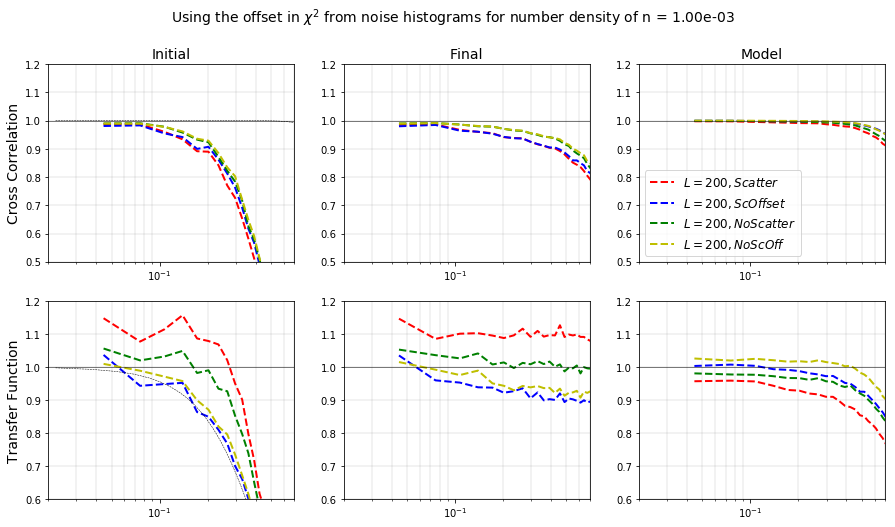

In [364]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
labels = ['Scatter', 'ScOffset', 'NoScatter', 'NoScOff']

# i = 0 
# for key in ['4001m11i12-3Nsg20', '4001m11i12-3Noffsg20', '4001m11i12-3N1p', '4001m11i12-3N1p3dnoff']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-',  label=r'$L = %s, %s$'%(key[:3], labels[i]))
#     i+=1

i = 0 
for key in ['200m11-sg20', '200m11-offsg20', '200m11','200m11-3dnoff']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--',  label=r'$L = %s, %s$'%(key[:3], labels[i]))
    i+=1

# i = 0 
# for key in ['500m11-sg20', '500m11-offsg20', '500m11','500m11off']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--',  label=r'$L = %s, %s$'%(key[:3], labels[i]))
#     i+=1



dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Using the offset in $\chi^2$ from noise histograms for number density of n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_offsg.pdf')

# Misc

In [238]:
skeys('spl')

['4001m11-spl']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

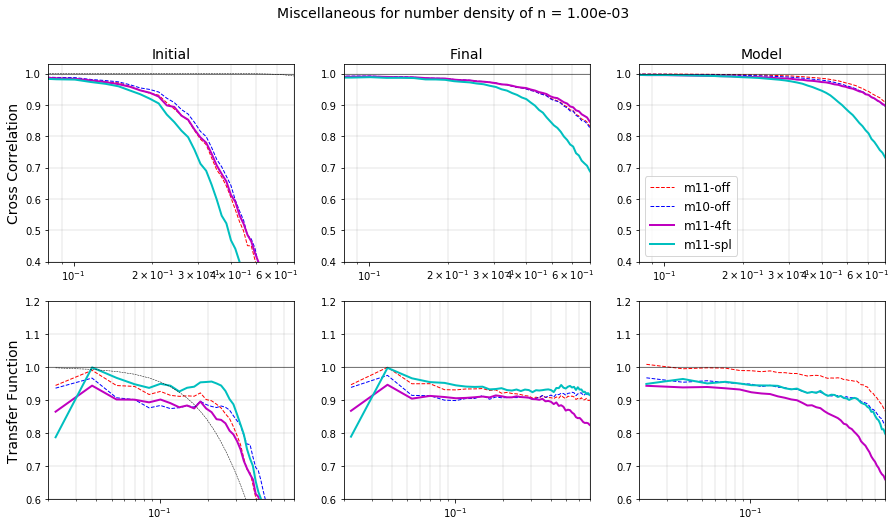

In [240]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'orange', 'k', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

keys = ['m%02d-off'%i for i in [11, 10]]
plotsum(keys, l = 4001, lw=1, ls='--', alpha=1)

keys = ['m%02d-4ft'%i for i in [11]]
plotsum(keys, l = 4001, lw=2, ls='-', alpha=1, colors=colors[4:])
keys = ['m%02d-spl'%i for i in [11]]
plotsum(keys, l = 4001, lw=2, ls='-', alpha=1, colors=colors[5:])


dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(8e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Miscellaneous for number density of n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_off_full.pdf')

## Information content

In [ ]:
d0 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3/datap/', 'd').paint()
mapp0 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3/datap/', 'mapp').paint()

In [ ]:
tmp = dgrep.evaluate1(mapp0, d0)
rtmp = tmp[0]['power']/np.sqrt(tmp[1]['power']*tmp[2]['power'])

In [ ]:
%matplotlib inline
key = '4001m10-off'
rp = objectview(rd(report[key]))
r = rp.xs/np.sqrt(rp.ps1*rp.ps2)
key2 = '4001m10-offsg20'
rp2 = objectview(rd(report[key2]))
r2 = rp2.xs/np.sqrt(rp2.ps1*rp2.ps2)

fig, ax= plt.subplots(1, 4, figsize = (20, 5))
ax[0].plot(rp.k, r, label='No scatter')
ax[0].plot(rp2.k, r2, label=r'$\sigma=0.2$')
ax[0].axhline(1, lw=0.5, c='k')
ax[0].set_title(r'$r = P_x/\sqrt{P_1 P_2}$')

ax[1].plot(rp.k, (1-r**2))
ax[1].plot(rp2.k, (1-r2**2))
ax[1].set_yscale('log')
ax[1].set_title(r'$1-r^2$')

ax[2].plot(rp.k, np.cumsum(rp.modes*r**2), label=r'$N \times r^2$')
ax[2].plot(rp.k, np.cumsum(rp.modes*r), ls='--', label=r'$N \times r$')
ax[2].plot(rp.k, np.cumsum(rp2.modes*r2**2), label=r'$N \times r^2$')
ax[2].plot(rp.k, np.cumsum(rp2.modes*r2), ls='--', label=r'$N \times r$')
ax[2].plot(rp.k, np.cumsum(rp.modes), 'k:', label=r'$N$')
ax[2].set_title('Information Content')
ax[2].set_yscale('log')

l = ax[3].plot(rp.k, rp.pm2*(1/r**2 -1), label=r'$N \times r^2$')
ax[3].plot(rp.k, rp.pd2*(1/r**2 -1),  color=l[0].get_color(), ls="--")
l = ax[3].plot(rp2.k, rp2.pm2*(1/r2**2 -1), ls='-', label=r'$N \times r$')
ax[3].plot(rp.k, rp2.pd2*(1/r**2 -1),  color=l[0].get_color(), ls="--", lw=0.5)
l = ax[3].plot(tmp[0]['k'], tmp[0]['power']*(1/rtmp**2 -1), label=r'$N \times r^2$')
ax[3].plot(tmp[0]['k'], tmp[1]['power']*(1/rtmp**2 -1),  color=l[0].get_color(), ls="--", lw=2)
ax[3].set_title(r'Effective Noise = $P_{hh}(1/r^2 -1)$')
ax[3].set_yscale('log')
ax[3].axhline(1e3, ls="--", color='k')

for axis in ax:
    axis.grid(which='both', lw=0.3, color='gray')
    axis.set_xscale('log')
    axis.legend()


# Transfer

In [331]:
skeys('na')

['4001m11-naoff',
 '4001m10-naoffsg20',
 '4001m11-tf0p9naoff',
 '4001m10-tf1p1naoff']


m10-sg20 not found and hence skipped


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:167: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

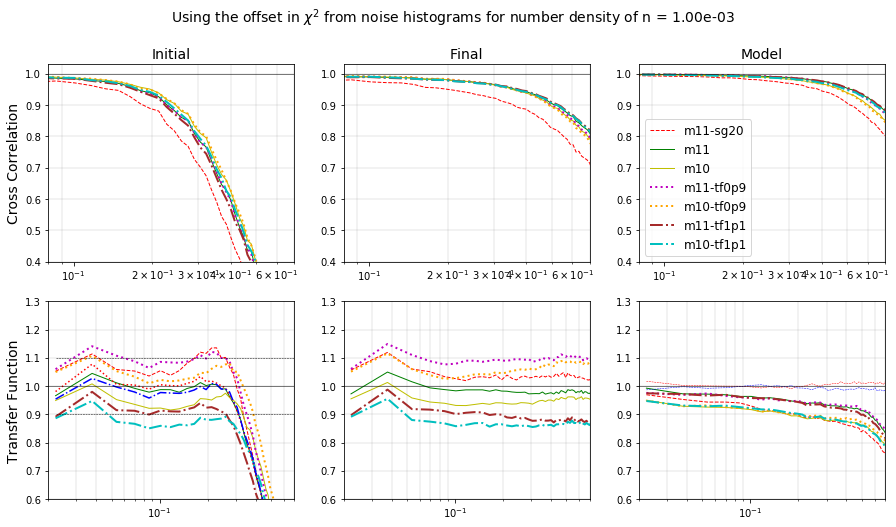

In [57]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'c', 'k', 'r']

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

# keys = ['m%02d-offsg20'%i for i in [11, 10]]
keys = ['m%02d-sg20'%i for i in [11, 10]]
plotsum(keys, l = 4001, lw=1, ls='--', alpha=1, colors=colors)


# keys = ['m%02d-off'%i for i in [11, 10]]
keys = ['m%02d'%i for i in [11, 10]]
plotsum(keys, l = 4001, lw=1, ls='-', alpha=1, colors=colors[2:])

keys = ['m%02d-tf0p9'%i for i in [11, 10,]]
plotsum(keys, l = 4001, lw=2, ls=':', alpha=1, colors=colors[4:])

keys = ['m%02d-tf1p1'%i for i in [11, 10,]]
plotsum(keys, l = 4001, lw=2, ls='-.', alpha=1, colors=colors[6:])

rp0 = objectview(rd(report['4001m11-off']))
rp0 = objectview(rd(report['4001m11-off']))
rp1p1 = objectview(rd(report['4001m11-tf1p1']))
rp0p9 = objectview(rd(report['4001m11-tf0p9']))
ax[1, 0].plot(rp1p1.k, (rp1p1.ps2/rp0.ps2)**0.5, 'k--', lw=0.5)
ax[1, 0].plot(rp1p1.k, (rp0p9.ps2/rp0.ps2)**0.5, 'k--', lw=0.5)
ax[1, 0].plot(rp1p1.k, (rp1p1.ps1/rp0.ps2)**0.5, 'r:')
ax[1, 0].plot(rp1p1.k, (rp0p9.ps1/rp0.ps2)**0.5, 'b-.')

ax[1, 2].plot(rp1p1.k, (rp1p1.pm2/rp0.pm2)**0.5, 'r--', lw=0.5)
ax[1, 2].plot(rp1p1.k, (rp0p9.pm2/rp0.pm2)**0.5, 'b--', lw=0.5)

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(8e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.3)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Using the offset in $\chi^2$ from noise histograms for number density of n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_off_full.pdf')

In [985]:
skeys('coff')

['200m11-nacoffsg20', '4001m11-nacoffsg20']

In [865]:
importlib.reload(dgrep)

<module 'cosmo4d.report' from '/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py'>

In [56]:
skeys('cf')

['4001m11-nacfs12off', '4001m11-nacfs12offsg15']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:219: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:220: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:221: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:223: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:224: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:225: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

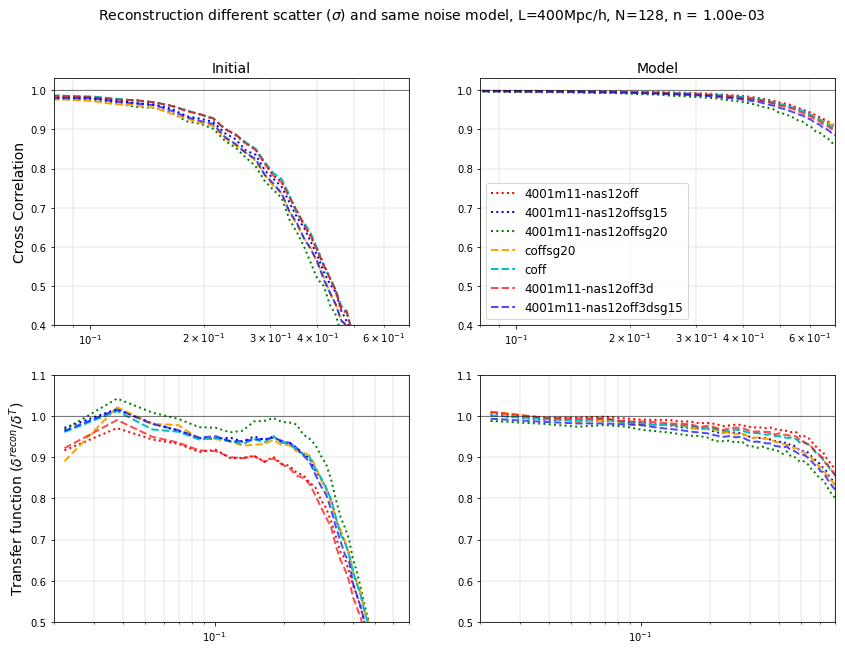

In [55]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'c', 'k', 'r']

fig, ax = plt.subplots(2, 2, figsize = (14, 10))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

i=0
    
# keys = ['4001m11-nas12off',  '4001m11-nas12offsg10', '4001m11-nas12offsg15', '4001m11-nas12offsg17', '4001m11-nas12offsg20']
keys = ['4001m11-nas12off',  '4001m11-nas12offsg15', '4001m11-nas12offsg20']
labels = ['$\sigma_8 = \sigma_{80}$', '$\sigma_8 = 1.1\sigma_{80}$', '$\sigma_8 = 0.9\sigma_{80}$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=2, ls =':', alpha=1, label=keys[i])

dgrep.summary4(report['4001m11-nacoffsg20'], fig, ax, c='orange', lw=2, ls ='--', alpha=1, label='coffsg20')
dgrep.summary4(report['4001m11-naoff'], fig, ax, c='c', lw=2, ls ='--', alpha=1, label='coff')

# keys = ['4001m11-nacfs12off', '4001m11-nacfs12offsg15']
# for i, key in enumerate(keys):
#     dgrep.summary4(report[key], fig, ax, c=colors[i], lw=2, ls ='-', alpha=0.7, label=keys[i])

keys = ['4001m11-nas12off3d', '4001m11-nas12off3dsg15']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=2, ls ='--', alpha=0.7, label=keys[i])

# keys = ['4001m11-nas12offsg15', '4001m11-nas12tf1p1offsg15', '4001m11-nas12tf0p9offsg15']
# labels = ['$\sigma_8 = \sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 1.1\sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 0.9\sigma_{80},\ \sigma=0.15$']
# for i, key in enumerate(keys):
#     dgrep.summary4(report[key], fig, ax, c=colors[i], lw=1, ls ='--', alpha=1, label=labels[i])

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(8e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.1)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[1, 0].set_ylabel('Transfer function ($\delta^{recon}/\delta^T$)')
ax[0, 1].legend(loc=3, fontsize=12)

fig.suptitle(r'Reconstruction different scatter ($\sigma$) and same noise model, L=400Mpc/h, N=128, n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/sigma8scatter.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:219: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:220: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:221: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:223: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:224: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:225: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

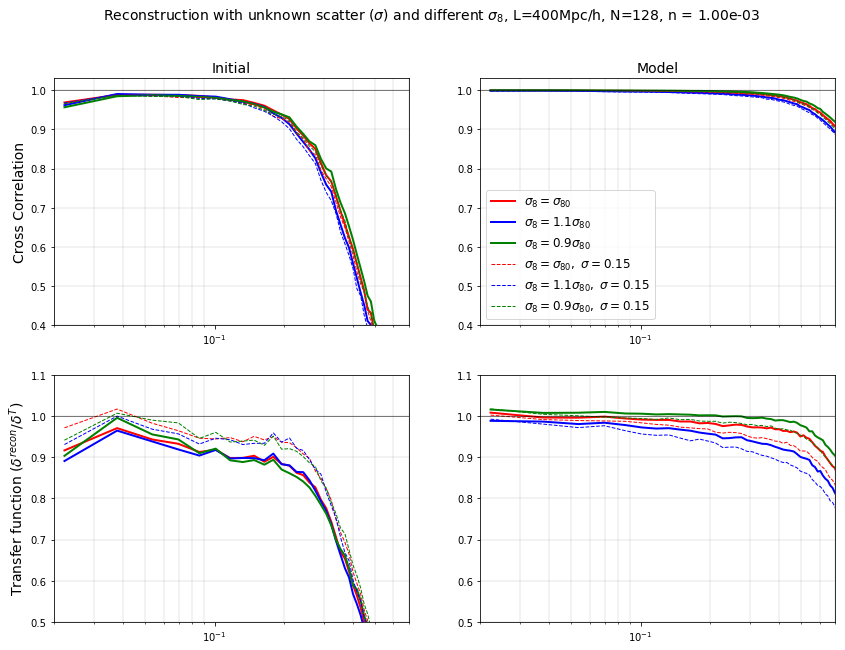

In [914]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'c', 'k', 'r']

fig, ax = plt.subplots(2, 2, figsize = (14, 10))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

i=0
    
keys = ['4001m11-nas12off',  '4001m11-nas12tf1p1off', '4001m11-nas12tf0p9off']
labels = ['$\sigma_8 = \sigma_{80}$', '$\sigma_8 = 1.1\sigma_{80}$', '$\sigma_8 = 0.9\sigma_{80}$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=2, ls ='-', alpha=1, label=labels[i])

keys = ['4001m11-nas12offsg15', '4001m11-nas12tf1p1offsg15', '4001m11-nas12tf0p9offsg15']
labels = ['$\sigma_8 = \sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 1.1\sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 0.9\sigma_{80},\ \sigma=0.15$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=1, ls ='--', alpha=1, label=labels[i])

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.1)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[1, 0].set_ylabel('Transfer function ($\delta^{recon}/\delta^T$)')
ax[0, 1].legend(loc=3, fontsize=12)

fig.suptitle(r'Reconstruction with unknown scatter ($\sigma$) and different $\sigma_8$, L=400Mpc/h, N=128, n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/sigma8scatter.pdf')

In [58]:
skeys('4001m11-na')

['4001m11-naoff',
 '4001m11-naoffsg20',
 '4001m11-natf0p9off',
 '4001m11-natf1p1off',
 '4001m11-nacoffsg20',
 '4001m11-natf0p9offsg20',
 '4001m11-natf1p1offsg20',
 '4001m11-nas12off',
 '4001m11-nas12offsg20',
 '4001m11-nas12offsg10',
 '4001m11-nas12offsg15',
 '4001m11-nas12offsg13',
 '4001m11-nas12offsg17',
 '4001m11-nas12tf0p9off',
 '4001m11-nas12tf1p1off',
 '4001m11-nas12tf0p9offsg15',
 '4001m11-nas12tf1p1offsg15',
 '4001m11-nacfs12off',
 '4001m11-nacfs12offsg15',
 '4001m11-nas12off3d',
 '4001m11-nas12off3dsg15']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:219: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:220: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:221: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:223: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:224: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:225: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

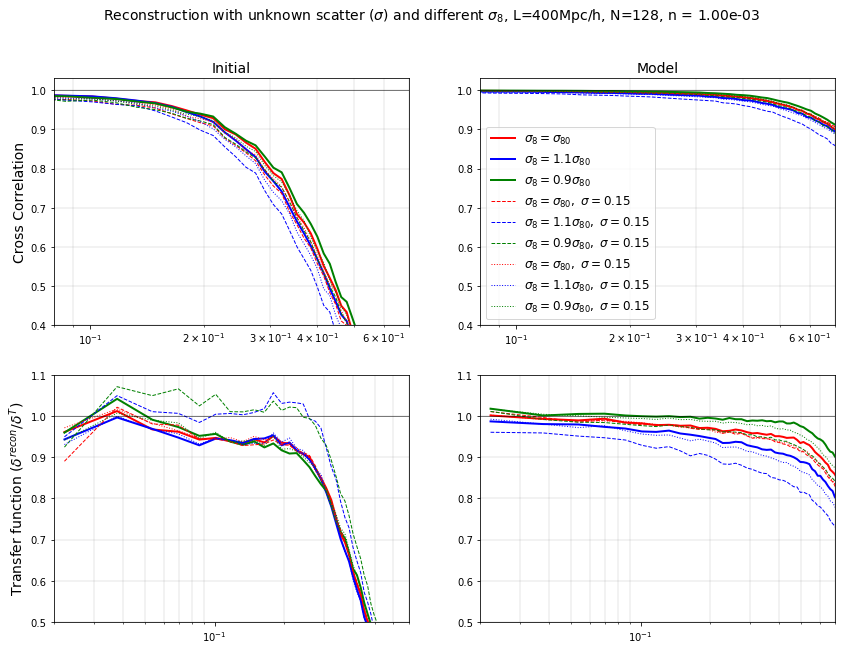

In [929]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', 'c', 'k', 'r']

fig, ax = plt.subplots(2, 2, figsize = (14, 10))


def plotsum(keys, l, ls='-', lw=1, alpha=1, labels=None, colors=colors):

    if labels is None: labels = keys
    for i, key in enumerate(keys):
        try:
            dgrep.summary(report['%d%s'%(l, key)], fig, ax, c=colors[i], lw=lw, ls =ls, alpha=alpha, label=labels[i])
        except:
            print ('\n%s not found and hence skipped'%key)

i=0
    
keys = ['4001m11-naoff',  '4001m11-natf1p1off', '4001m11-natf0p9off']
labels = ['$\sigma_8 = \sigma_{80}$', '$\sigma_8 = 1.1\sigma_{80}$', '$\sigma_8 = 0.9\sigma_{80}$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=2, ls ='-', alpha=1, label=labels[i])

keys = ['4001m11-naoffsg20', '4001m11-natf1p1offsg20', '4001m11-natf0p9offsg20']
labels = ['$\sigma_8 = \sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 1.1\sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 0.9\sigma_{80},\ \sigma=0.15$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=1, ls ='--', alpha=1, label=labels[i])

keys = ['4001m11-nas12offsg15', '4001m11-nas12tf1p1offsg15', '4001m11-nas12tf0p9offsg15']
labels = ['$\sigma_8 = \sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 1.1\sigma_{80},\ \sigma=0.15$', '$\sigma_8 = 0.9\sigma_{80},\ \sigma=0.15$']
for i, key in enumerate(keys):
    dgrep.summary4(report[key], fig, ax, c=colors[i], lw=1, ls =':', alpha=1, label=labels[i])

for axis in ax[0]:
    axis.set_ylim(0.4, 1.03)
    axis.set_xlim(8e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.1)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[1, 0].set_ylabel('Transfer function ($\delta^{recon}/\delta^T$)')
ax[0, 1].legend(loc=3, fontsize=12)

fig.suptitle(r'Reconstruction with unknown scatter ($\sigma$) and different $\sigma_8$, L=400Mpc/h, N=128, n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/sigma8scatter.pdf')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


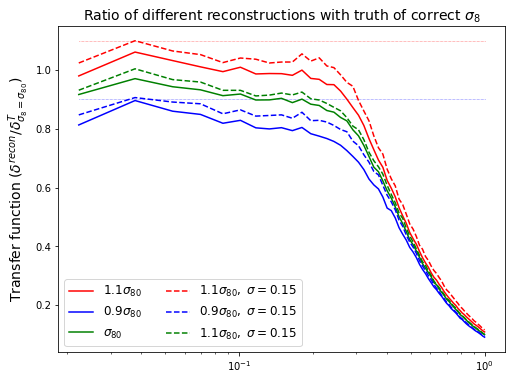

In [904]:
fig, ax = plt.subplots(figsize=(8, 6))
ll = '4001m11-nas12'
rp0 = objectview(rd(report['%soff'%ll]))
rp0sg = objectview(rd(report['%soffsg10'%ll]))
rp1 = objectview(rd(report['%stf1p1off'%ll]))
rp1sg = objectview(rd(report['%stf1p1offsg15'%ll]))
rp9 = objectview(rd(report['%stf0p9off'%ll]))
rp9sg = objectview(rd(report['%stf0p9offsg15'%ll]))

kk = rp0.k

ax.plot(kk, (rp1.ps2/rp0.ps2)**0.5, 'r:', lw=0.5)
ax.plot(kk, (rp9.ps2/rp0.ps2)**0.5, 'b:', lw=0.5)
ax.plot(kk, (rp1.ps1/rp0.ps2)**0.5, 'r', label='$1.1\sigma_{80}$')
ax.plot(kk, (rp9.ps1/rp0.ps2)**0.5, 'b', label='$0.9\sigma_{80}$')
ax.plot(kk, (rp0.ps1/rp0.ps2)**0.5, 'g', label='$\sigma_{80}$')
ax.plot(kk, (rp1sg.ps1/rp0.ps2)**0.5, 'r--', label='$1.1\sigma_{80},\ \sigma=0.15$')
ax.plot(kk, (rp9sg.ps1/rp0.ps2)**0.5, 'b--', label='$0.9\sigma_{80},\ \sigma=0.15$')
ax.plot(kk, (rp0sg.ps1/rp0.ps2)**0.5, 'g--', label='$1.1\sigma_{80},\ \sigma=0.15$')
# ax.plot(kk, (rp0sg.ps1/rp0.ps2)**0.5, 'k-.', label='TF1sg')

ax.set_ylabel(r'Transfer function ($\delta^{recon}/\delta^T_{\sigma_8=\sigma_{80}}$)', fontsize=14)

ax.set_xscale('log')
ax.legend(ncol=2, fontsize=12)
ax.set_title('Ratio of different reconstructions with truth of correct $\sigma_8$', fontsize=14)

# fig.savefig('./figs/tf_init.pdf')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


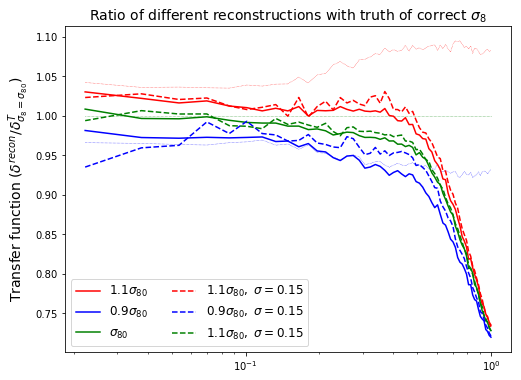

In [917]:
fig, ax = plt.subplots(figsize=(8, 6))
ll = '4001m11-nas12'
rp0 = objectview(rd(report['%soff'%ll]))
rp0sg = objectview(rd(report['%soffsg10'%ll]))
rp1 = objectview(rd(report['%stf1p1off'%ll]))
rp1sg = objectview(rd(report['%stf1p1offsg15'%ll]))
rp9 = objectview(rd(report['%stf0p9off'%ll]))
rp9sg = objectview(rd(report['%stf0p9offsg15'%ll]))

kk = rp0.k

ax.plot(kk, (rp0.pm2/rp0.pm2)**0.5, 'g:', lw=0.5)
ax.plot(kk, (rp1.pm2/rp0.pm2)**0.5, 'r:', lw=0.5)
ax.plot(kk, (rp9.pm2/rp0.pm2)**0.5, 'b:', lw=0.5)
ax.plot(kk, (rp1.pm1/rp0.pm2)**0.5, 'r', label='$1.1\sigma_{80}$')
ax.plot(kk, (rp9.pm1/rp0.pm2)**0.5, 'b', label='$0.9\sigma_{80}$')
ax.plot(kk, (rp0.pm1/rp0.pm2)**0.5, 'g', label='$\sigma_{80}$')
ax.plot(kk, (rp1sg.pm1/rp0.pm2)**0.5, 'r--', label='$1.1\sigma_{80},\ \sigma=0.15$')
ax.plot(kk, (rp9sg.pm1/rp0.pm2)**0.5, 'b--', label='$0.9\sigma_{80},\ \sigma=0.15$')
ax.plot(kk, (rp0sg.pm1/rp0.pm2)**0.5, 'g--', label='$1.1\sigma_{80},\ \sigma=0.15$')
# ax.plot(kk, (rp0sg.ps1/rp0.ps2)**0.5, 'k-.', label='TF1sg')

ax.set_ylabel(r'Transfer function ($\delta^{recon}/\delta^T_{\sigma_8=\sigma_{80}}$)', fontsize=14)

ax.set_xscale('log')
ax.legend(ncol=2, fontsize=12)
ax.set_title('Ratio of different reconstructions with truth of correct $\sigma_8$', fontsize=14)

# fig.savefig('./figs/tf_init.pdf')

In [404]:
tmp = BigFileCatalog('/global/cscratch1/sd/chmodi/cosmo4d/data/L0300_N0256_S0100_40step/FOF', header='Header')
tmp.size/300**3, 8*(5e-3*400**3)/256**3

(0.0021776666666666667, 0.152587890625)

In [569]:
bpath  = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
fof1p1 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-nas1020tf1p1sm3offsg15/FOFd', header='Header')
fof0p9 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-nas1020tf0p9sm3offsg15/FOFd', header='Header')
fof = BigFileCatalog(bpath + 'opt_s999_MdowniM12-nas1020sm3offsg15/FOFd', header='Header')
# map0 =BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1p_nasm3off/datap', 'mapp').paint()
# map1p1 =BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-nas1020tf1p1sm3offsg15/datap', 'mapp').paint()
# map0p9 =BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-nas1020tf0p9sm3offsg15/datap', 'mapp').paint()

In [310]:
hmass1 = fof1p1['Mass'].compute()[1:]*1e10
hmass1c = mf.icdf_sampling(bs, hmass = hmass1)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_ne

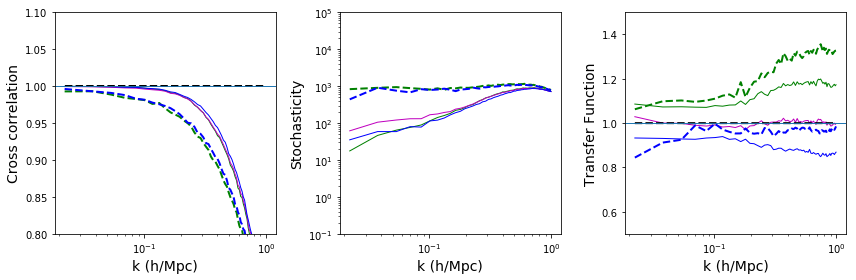

In [566]:

f1p1 = pm.paint(fof1p1['PeakPosition'], fof1p1['Mass']*1e10)
f1p12 = pm.paint(fof1p1['PeakPosition'][1:], hmass1c)
f0p9 = pm.paint(fof0p9['PeakPosition'], fof0p9['Mass']*1e10)
f = pm.paint(fof['PeakPosition'], fof['Mass']*1e10)

f1p1p = pm.paint(fof1p1['PeakPosition'])
f0p9p = pm.paint(fof0p9['PeakPosition'])
fp = pm.paint(fof['PeakPosition'])

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
dg.plot_2pt(f, f1p1, color='g', axin=ax)
dg.plot_2pt(f, f1p12, color='m', axin=ax)
dg.plot_2pt(f, f0p9, color='b', axin=ax)

dg.plot_2pt(f, map0, color='k', axin=ax, lw=2, ls="--")
dg.plot_2pt(map0, map1p1, color='g', axin=ax, lw=2, ls="--")
dg.plot_2pt(map0, map0p9, color='b', axin=ax, lw=2, ls="--")



## Redshift 

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

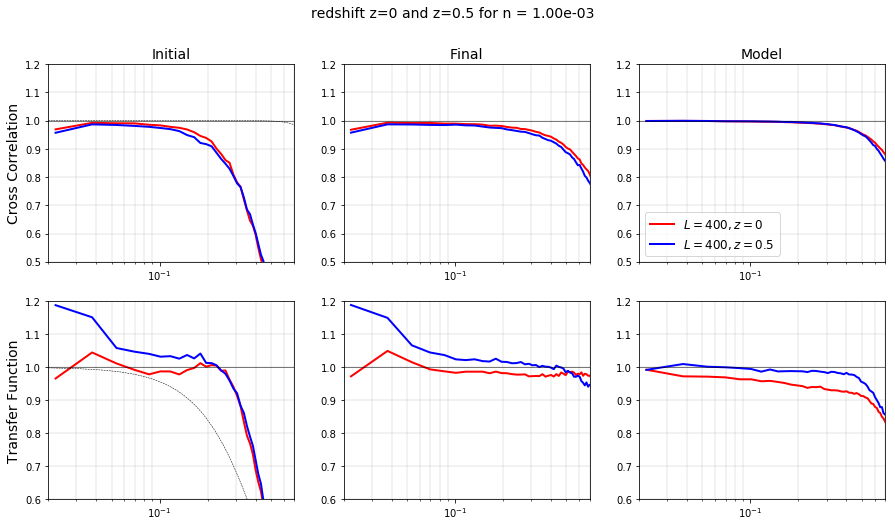

In [522]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
labels = ['z=0', 'z=0.5']
for key in ['4001m11i12-3N1p', '4001m11i12-3Nz5']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='$L = %s, %s$'%(key[:3], labels[i]))
    i+=1
# i = 0 
# for key in ['4001m11i12-3Nsg20', '40017m11i12-3N1psg20']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--',  label=r'$L = %s, \sigma=0.2$'%(key[:3]))
#     i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'redshift z=0 and z=0.5 for n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/diff_z.pdf')

## Change seed

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

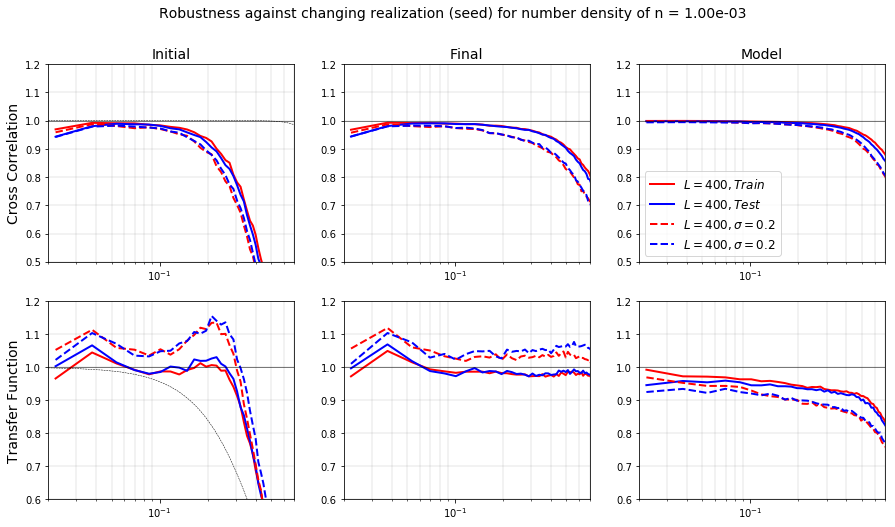

In [27]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
labels = ['Train', 'Test']
for key in ['4001m11i12-3N1p', '40017m11i12-3N1p']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='$L = %s, %s$'%(key[:3], labels[i]))
    i+=1
i = 0 
for key in ['4001m11i12-3Nsg20', '40017m11i12-3N1psg20']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--',  label=r'$L = %s, \sigma=0.2$'%(key[:3]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Robustness against changing realization (seed) for number density of n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_seed.pdf')

In [75]:
# dgrep.evaluate();

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


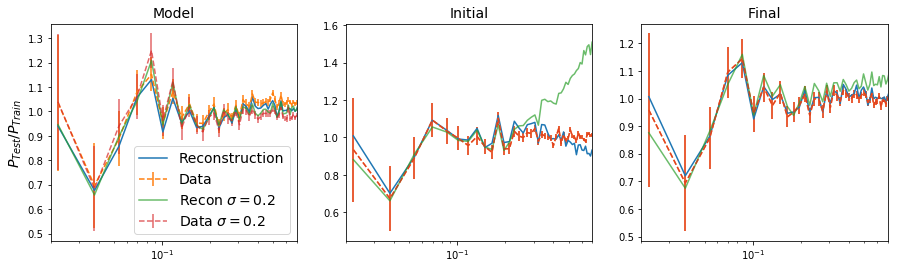

In [82]:

fig, ax = plt.subplots(1, 3, figsize = (15, 4))
titles = ['Model', 'Initial', 'Final']

key = '4001m11i12-3N1p'
key2 = '40017m11i12-3N1p'
for j in range(3):
    i = 2*j + 3
    ax[j].errorbar(report[key][i]['k'], report[key2][i]['power']/report[key][i]['power'], 
                   label='Reconstruction')
    ax[j].errorbar(report[key][i+1]['k'], report[key2][i+1]['power']/report[key][i+1]['power'], 
                   (2/report[key][3]['modes'])**0.5, ls="--", label='Data')
    ax[j].set_xscale('log')
    ax[j].set_title(titles[j], fontsize=14)
    if not j: ax[j].legend(fontsize=14)
    ax[j].set_xlim(0.02, 0.7)
ax[0].set_ylabel(r'$P_{Test}/P_{Train}$', fontsize=14)


key = '4001m11i12-3Nsg20'
key2 = '40017m11i12-3N1psg20'
for j in range(3):
    i = 2*j + 3
    ax[j].errorbar(report[key][i]['k'], report[key2][i]['power']/report[key][i]['power'], 
                   label='Recon $\sigma=0.2$', alpha=0.7)
    ax[j].errorbar(report[key][i+1]['k'], report[key2][i+1]['power']/report[key][i+1]['power'], 
                   (2/report[key][3]['modes'])**0.5, ls="--", label='Data $\sigma=0.2$', alpha=0.7)
    ax[j].set_xscale('log')
    ax[j].set_title(titles[j], fontsize=14)
    if not j: ax[j].legend(fontsize=14)
    ax[j].set_xlim(0.02, 0.7)
ax[0].set_ylabel(r'$P_{Test}/P_{Train}$', fontsize=14)


# fig.savefig('figs/change_seed_var.pdf')

## Sensitivity to the network

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

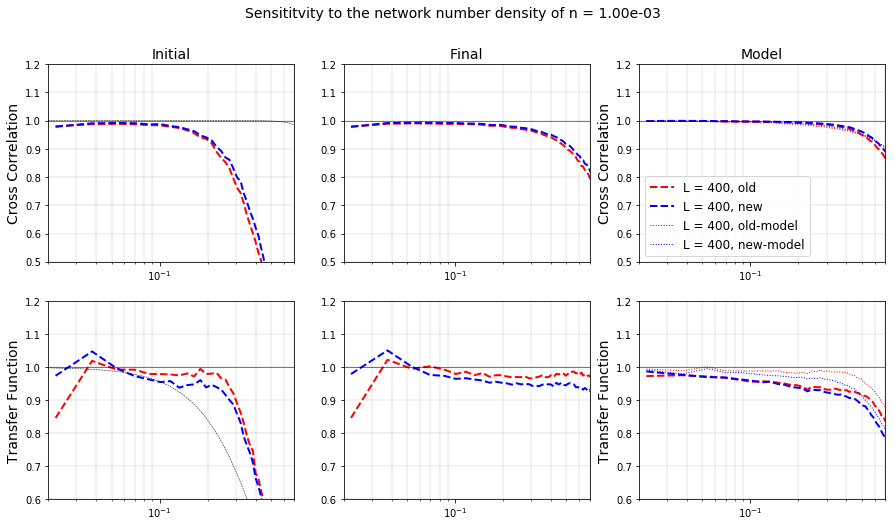

In [44]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
labels = ['old', 'new']
for key in ['4001m11i12-3N', '4001m11i12-3N-2']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--', label='L = %s, %s'%(key[:3], labels[i]))
    i+=1

i = 0
labels = ['old-model', 'new-model']
for key in ['4001m11i12-3N', '4001m11i12-3N-2']:
    dgrep.summary1(reportf[key], fig, ax[:, -1], c=colors[i%7], lw=1, ls = ':', label='L = %s, %s'%(key[:3], labels[i]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Sensititvity to the network number density of n = %0.2e'%(1e-3), fontsize =14)
# fig.savefig('./figs/change_net.pdf')


## Tolerance

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

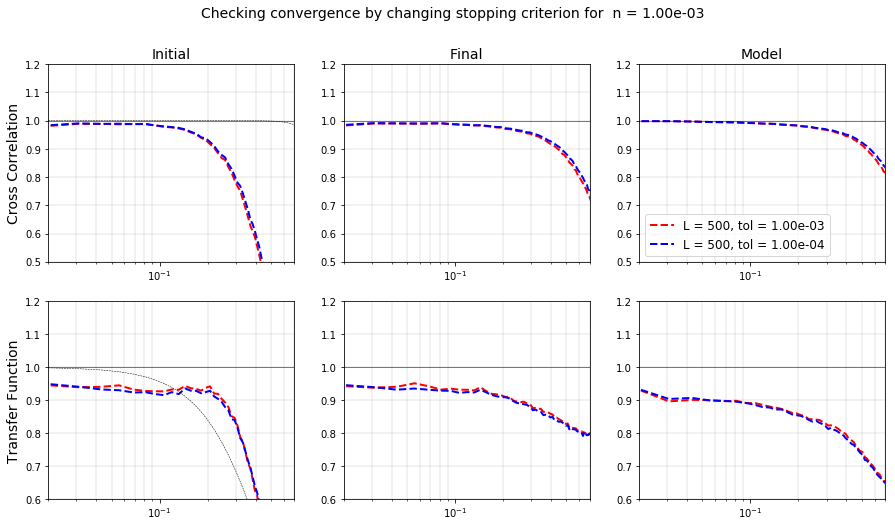

In [43]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
labels = [1e-3, 1e-4]
for key in ['5001m11i12-3N1p', '5001m11i12-3N1ptol']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--', label='L = %s, tol = %0.2e'%(key[:3], labels[i]))
    i+=1

# i = 0
# labels = ['old-model', 'new-model']
# for key in ['4001m11i12-3N', '4001m11i12-3N-2']:
#     dgrep.summary1(reportf[key], fig, ax[:, -1], c=colors[i%7], lw=1, ls = ':', label='L = %s, %s'%(key[:3], labels[i]))
#     i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Checking convergence by changing stopping criterion for  n = %0.2e'%(1e-3), fontsize =14)
# fig.savefig('./figs/change_tol.pdf')


## Replacing second network with regression

In [190]:
skeys('r')

['300rpm12',
 '300rpm11i12',
 '3001rpm12',
 '3001rpm11i12-3N',
 '3001rprm12',
 '3001rprm11i12',
 '400rm12',
 '400rm11i12',
 '4001rm12',
 '4001rm11i12',
 '400rm11i12-3N',
 '4001rm11i12-3N',
 '500rm11i12-3N',
 '500rm11i12-3N1p']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

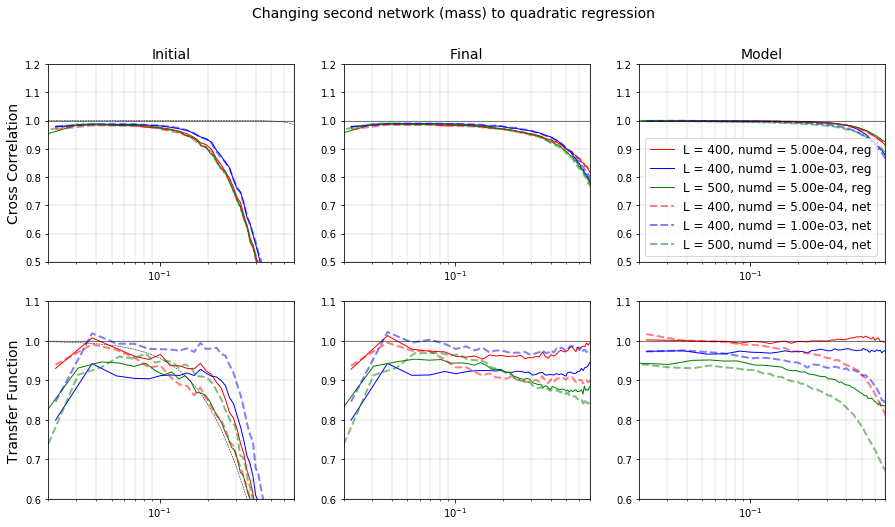

In [389]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


# i = 0 
# for key in ['300m11', '400m11', '500m11']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--', label='L = %s, M0 = 1e%s'%(key[:3], key[-2:]))
#     i+=1
i = 0 
labels = [5e-4, 1e-3, 5e-4]
for key in ['400rm11i12-3N', '4001rm11i12-3N', '500rm11i12-3N1p']:
# for key in ['500rm11i12-3N1p']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=1, ls = '-',  label='L = %s, numd = %0.2e, reg'%(key[:3], labels[i]))
    i+=1

i = 0 
for key in ['400m11i12-3N', '4001m11i12-3N', '500m11i12-3N1p']:
# for key in ['500m11i12-3N1p']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, alpha = 0.5, ls = '--',  label='L = %s, numd = %0.2e, net'%(key[:3], labels[i]))
    i+=1


dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.1)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Changing second network (mass) to quadratic regression', fontsize =14)
# fig.savefig('./figs/change_regression.pdf')

## Change M0


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

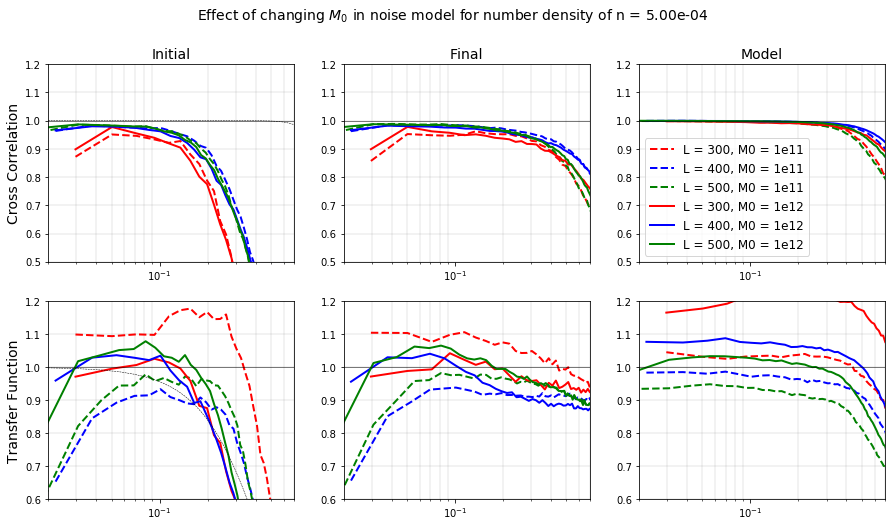

In [64]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
for key in ['300m11', '400m11', '500m11']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--', label='L = %s, M0 = 1e%s'%(key[:3], key[-2:]))
    i+=1
i = 0 
for key in ['300m12', '400m12', '500m12']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-',  label='L = %s, M0 = 1e%s'%(key[:3], key[-2:]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Effect of changing $M_0$ in noise model for number density of n = %0.2e'%0.0005, fontsize =14)
# fig.savefig('./figs/change_M0.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

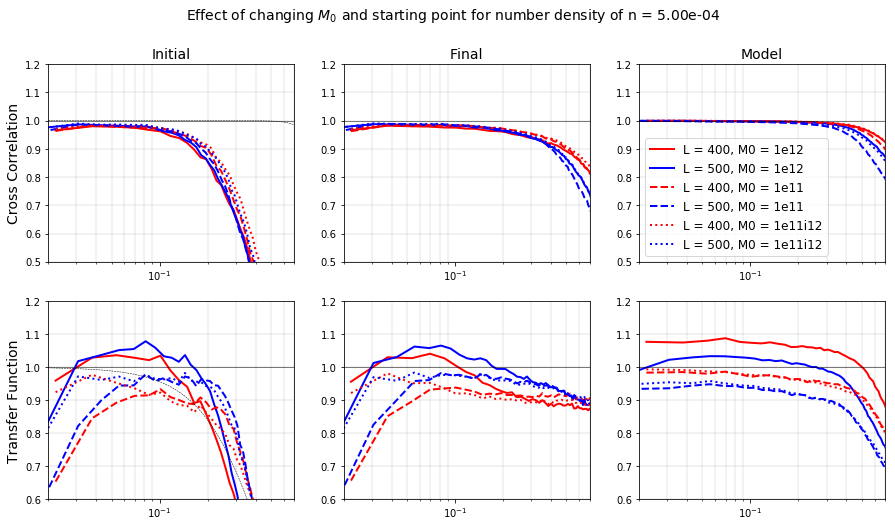

In [66]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
for key in ['400m12', '500m12']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-',  label='L = %s, M0 = 1e%s'%(key[:3], key[4:6]))
    i+=1
i = 0 
for key in ['400m11', '500m11']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '--', label='L = %s, M0 = 1e%s'%(key[:3], key[4:6]))
    i+=1
i = 0 
for key in ['400m11i12-5N', '500m11i12-5N']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = ':', label='L = %s, M0 = 1e%s'%(key[:3], key[4:9]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Effect of changing $M_0$ and starting point for number density of n = %0.2e'%0.0005, fontsize =14)
# fig.savefig('./figs/change_M0_cont.pdf')

# Effect of procedure

In [ ]:
skeys('400m11')

['400m11', '400m11i12-5N', '400m11i12-1N']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

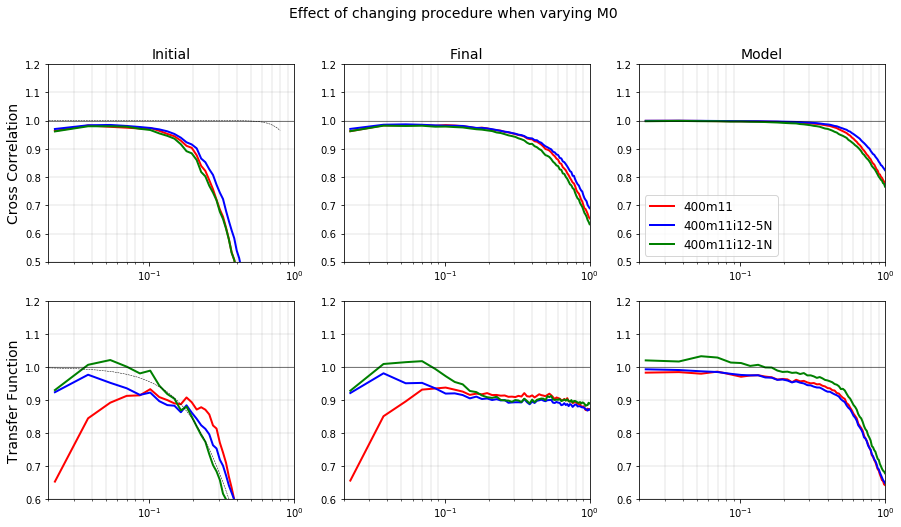

In [ ]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
# for key in ['200m11i12-5N', '400m11i12-5N']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='L = %s, N = %d'%(key[:3], 64*int(key[:3])/200))
#     i+=1
for key in skeys('400m11'):
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label=key)
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 1)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 1)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Effect of changing procedure when varying M0', fontsize =14)
# fig.savefig('./figs/change_procedure.pdf')

## Effect fo resolution

In [540]:
skeys('400m')

['400m11', '400m12', '400m11i12-5N', '400m11i12-1N']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

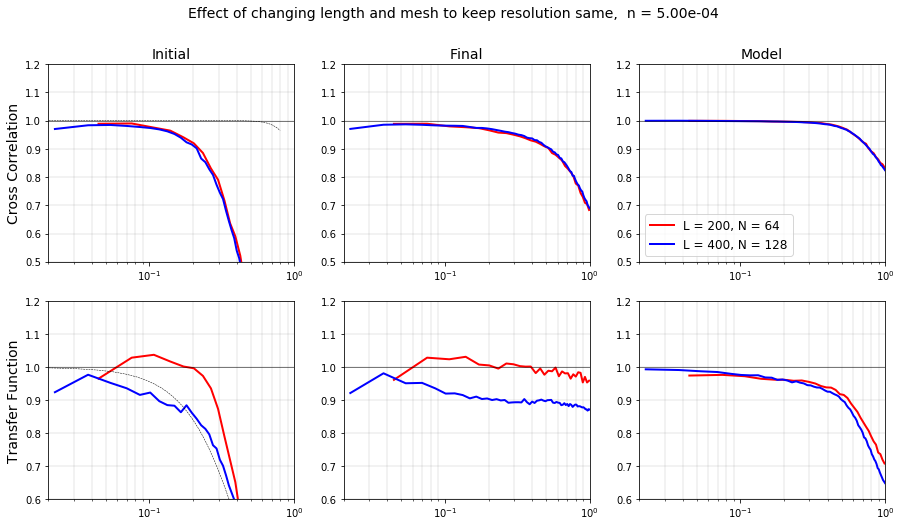

In [544]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
# for key in ['200m11i12-5N', '400m11i12-5N']:
#     dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='L = %s, N = %d'%(key[:3], 64*int(key[:3])/200))
#     i+=1
for key in ['200m11', '400m11i12-5N']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='L = %s, N = %d'%(key[:3], 64*int(key[:3])/200))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 1)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 1)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Effect of changing length and mesh to keep resolution same,  n = %0.2e'%0.0005, fontsize =14)
# fig.savefig('./figs/same_res.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

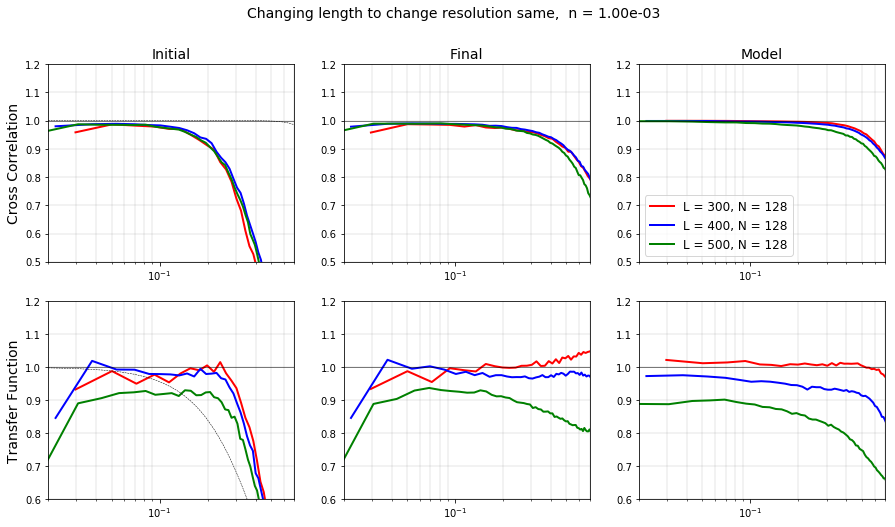

In [70]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
for key in ['3001m11i12-3N', '4001m11i12-3N', '5001m11i12-3N']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label='L = %s, N = 128'%(key[:3]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Changing length to change resolution same,  n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_length.pdf')

## Effect of \sigma

In [ ]:
BigFileMesh()

In [123]:
skeys('s')

['200fm10s2', '4001m11i12-3N1ps2', '4001m11i12-3Nsg10', '4001m11i12-3Nsg20']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

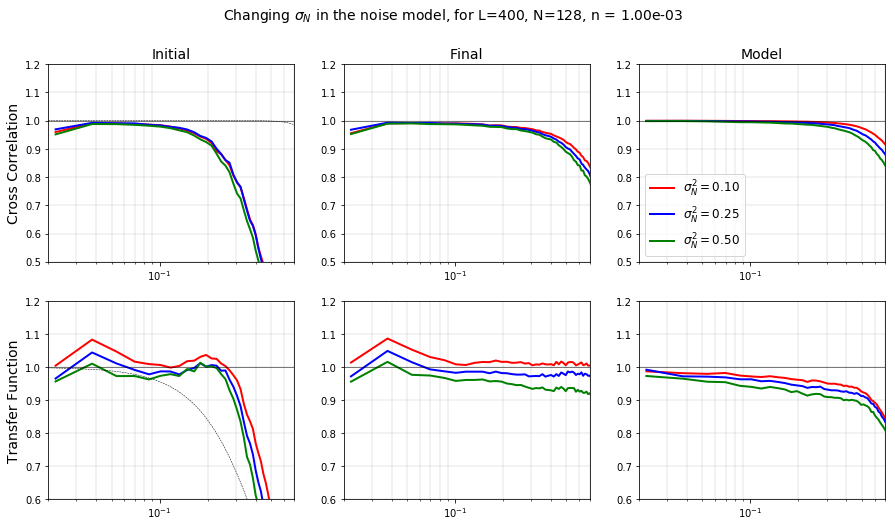

In [512]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0
labels = ['0.1', '0.25', '0.5']
for key in ['4001m11i12-3N1p10v', '4001m11i12-3N1p', '4001m11i12-3N1p50v']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label=r'$\sigma_N^2 = %0.2f$'%float(labels[i]))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Changing $\sigma_N$ in the noise model, for L=400, N=128, n = %0.2e'%0.001, fontsize =14)
# fig.savefig('./figs/change_sigma.pdf')

## Effect of number desnsity

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:168: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:169: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

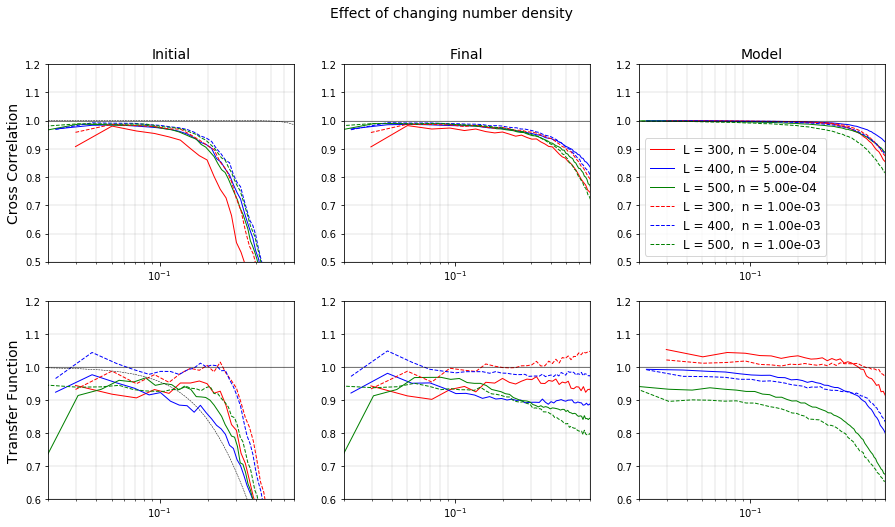

In [165]:

%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0 
for key in ['300m11i12W', '400m11i12-5N', '500m11i12-3N1p',]:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=1, ls = '-', label='L = %s, n = %0.2e'%(key[:3], 0.0005))
    i+=1

i = 0 
for key in ['3001m11i12-3N', '4001m11i12-3N1p', '5001m11i12-3N1p']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=1, ls = '--', label='L = %s,  n = %0.2e'%(key[:3], 0.001))
    i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=12)

fig.suptitle(r'Effect of changing number density ', fontsize =14)
# fig.savefig('./figs/change_numd.pdf')

## Effect of scatter

In [14]:
skeys('sg')

['300m11i12-5Nsg10',
 '300m11i12-3N1psg10',
 '4001m11i12-3Nsg10',
 '4001m11i12-3Nsg20',
 '4001m11i12-3Nsg30',
 '500m11i12-3N1psg20',
 '500m11i12-3N1psg10']

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:173: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:177: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

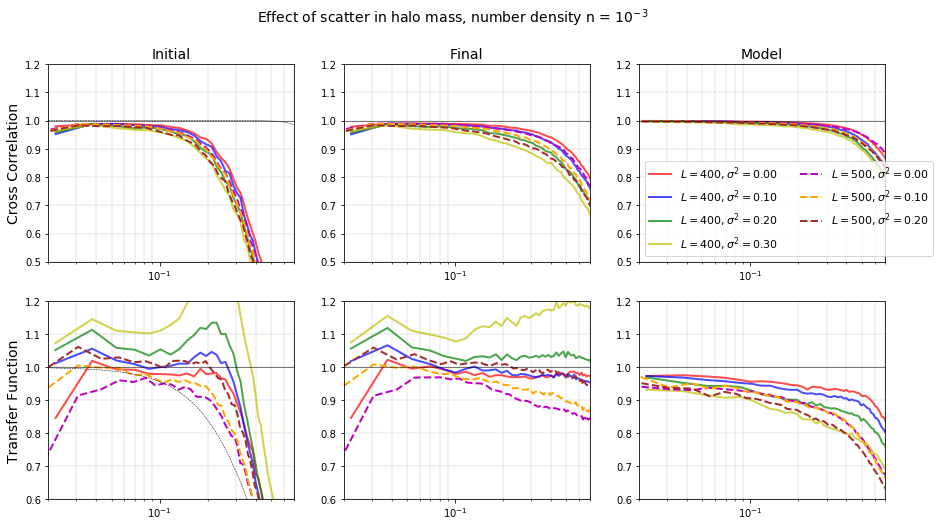

In [526]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0
labels = ['0.0', '0.1', '0.2', '0.3']
for key in ['4001m11i12-3N', '4001m11i12-3Nsg10', '4001m11i12-3Nsg20', '4001m11i12-3Nsg30']:
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', alpha=0.7,
                  label=r'$L = 400,  \sigma^2 = %0.2f$'%float(labels[i]))
    i+=1

i=0
for key in ['500m11i12-3N1p', '500m11i12-3N1psg10', '500m11i12-3N1psg20']:
    dgrep.summary(report[key], fig, ax, c=colors[i+4%7], lw=2, ls = '--', label=r'$L = 500, \sigma^2 = %0.2f$'%float(labels[i]))
    i+=1

# i=0
# labels = ['0.0', '0.1']
# for key in ['300m11i12W', '300m11i12-5Nsg10']:
#     dgrep.summary(report[key], fig, ax, c=colors[i+3%7], lw=2, ls = '--', label=r'$L = 300, n = 5*10^{-4}, \sigma^2 = %0.2f$'%float(labels[i]))
#     i+=1

dgrep.summary1(whiterp, fig, ax[:, 0], c='k', lw=0.5, ls = '--')

for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=11, ncol=2)

fig.suptitle(r'Effect of scatter in halo mass, number density n = $10^{-3}$', fontsize =14)
# fig.savefig('./figs/scatterhalos.pdf')

In [513]:
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
# fofd = BigFileCatalog(bpath + 'opt_s999_testsm3sg0/FOFd/', header= 'Header')
# fofd10 = BigFileCatalog(bpath + 'opt_s999_testsm3sg10/FOFd/', header= 'Header')
# fofd10n = BigFileCatalog(bpath + 'opt_s999_testsm3sg10/FOFnosig/', header= 'Header')
# fofd20 = BigFileCatalog(bpath + 'opt_s999_testsm3sg20/FOFd/', header= 'Header')
# fofd20n = BigFileCatalog(bpath + 'opt_s999_testsm3sg20/FOFnosig/', header= 'Header')
# fofd30 = BigFileCatalog(bpath + 'opt_s999_testsm3sg30/FOFd/', header= 'Header')

# num = fofd20.size

# hmass = fofd20n['AMass'].compute()*1e10
# hpos = fofdall['PeakPosition'].compute()

# hm30, hp30 = dg.scatter_catalog(hmass, hpos, 0.3)
# hm20, hp20 = dg.scatter_catalog(hmass, hpos, 0.2)
# hm10, hp10 = dg.scatter_catalog(hmass, hpos, 0.1)

# print(hmass[:num].sum(), hm10[:num].sum(), hm20[:num].sum())

# h00 = pm.paint(hpos[:num], hmass[:num])
# h10 = pm.paint(hp10[:num], hm20[:num])
# h20 = pm.paint(hp20[:num], hm20[:num])
# h30 = pm.paint(hp30[:num], hm30[:num])

# fig, ax = plt.subplots(1,3, figsize=(15, 4))
# dg.plot_2pt(h00, h10, axin=ax, color='r')
# dg.plot_2pt(h00, h20, axin=ax, color='b')
# dg.plot_2pt(h00, h30, axin=ax, color='g')
# ax[2].set_ylim(0.8, 1.2)

# plt.show()


# h00 = pm.paint(fofd['PeakPosition'][l1:num] )
# h10 = pm.paint(fofd10['PeakPosition'][l1:l2])
# h20 = pm.paint(fofd20['PeakPosition'][l1:l2])
# h30 = pm.paint(fofd30['PeakPosition'][l1:l2])

# # h00 = pm.paint(fofd['PeakPosition'][l1:num-5], fofd['Mass'][l1:num-5] )

# # h10 = pm.paint(fofd10['PeakPosition'][l1:l2], fofd10['scattered'][l1:l2].compute()*1e10)
# # h20 = pm.paint(fofd20['PeakPosition'][l1:l2], fofd20['scattered'][l1:l2].compute()*1e10)
# # h30 = pm.paint(fofd30['PeakPosition'][l1:l2], fofd30['scattered'][l1:l2].compute()*1e10)


/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:272: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)


(0.85, 1.15)

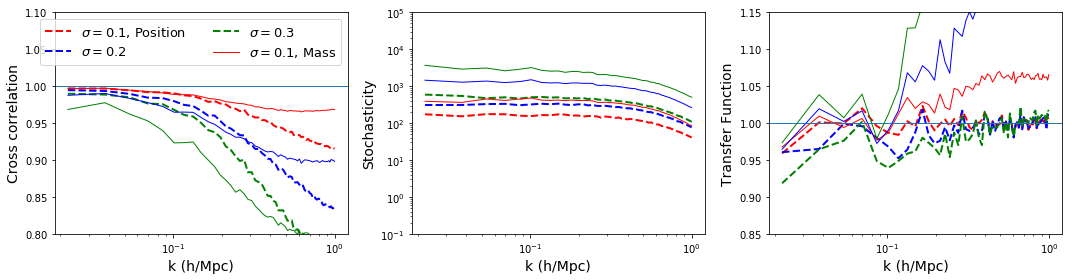

In [198]:
bs, nc, numd = 400, 128, 1e-3
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)

bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L%04d_N%04d_05step-fof/lhd_S0100/n%d/'%(bs, nc, numd*1e4)

fofd00 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3/FOFd/', header= 'Header')
fofd100 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3sg10/FOFd/', header= 'Header')
fofd200 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3sg20/FOFd/', header= 'Header')
fofd300 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3sg30/FOFd/', header= 'Header')


l1, l2 = 0, num


h000 = pm.paint(fofd00['PeakPosition'])
h100 = pm.paint(fofd100['PeakPosition'])
h200 = pm.paint(fofd200['PeakPosition'])
h300 = pm.paint(fofd300['PeakPosition'])

fig, ax = plt.subplots(1,3, figsize=(15, 4))
dg.plot_2pt(h000, h100, axin=ax, color='r', ls="--", lw=2, label = r'$\sigma=0.1$, Position')
dg.plot_2pt(h000, h200, axin=ax, color='b', ls="--", lw=2, label = r'$\sigma=0.2$')
dg.plot_2pt(h000, h300, axin=ax, color='g', ls="--", lw=2, label = r'$\sigma=0.3$')

h000 = pm.paint(fofd00['PeakPosition'], fofd00['Mass'].compute()*1e10)
h100 = pm.paint(fofd100['PeakPosition'], fofd100['scattered'].compute()*1e10)
h200 = pm.paint(fofd200['PeakPosition'], fofd200['scattered'].compute()*1e10)
h300 = pm.paint(fofd300['PeakPosition'], fofd300['scattered'].compute()*1e10)

dg.plot_2pt(h000, h100, axin=ax, color='r', ls="-", lw=1, label = r'$\sigma=0.1$, Mass')
dg.plot_2pt(h000, h200, axin=ax, color='b', ls="-", lw=1)
dg.plot_2pt(h000, h300, axin=ax, color='g', ls="-", lw=1)

ax[2].set_ylim(0.85, 1.15)

# fig.savefig('figs/whatscatterdoes.pdf')

In [ ]:
h000 = BigFileMesh(bpath + '/opt_s999_MdowniM12-3N1psm3/datap/', dataset= 'mapp').paint()
# h100 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3sg10/datap/', dataset= 'mapp').paint()
h200 = BigFileMesh(bpath + '/opt_s999_MdowniM12-3N1psm3sg20/datap/', dataset= 'mapp').paint()
# h300 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3sg30/datap/', dataset= 'mapp').paint()
# h000 = pm.paint(fofd00['PeakPosition'], fofd00['Mass'].compute()*1e10)
# h100 = pm.paint(fofd100['PeakPosition'], fofd100['scattered'].compute()*1e10)
# h200 = pm.paint(fofd200['PeakPosition'], fofd200['scattered'].compute()*1e10)
# h300 = pm.paint(fofd300['PeakPosition'], fofd300['scattered'].compute()*1e10)

h000r = ft.smooth(h000, 3, 'fingauss')
h200r = ft.smooth(h200, 3, 'fingauss')
# h300r = ft.smooth(h300, 3, 'fingauss')
predictr = ft.smooth(predict, 3, 'fingauss')

M0 = 1e11
bins = np.linspace(-3, 3, 200)
func = dg.normal
fig, ax = plt.subplots(2, 3, figsize = (14, 8))
fit2 = dg.plot_noise(h200r.value, predictr.value, M0=M0, binfit=bins, c='r', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
# fit3 = dg.plot_noise(h300r.value, predictr.value, M0=M0, binfit=bins, c='y', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
fit0 = dg.plot_noise(h000r.value, predictr.value, M0=M0, binfit=bins, c='g', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
# fit2 = dg.plot_noise(h000r.value, h200r.value, M0=M0, binfit=bins, c='b', axin=ax, func=dg.laplace, mbin=mbinsm)

In [ ]:
msave = [1e15] + list(mbinsm)
tosave = []

for i, res in enumerate(fit0):
    tosave.append([msave[i], msave[i+1], res.x[1], res.x[2]])
tosave = np.array(tosave)
print(tosave)
fpath = mtpath + 'hist_M0%d.txt'%(np.log10(M0))
print(fpath)
# np.savetxt(fpath, tosave, header ='Mmax, Mmin, mean(offset: data-model), b')

In [ ]:
tosave[:, -1]

In [ ]:
tosave[:, -1]*2 > 0.1**0.5

In [ ]:
def offd(pm, predictsm, mappsm, noisef, M0):
    toret = pm.create(mode='real', zeros=True)
    noise = np.loadtxt(noisef)
    # for foo in range(len(mbinsm) -2):                                                                                                                                                                                                                                                                                    
    for foo in range(noise.shape[0]):
        mhigh = noise[foo][0]
        mlow = noise[foo][1]
        pos = numpy.where((mappsm[...] > mlow) & (mappsm[...] <= mhigh))
        toret[...][pos] = noise[foo][2]
        print(noise[foo][3])
    toret[...] += np.log(M0 + predictsm[...])
    toret[...] = np.exp(toret[...])
    return toret 

In [ ]:
fpath = mtpath + 'hist_M0%d.txt'%(np.log10(M0))
fpath

In [ ]:
offd(pm, predictr, h000r, fpath, M0);

In [ ]:
predictoff = offd(pm, predictr, h000r, fpath, M0)

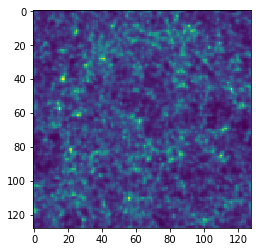

In [378]:
plt.imshow(predictoff[...].sum(axis=0))

/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:272: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axe

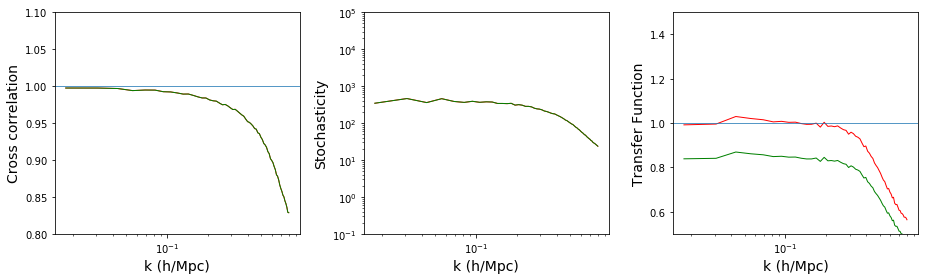

In [379]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
dg.plot_2pt(h000r, predictr, axin=ax, color='r')
# dg.plot_2pt(h200r, predictr, axin=ax, color='b')
dg.plot_2pt(h000r, predictoff, axin=ax, color='g')
# dg.plot_2pt(h000r, predictoff, axin=ax, color='c')

In [209]:
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
# d00 = BigFileMesh(bpath + 'opt_s999_testsm3sg0/datap/', dataset= 'mapp').paint()
# d001 = BigFileMesh(bpath + 'opt_s999_testsm3/datap/', dataset= 'mapp').paint()
# d10 = BigFileMesh(bpath + 'opt_s999_testsm3sg10/datap/', dataset= 'mapp').paint()
# d20 = BigFileMesh(bpath + 'opt_s999_testsm3sg20/datap/', dataset= 'mapp').paint()
# d30 = BigFileMesh(bpath + 'opt_s999_testsm3sg30/datap/', dataset= 'mapp').paint()

d00 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3/datap/', dataset= 'mapp').paint()
d001 = BigFileMesh(bpath + 'opt_s999_testsm3sg0/datap/', dataset= 'mapp').paint()
d10 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3sg10/datap/', dataset= 'mapp').paint()
d20 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3sg20/datap/', dataset= 'mapp').paint()
d30 = BigFileMesh(bpath + 'opt_s999_MdowniM12-3N1psm3sg30/datap/', dataset= 'mapp').paint()
dtest = BigFileMesh(bpath + 'opt_s999_testsm3sg20/datap/', dataset= 'mapp').paint()


In [441]:
d00.cmean(), d001.cmean(), d10.cmean(), d20.cmean(), d30.cmean()

(717471517841.38342,
 718264519012.01282,
 739979394658.99939,
 812539846932.93872,
 948762645492.05176)

In [437]:
pk0 = FFTPower(d00/d00.cmean(), mode='1d').power
pk1 = FFTPower(d10/d10.cmean(), mode='1d').power
pk2 = FFTPower(d20/d20.cmean(), mode='1d').power
pk3 = FFTPower(d30/d30.cmean(), mode='1d').power


/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:265: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:266: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:267: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axe

(0.8, 1.2)

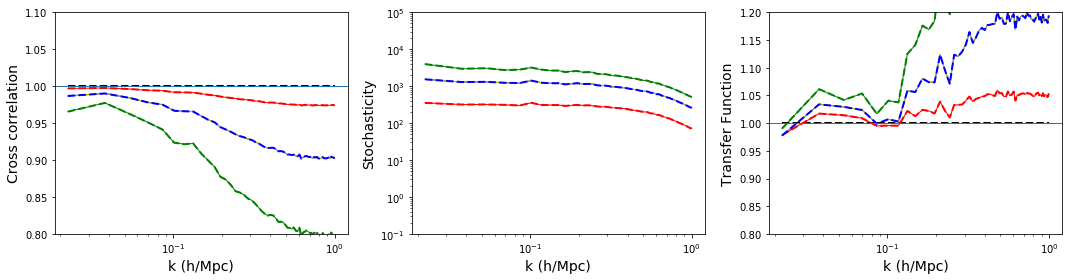

In [439]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))
dg.plot_2pt(d00, d10, axin=ax, color='r')
dg.plot_2pt(d00, d20, axin=ax, color='b')
dg.plot_2pt(d00, d30, axin=ax, color='g')
dg.plot_2pt(d00, dtest, axin=ax, color='y')
dg.plot_2pt(d001, d00, axin=ax, color='k', ls="--", lw=2)
dg.plot_2pt(d001, d10, axin=ax, color='r', ls="--", lw=2)
dg.plot_2pt(d001, d20, axin=ax, color='b', ls="--", lw=2)
dg.plot_2pt(d001, d30, axin=ax, color='g', ls="--", lw=2)
ax[2].set_ylim(0.8, 1.2)


/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:265: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:266: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:267: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axe

(0.8, 1.2)

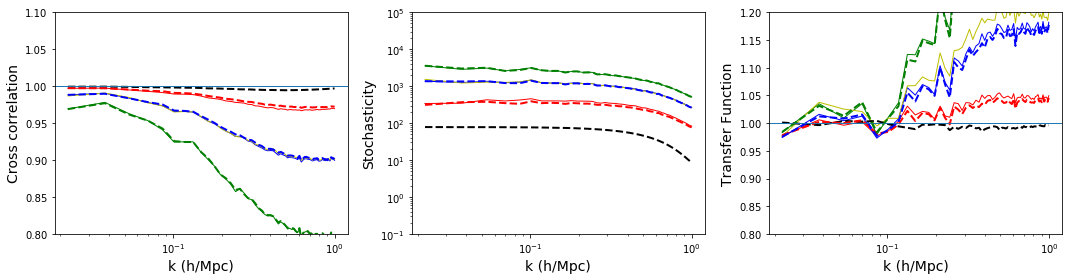

In [442]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))
dg.plot_2pt(d00, d10, axin=ax, color='r')
dg.plot_2pt(d00, d20, axin=ax, color='b')
dg.plot_2pt(d00, d30, axin=ax, color='g')
dg.plot_2pt(d00, dtest, axin=ax, color='y')
dg.plot_2pt(d001, d00, axin=ax, color='k', ls="--", lw=2)
dg.plot_2pt(d001, d10, axin=ax, color='r', ls="--", lw=2)
dg.plot_2pt(d001, d20, axin=ax, color='b', ls="--", lw=2)
dg.plot_2pt(d001, d30, axin=ax, color='g', ls="--", lw=2)
ax[2].set_ylim(0.8, 1.2)


# Find halos

In [29]:
# loadfile('40017m11', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-3N1psm3/')
loadfile('4001m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['4001']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40017m11-naoff', 'M0_11/128-03-0.00', ipath=outpath%ftup['40017']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40019m11-naoff', 'M0_110/128-03-0.00', ipath=outpath%ftup['40019']+ 'opt_s999_MdowniM12-nasm3off/')                                         
loadfile('40018m11-naoff', 'M0_110/128-03-0.00', ipath=outpath%ftup['40018']+ 'opt_s999_MdowniM12-nasm3off/')                                         


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

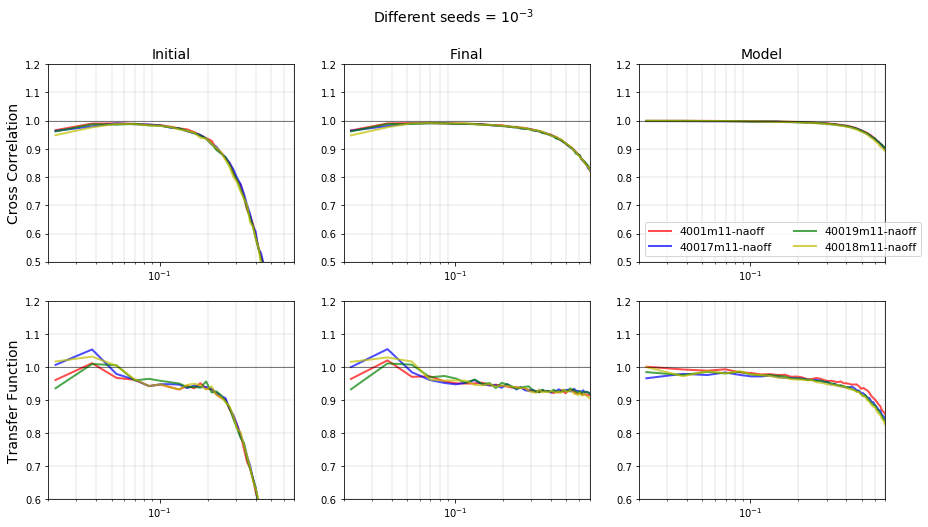

In [33]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))


i = 0
labels = ['0.0', '0.1', '0.2', '0.3']
for key in skeys('4001'):
    dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', alpha=0.7,
                  label=key)
    i+=1


for axis in ax[0]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.6, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3, fontsize=11, ncol=2)

fig.suptitle(r'Different seeds = $10^{-3}$', fontsize =14)
# fig.savefig('./figs/scatterhalos.pdf')

In [ ]:
dgrep.evaluate()

In [64]:
pkmp, pkmd = [], []
print(skeys('4001'))
for key in skeys('4001'):
    kk = report[key][5]['k']
    pkmp.append(report[key][5]['power'])
    pkmd.append(report[key][6]['power'])
    modes = report[key][3]['modes']    

['4001m11-naoff', '40017m11-naoff', '40019m11-naoff', '40018m11-naoff']


In [120]:
pkpmean = np.array(pkmp)[:3].mean(axis=0)
pkdmean = np.array(pkmd)[:3].mean(axis=0)
pktfmean = (np.array(pkmp)[:3]/np.array(pkmd)[:3]).mean(axis=0)
pkdiff = (np.array(pkmd)[:3] - np.array(pkmp)[:3]).mean(axis=0)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(0.9, 1.1)

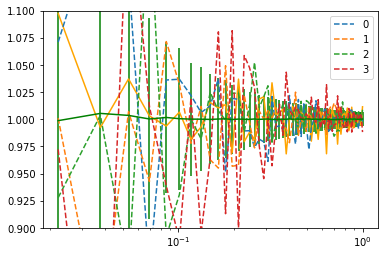

In [121]:
# plt.plot(kk, pkmp[-1]/pkmd[-1])
# plt.plot(kk, pkpmean/pkdmean, 'r--')
# plt.plot(kk, pktfmean, 'g:')
plt.errorbar(kk, pktfmean/(pkpmean/pkdmean), yerr=(2/modes)**0.5, color='g')
# plt.plot(kk, pkmp[-1]/pkmd[-1]/(pkpmean/pkdmean), 'r')
# plt.plot(kk, pkmp[-1]/pkmd[-1]/(pktfmean), 'b')
plt.plot(kk, (pkmp[-1] +pkdiff)/pkmd[-1] , 'orange')
for i in range(4):
    plt.plot(kk, pkmd[i]/pkdmean, '--' , label=i)
    
# plt.plot(kk, pkmp[-1]/pkmd[-1]/(pkmp[-2]/pkmd[-2]), 'b')
plt.xscale('log')
plt.legend()
plt.ylim(0.9, 1.1)
# plt.ylim(0.95, 1.05)

In [232]:
kk[mask].max()

0.99734261633707721

In [227]:
pkdiff2 = pkdiff.copy()
pkdiff2[pkdiff2 < 0] = np.nan
mask = ~np.isnan(pkdiff2)

ipkdiff = interpolate(kk[mask], pkdiff2[mask], k=5, ext=3)
ipkdiff2 = interpolate(kk[20:], pkdiff2[20:], k=5)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:599: ComplexWarning: Casting complex values to real discards the imaginary part
  xb=bbox[0],xe=bbox[1],s=0)


In [192]:
kkarray = np.array(sum(ki **2 for ki in pm.k)**0.5 )


In [240]:
from scipy.interpolate import interp1d

In [ ]:
interp1d(dd)

In [245]:
sys.path.append('/global/homes/c/chmodi/Programs/Py_codes/modules/__pycache__/')
import mytools as tools


In [260]:
lipkdiff = tools.loginterp(kk[-50:], pkdmean[-50:], rdx=1e-3)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:599: ComplexWarning: Casting complex values to real discards the imaginary part
  xb=bbox[0],xe=bbox[1],s=0)


(-1.26601198393+0j) (-6.03659509019+0j)


In [265]:
pm2 = PMnew(BoxSize = bs, Nmesh=[2*nc]*3)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1.0, 10000.0)

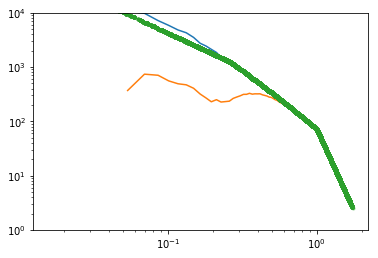

In [261]:
plt.plot(kk, pkdmean)

plt.plot(kk, pkdiff)
# plt.plot(kkarray.flatten(), ipkdiff(kkarray).flatten(), ".", alpha=0.5)
plt.plot(kkarray.flatten(), lipkdiff(kkarray).flatten(), ".", alpha=0.5)

# plt.plot(kkarray.flatten(), ipkdiff2(kkarray).flatten(), ".", alpha=0.5)
plt.loglog()

# plt.plot(kk, ipkdiff(kk))
plt.ylim(1e0, 1e4)
# plt.axhline(0)

In [213]:
kkarray[(ipkdiff(kkarray)<0)].min()

1.023793

In [178]:
pm.generate_whitenoise(100, mode='complex')\
            .apply(lambda k, v: v * (ipkdiff(sum(ki **2 for ki in k) **0.5) / v.BoxSize.prod()) ** 0.5)\
            .c2r()



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


RealField:array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       ..., 
       [[ n

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


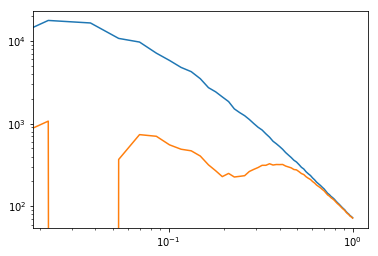

In [89]:
plt.plot(kk, pkdmean)
plt.plot(kk, pkdiff)
plt.xscale('log')
plt.yscale('log')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


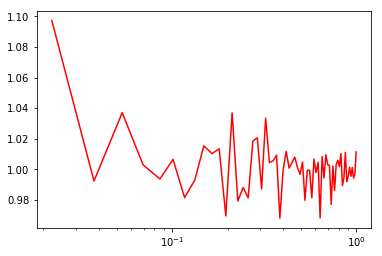

In [83]:
pkdiff = (np.array(pkmd)[:3] - np.array(pkmp)[:3]).mean(axis=0)
plt.plot(kk, (pkmp[-1] +pkdiff)/pkmd[-1] , 'r')
# plt.plot(kk, pkmp[-1]/pkmd[-1]/(pktfmean), 'b')
# plt.plot(kk, pkmp[-1]/pkmd[-1]/(pkmp[-2]/pkmd[-2]), 'b')
plt.xscale('log')
# plt.ylim(0.9, 1.1)

In [10]:
fof0 = BigFileCatalog('/global/cscratch1/sd/chmodi/cosmo4d/data/L0400_N0512_S0100_40step/FOF/', header='Header')[1:]
fof0['Mass'].compute()[:int(400**3 * 5e-3)]*1e10


array([  2.01336424e+15,   1.81268605e+15,   1.54462286e+15, ...,
         7.17310588e+11,   7.17310588e+11,   7.17310588e+11])

In [18]:
tmp = pm.paint(fof0['PeakPosition'].compute()[:int(400**3 * 5e-3)])
tmp2 = pm.paint(fof0['PeakPosition'].compute()[:int(400**3 * 1e-3)])

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:396: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:397: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_ne

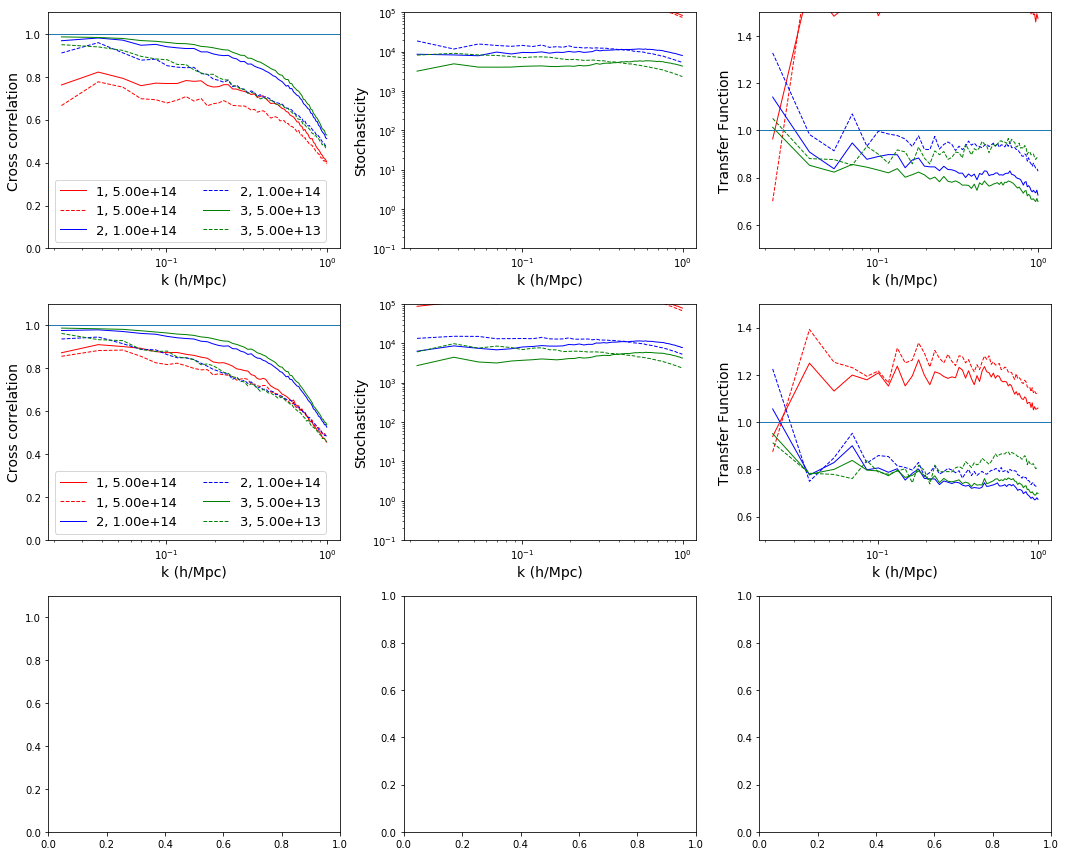

In [19]:
bs, nc= 400, 128
numd = 1e-3
num = int(bs**3 * numd)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)
nmf = mass_function.Num_Mass_Func(bs, nc, 0.3175)


bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
dpath = bpath + 'opt_s999_MdowniM12-3N1psm3/'
fof0 = BigFileCatalog('/global/cscratch1/sd/chmodi/cosmo4d/data/L0400_N0128_S0100_40step/FOF/', header='Header')[1:]

mm = 11
ncf, nstepf = 128, 5
fof1 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof1t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 128, 40
fof2 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof2t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 512, 40
fof3 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof3t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fofs = [fof1, fof2, fof3]
fofst = [fof1t, fof2t, fof3t]
# ncf, nstepf = 512, 40
# fof2 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3off/FOFb/3N1psm3off_N%04d_%02steps/FOF'%(ncf, nstepf), header='Header')[1:]



fig, ax = plt.subplots(3, 3, figsize = (15, 12))
for j, M in enumerate([5e14, 1e14, 5e13, 1e13]):
    try:
        r0 = np.where(fof0['Mass'].compute()*1e10 < M)[0][0]
        f0m = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
#         f0p = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
        f0p = pm.paint(fof0['PeakPosition'][:r0])
    except:
        continue
    for i in range(2):
        try:
            r = np.where(fofs[i]['Mass'].compute()*1e10 < M)[0][0]
            rt = np.where(fofst[i]['Mass'].compute()*1e10 < M)[0][0]
        except:
            continue
        fm  = pm.paint(fofs[i]['PeakPosition'][:r], fofs[i]['Mass'][:r]*1e10)
#         fp  = pm.paint(fofst[i]['PeakPosition'][:rt], fofst[i]['Mass'][:rt]*1e10)
        fp  = pm.paint(fofs[i]['PeakPosition'][:r])
        dg.plot_2pt(f0m, fm, axin = ax[i], color=colors[j], label = '%d, %0.2e'%(j+1, M))
        dg.plot_2pt(f0p, fp, axin = ax[i], color=colors[j], ls = "--", label = '%d, %0.2e'%(j+1, M))

for axis in ax[:,0]:
    axis.set_ylim(0, 1.1)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_ne

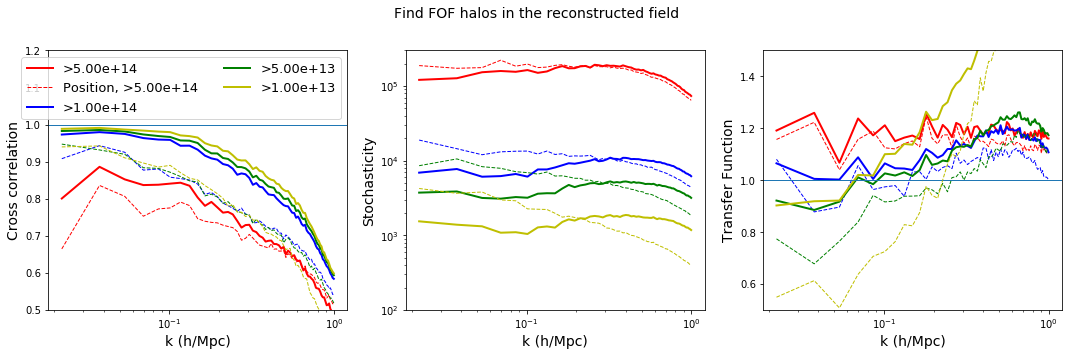

In [981]:
bs, nc= 400, 128
numd = 1e-3
num = int(bs**3 * numd)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)
nmf = mass_function.Num_Mass_Func(bs, nc, 0.3175)


bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
dpath = bpath + 'opt_s999_MdowniM12-3N1psm3off/'
fof0 = BigFileCatalog(dpath + 'FOFd', header='Header')

mm = 10
ncf, nstepf = 128, 5
fof1 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
# fof1t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 128, 40
fof2 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
# fof2t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 512, 40
fof3 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
# fof3t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fofs = [fof1, fof2, fof3]
fofst = [fof1t, fof2t, fof3t]
# ncf, nstepf = 512, 40
# fof2 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3off/FOFb/3N1psm3off_N%04d_%02steps/FOF'%(ncf, nstepf), header='Header')[1:]



fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for j, M in enumerate([5e14, 1e14, 5e13, 1e13]):
    r0 = np.where(fof0['Mass'].compute()*1e10 < M)[0][0]
    f0m = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
#     f0p = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
    f0p = pm.paint(fof0['PeakPosition'][:r0])
    for i in [-1]:
        try:
            r = np.where(fofs[i]['Mass'].compute()*1e10 < M)[0][0]
            rt = np.where(fofst[i]['Mass'].compute()*1e10 < M)[0][0]
        except:
            continue
        fm  = pm.paint(fofs[i]['PeakPosition'][:r], fofs[i]['Mass'][:r]*1e10)
#         fp  = pm.paint(fofst[i]['PeakPosition'][:rt], fofst[i]['Mass'][:rt]*1e10)
        fp  = pm.paint(fofs[i]['PeakPosition'][:r])
        dg.plot_2pt(f0m, fm, axin = ax, color=colors[j], lw=2, label = '>%0.2e'%(M))
        if not j:
            dg.plot_2pt(f0p, fp, axin = ax, color=colors[j], ls = "--", label = 'Position, >%0.2e'%(M))
        else:
            dg.plot_2pt(f0p, fp, axin = ax, color=colors[j], ls = "--")

ax[0].set_ylim(0.5, 1.2)
ax[1].set_ylim(100, 3e5)
ax[2].set_ylim(0.5, 1.5)
fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.suptitle('Find FOF halos in the reconstructed field', fontsize=14)

fig.savefig('./figs/fof_compare.pdf')
# for axis in ax:
#     axis.set_ylim(0, 1.1)


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_ne

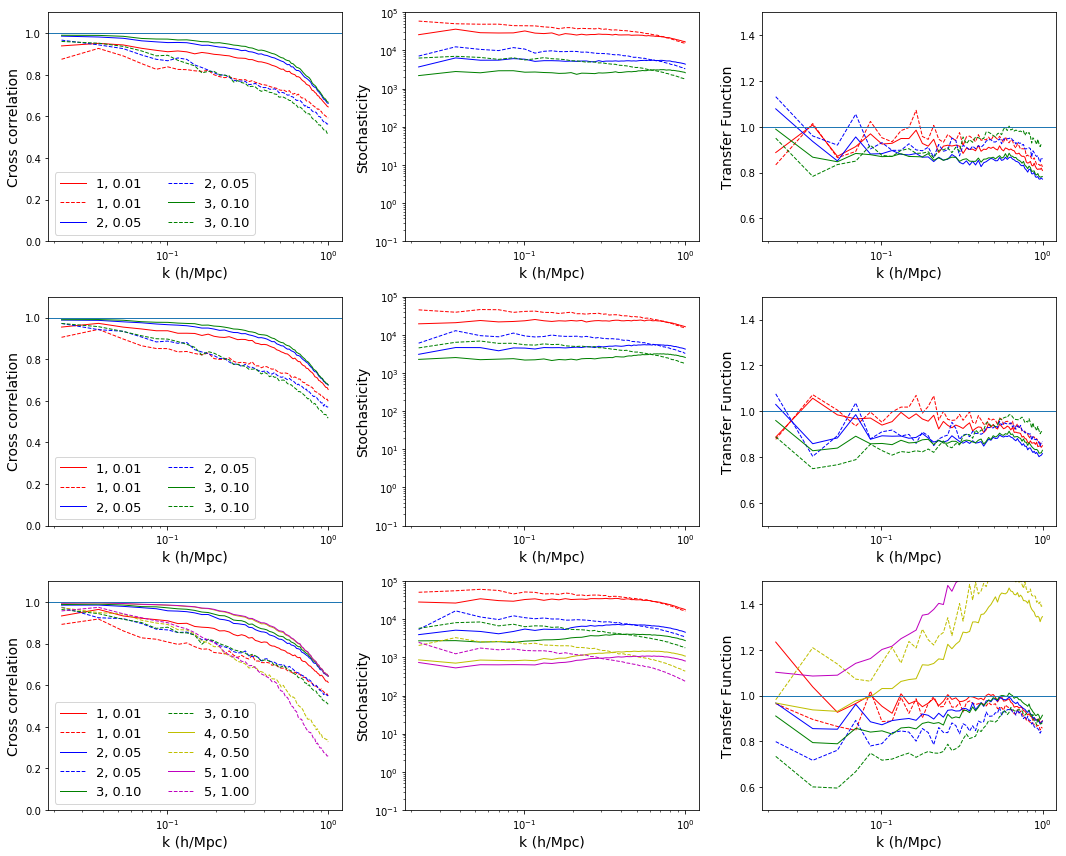

In [834]:
bs, nc= 400, 128
numd = 1e-3
num = int(bs**3 * numd)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)
nmf = mass_function.Num_Mass_Func(bs, nc, 0.3175)


bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
dpath = bpath + 'opt_s999_MdowniM12-3N1psm3/'
fof0 = BigFileCatalog(dpath + 'FOFd', header='Header')

mm = 11
ncf, nstepf = 128, 5
fof1 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof1t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 128, 40
fof2 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof2t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
ncf, nstepf = 512, 40
fof3 = BigFileCatalog(dpath + 'FOFb/M%02d_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fof3t = BigFileCatalog(dpath + 'FOFb/M%02d_itfS0700_N%04d_%02dstep/FOF'%(mm, ncf, nstepf), header='Header')[1:]
fofs = [fof1, fof2, fof3]
fofst = [fof1t, fof2t, fof3t]
# ncf, nstepf = 512, 40
# fof2 = BigFileCatalog(bpath + 'opt_s999_MdowniM12-3N1psm3off/FOFb/3N1psm3off_N%04d_%02steps/FOF'%(ncf, nstepf), header='Header')[1:]



fig, ax = plt.subplots(3, 3, figsize = (15, 12))
for j, frac in enumerate([0.01, 0.05, 0.1, 0.5, 1]):
    r0, r, rt = int(num*frac), int(num*frac), int(num*frac)
    f0m = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
#     f0p = pm.paint(fof0['PeakPosition'][:r0], fof0['Mass'][:r0]*1e10)
    f0p = pm.paint(fof0['PeakPosition'][:r0])
    for i in range(len(fofs)):
        if r < fofs[i].size:
            fm  = pm.paint(fofs[i]['PeakPosition'][:r], fofs[i]['Mass'][:r]*1e10)
#             fp  = pm.paint(fofst[i]['PeakPosition'][:rt], fofst[i]['Mass'][:rt]*1e10)
            fp  = pm.paint(fofs[i]['PeakPosition'][:r])
            dg.plot_2pt(f0m, fm, axin = ax[i], color=colors[j], label = '%d, %0.2f'%(j+1, frac))
            dg.plot_2pt(f0p, fp, axin = ax[i], color=colors[j], ls = "--", label = '%d, %0.2f'%(j+1, frac))

for axis in ax[:,0]:
    axis.set_ylim(0, 1.1)


In [828]:
for j, M in enumerate([5e14, 1e14, 5e13, 1e13]):
    r0 = np.where(fof0['Mass'].compute()*1e10 < M)[0][0]
    for i in range(len(fofs)):
        try:
            r = np.where(fofs[i]['Mass'].compute()*1e10 < M)[0][0]
            rt = np.where(fofst[i]['Mass'].compute()*1e10 < M)[0][0]
        except: r, rt = 0, 0
    print('%0.2e'%M, r0, r, rt)

5.00e+14 158 149 155
1.00e+14 2510 2402 3346
5.00e+13 6071 5468 8440
1.00e+13 32837 15475 41341


##### how initial changed 

/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:270: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:271: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:272: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axe

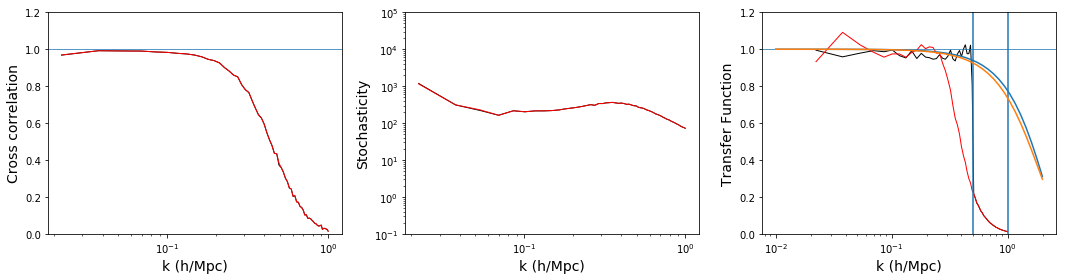

In [818]:
kny = np.pi*nc/bs
side = bs/nc

sfit = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3/FOFb/M11_itfS0700_N0128_05step/mesh', 's').paint()
sbfit = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3/M0_11/128-03-0.00/best-fit/', 's').paint()
strue = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3/datap', 's').paint()

fig,ax = dg.plot_2pt(1+strue, 1+sfit)
dg.plot_2pt(1+strue, 1+sbfit, axin=ax, color='r')
ax[0].set_ylim(0, 1.2)
ax[-1].set_ylim(0, 1.2)
ax[-1].axvline(kny)
ax[-1].axvline(kny/2, )
kk = np.logspace(-2., 0.3)
ax[-1].plot(kk, tophat(kk, side/2))
ax[-1].plot(kk, gauss(kk, side/4))


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[]

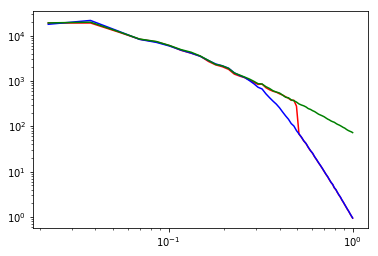

In [819]:
pksf = FFTPower(sfit, '1d').power
pkbf = FFTPower(sbfit, '1d').power
pktf = FFTPower(strue, '1d').power
plt.plot(pksf['k'], pksf['power'], 'r')
plt.plot(pksf['k'], pkbf['power'], 'b')
plt.plot(pksf['k'], pktf['power'], 'g')
plt.loglog()

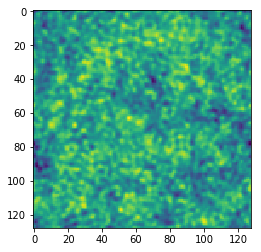

In [820]:
plt.imshow(sfit[...].sum(axis=0))

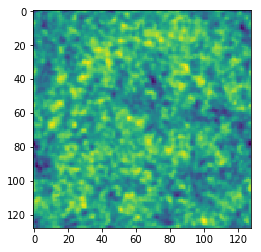

In [821]:
plt.imshow(sbfit[...].sum(axis=0))

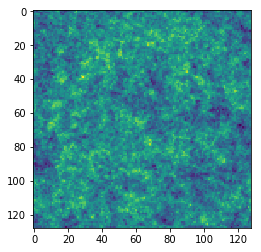

In [822]:
plt.imshow(strue[...].sum(axis=0))

/global/homes/c/chmodi/Programs/Py_codes/modules/mymass_function.py:290: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


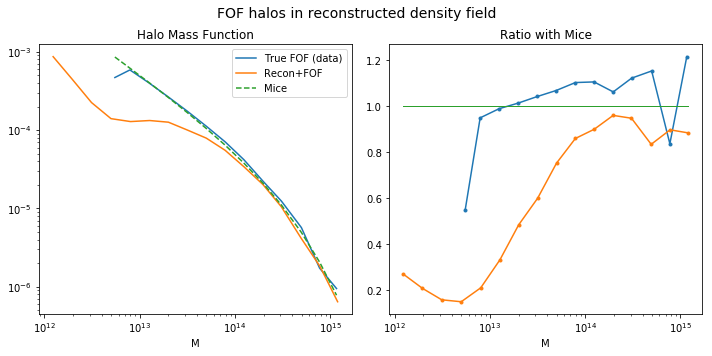

In [971]:

nmf = mass_function.Num_Mass_Func(bs, nc, 0.3175)
l1, l2, dl = 12, 15.5, 0.2

nf0, dummy, nm0 = nmf.calc_array(fof0['Mass'].compute()*1e10, l1, l2, dl)
nf1, dummy, nm1 = nmf.calc_array(fof1['Mass'].compute()*1e10, l1, l2, dl)
nf2, dummy, nm2 = nmf.calc_array(fof2['Mass'].compute()*1e10, l1, l2, dl)
nf3, dummy, nm3 = nmf.calc_array(fof3['Mass'].compute()*1e10, l1, l2, dl)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(nm0, nf0, label='True FOF (data)')
# ax[0].plot(nm1, nf1)
# ax[0].plot(nm2, nf2)
ax[0].plot(nm3, nf3, label='Recon+FOF')
ax[0].plot(nm0, mf.Micef(nm0), '--', label='Mice')
ax[0].loglog()
ax[0].legend()
ax[0].set_title('Halo Mass Function')
# ax[0].set_xlim(3e12, 2e15)

ax[1].plot(nm0, nf0/mf.Micef(nm0), marker=".")
# ax[1].plot(nm1, nf1/mf.Micef(nm1), marker=".")
# ax[1].plot(nm2, nf2/mf.Micef(nm2), marker=".")
ax[1].plot(nm3, nf3/mf.Micef(nm3), marker=".")
ax[1].plot(nm3, mf.Micef(nm3)/mf.Micef(nm3), lw=1)
ax[1].set_xscale('log')
ax[1].legend()
ax[1].set_title('Ratio with Mice')
# ax[1].set_xlim(3e12, 2e15)
for axis in ax:
    axis.set_xlabel('M')

fig.tight_layout(rect=[0,0,1,0.95])
fig.suptitle('FOF halos in reconstructed density field', fontsize=14)
# fig.savefig('./figs/recon_hmf.pdf')

In [773]:
dpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-3N1psm3'
dpath7 = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0700/n10/opt_s999_MdowniM12-3N1psm3'
sinit = BigFileMesh(dpath + '/datap', 's').paint()
sinit7 = BigFileMesh(dpath7 + '/datap', 's').paint()
sfit = BigFileMesh(dpath + '/M0_11/128-03-0.00/best-fit', 's').paint()
sfit7 = BigFileMesh(dpath7 + '/M0_11/128-03-0.00/best-fit', 's').paint()


In [677]:
pks = FFTPower(sfit, mode='1d').power
pks7 = FFTPower(sfit7, mode='1d').power
pki = FFTPower(sinit, mode='1d').power
pki7 = FFTPower(sinit7, mode='1d').power

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


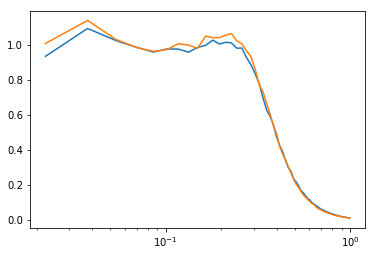

In [678]:
plt.plot(pks['k'], pks['power']/pki['power'])
plt.plot(pks['k'], pks7['power']/pki7['power'])
plt.xscale('log')

In [805]:
# tf =( pks7['power']/pki7['power'])**-0.5
# itf = interpolate(pks7['k'][1:], tf[1:])

def tophat(k, R):
    kr = k*R
    return 3 * (numpy.sin(kr)/kr - numpy.cos(kr))/kr**2

def gauss(k, R):
    kr = k*R
    return np.exp(-0.5*kr**2)

def itf(kk):
    kny = pki7['k'][-1]
    side = kny/numpy.pi
    wts = tophat(pki7['k'][1:], 4*side)
    tf = (pks7['power']/pki7['power'])**-0.5
    tf = tf[1:].real
    return interpolate(pki7['k'][1:], tf*wts)(kk)


def apply_tf(k, f):
    kk = sum(ki**2 for ki in k)**0.5
    return f(kk)

sfit7tf = sfit7.r2c().apply(lambda k, v: apply_tf(k, itf)*v).c2r()
sfittf = sfit.r2c().apply(lambda k, v: apply_tf(k, itf)*v).c2r()

pkstf = FFTPower(sfittf, mode='1d').power
pks7tf = FFTPower(sfit7tf, mode='1d').power


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [777]:
side = bs/nc

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/c/chmo

(0.5, 1.2)

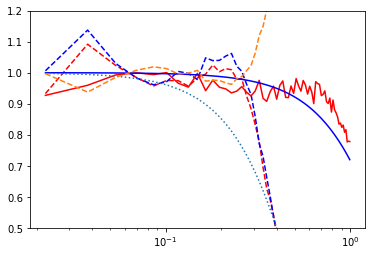

In [778]:

plt.plot(pks['k'], pks['power']/pki['power'], 'r--')
plt.plot(pks['k'], pks7['power']/pki7['power'], 'b--')
plt.plot(pks['k'], pks['power']*itf(pks['k'])**2 /pki['power'],  'r')
plt.plot(pks['k'], pks7['power']*itf(pks['k'])**2 /pki7['power'],  'b')
plt.plot(pki7['k'][1:], tophat(pki7['k'][1:], 2*side), ":")
plt.plot(pki7['k'][1:], itf(pki7['k'][1:]), '--')
plt.xscale('log')
plt.ylim(0.5, 1.2)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.p

(0.5, 1.2)

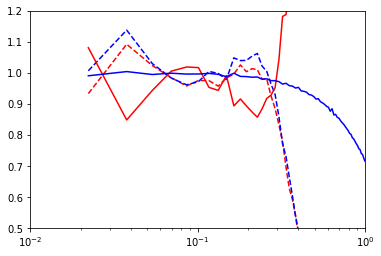

In [909]:
plt.plot(pks['k'], pks['power']/pki['power'], 'r--')
plt.plot(pks['k'], pks7['power']/pki7['power'], 'b--')
plt.plot(pks['k'], pkstf['power']/pki['power'], 'r-')
plt.plot(pks['k'], pks7tf['power']/pki7['power'], 'b-')
plt.xscale('log')
plt.xlim(0.01, 1)
plt.ylim(0.5, 1.2)

# Sampling?


In [10]:
import yaml
with open(scratch + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)


In [17]:
## Setup cosmology

bs, nc, seed, nsteps = 400, 128, 100, 5
nfsteps = 40
numd = 1e-3
num = int(numd*pm.BoxSize.prod())
pm = PMnew(BoxSize = bs , Nmesh = [nc]*3, dtype = "f8")
side = bs/nc

pfile = "/global/homes/c/chmodi/Data/ics_matterpow_0.dat"
klin, plin = numpy.loadtxt(pfile, unpack = True)
pk = interpolate(klin, plin)

ppath = scratch + '/train/' + cfg['%s-%s'%(bs,nc)][0][numd]['ppath']
mpath = ppath + cfg['%s-%s'%(bs,nc)][0][numd]['mpath']
with open(ppath + 'pinfo.json') as fp: pdict = json.load(fp)
with open(mpath + 'minfo.json') as fp: mdict = json.load(fp)
R1, R2 = pdict['R1'], pdict['R2']


stages = numpy.linspace(0.1, 1.0, nsteps, endpoint=True)

dynamic_model = nbody.NBodyModel(cosmo, pm, B=2, steps=stages)
mock = mapp.MockModel(dynamic_model, ppath, mpath)
code = mock.get_code()


dpath = scratch + '/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d/'%(bs, nc, seed, numd*1e4)
dpath += 'opt_s999_MdowniM12-nas1020sm3offsg15/'
data = mapp.Observable.load(dpath + 'datap')
datap, datad = data.mapp, data.d

# model, final = code.compute(['model', 'final'], init={'parameters':data.s})

bfit = mapp.Observable.load(dpath + 'M0_11/%d-03-0.00/best-fit'%nc)
fit = mapp.Observable.load(dpath + 'fitp')


Position Netowrk built from path 
 /global/cscratch1/sd/chmodi/cosmo4d//train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/

Network architecture for position
layer 0 has shape (81, 30), followed by activation relu 
layer 1 has shape (30, 10), followed by activation relu 
layer 2 has shape (10, 1), followed by activation sigmoid 
and width of sigmoid = 3 

Mass Netowrk built from path 
 /global/cscratch1/sd/chmodi/cosmo4d//train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/

Network architecture for mass
layer 0 has shape (3, 10), followed by activation elu 
layer 1 has shape (10, 5), followed by activation elu 
layer 2 has shape (5, 1), followed by activation linear 




In [18]:
noise_model = mapp.NoiseModel(pm, None, 0.25*(pm.BoxSize/pm.Nmesh).prod(), 1234)
noisefile = mpath + 'hist_M011_na_ran1020.txt'
noise_model.create_off3d(data.mapp, noisefile, smooth=3)


In [35]:
mm = 11
objs, chis, priors = [], [], []
sgs= [0, 10, 13, 15, 17,20]
for sg in sgs:
    noisefile = mpath + 'hist_M0%d_sg%d_na.txt'%(mm, sg)
    if not sg: noisefile = mpath + 'hist_M0%d_na.txt'%mm
    noise_model.create_off3d(data.mapp, noisefile, smooth=3)
    objb, chib, priorb = dgrep.smobj(pm, bfit, noise_model, data, pk, sml = 0.0, M0=M0, smooth=3, ftw=False, offset=True)
    objs.append(objb)
    chis.append(chib)
    priors.append(priorb)

objs  = np.array(objs)
chis  = np.array(chis)

2D noise model
L2 norm objective
2D noise model
L2 norm objective
2D noise model
L2 norm objective
2D noise model
L2 norm objective
2D noise model
L2 norm objective
2D noise model
L2 norm objective


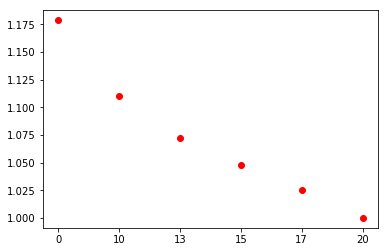

In [36]:
%matplotlib inline
# plt.plot(objs, "bo")
fig, ax= plt.subplots()
ax.plot(chis/chis.min(), "ro")
l = ax.xaxis.get_major_ticks()
l2 = ax.xaxis.set_ticklabels([None, 0, 10, 13, 15, 17,20])

In [44]:
dpath = scratch + '/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d/'%(bs, nc, seed, numd*1e4)
mm = 11
objs, chis, priors = [], [], []
sgs = [10, 13, 15, 17]
for sg in sgs:
    print(sg)
    dpath2 = dpath + 'opt_s999_MdowniM12-nas%02dfs1012tolsm3offsg15/'%sg
    data = mapp.Observable.load(dpath2 + '/datap')

    bfit = mapp.Observable.load(dpath2 + 'M0_11/%d-03-0.00/best-fit'%nc)
#     fit = mapp.Observable.load(dpath2 + 'fitp')
    
    noisefile = mpath + 'hist_M0%d_sg%d_na.txt'%(mm, sg)
    if not sg: noisefile = mpath + 'hist_M0%d_na.txt'%mm
    noise_model.create_off3d(data.mapp, noisefile, smooth=3)
    objb, chib, priorb = dgrep.smobj(pm, bfit, noise_model, data, pk, sml = 0.0, M0=M0, smooth=3, ftw=False, offset=True)
    objs.append(objb)
    chis.append(chib)
    priors.append(priorb)

objs  = np.array(objs)
chis  = np.array(chis)
priors = np.array(priors)

10
2D noise model
L2 norm objective
13
2D noise model
L2 norm objective
15
2D noise model
L2 norm objective
17
2D noise model
L2 norm objective


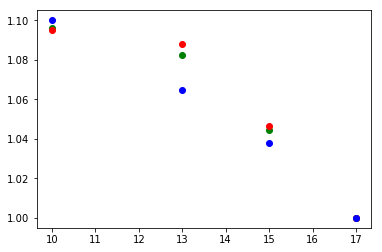

In [45]:
%matplotlib inline
# plt.plot(objs, "bo")
plt.plot(sgs, objs/objs.min(), "go")
plt.plot(sgs, chis/chis.min(), "ro")
plt.plot(sgs, priors/priors.min(), "bo")

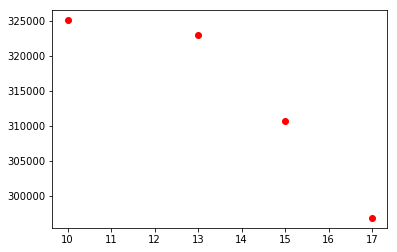

In [49]:
%matplotlib inline
# plt.plot(objs, "bo")
# plt.plot(sgs, objs, "go")
plt.plot(sgs, chis, "ro")
# plt.plot(sgs, priors, "bo")
# plt.yscale('log')

In [95]:
# dpath = scratch + '/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d/'%(bs, nc, seed, numd*1e4)
# mm = 11
# objs, chis, priors = [], [], []
# sgs = [10, 13, 15, 17]
# for sg in sgs:
#     print(sg)
#     dpath2 = dpath + 'opt_s999_MdowniM12-nas%02dfs1012tolsm3offsg15/'%sg
#     data = mapp.Observable.load(dpath2 + '/datap')

#     bfit = mapp.Observable.load(dpath2 + 'M0_11/%d-03-0.00/best-fit'%nc)
# #     fit = mapp.Observable.load(dpath2 + 'fitp')
    
#     noisefile = mpath + 'hist_M0%d_sg%d_na.txt'%(mm, sg)
#     if not sg: noisefile = mpath + 'hist_M0%d_na.txt'%mm
#     noise_model.create_off3d(data.mapp, noisefile, smooth=3)
#     objb, chib, priorb = dgrep.smobj(pm, bfit, noise_model, data, pk, sml = 0.0, M0=M0, smooth=3, ftw=False, offset=True)
#     objs.append(objb)
#     chis.append(chib)
#     priors.append(priorb)

# objs  = np.array(objs)
# chis  = np.array(chis)
# priors = np.array(priors)

In [50]:
dpath2 = dpath + 'opt_s999_MdowniM12-nas%02dfs1012tolsm3offsg15/'%13
data = mapp.Observable.load(dpath2 + '/datap')

dpath2 = dpath + 'opt_s999_MdowniM12-nas%02dfs1012tolsm3offsg15/'%15
data2 = mapp.Observable.load(dpath2 + '/datap')


In [55]:
10**5

100000

In [56]:
10**5.5

316227.7660168379

In [61]:
tmp = 1e10
# tmp = tmp**0.5
'%02d'%(10*np.log10(tmp))

'100'

# Stellar debug

In [12]:
def stellar_mass(hmass):
    '''Stellar to halo mass relationship taken from Moster et.al                                                                                                         
    http://iopscience.iop.org/article/10.1088/0004-637X/710/2/903/pdf                                                                                                    
    Eq. 2, values from Table 1                                                                                                                                           
                                                                                                                                                                         
    '''
    lm1 = 11.884
    m1 = 10**lm1
    m0 = 0.02820
    b = 1.057
    g = 0.556
    smass = 2*hmass*m0* ((hmass/m1)**-b + (hmass/m1)**g)**-1
    return smass




In [958]:
bs, nc, numd, seed = 400, 128, 1e-3, 100
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d'%(bs, nc, seed, numd*1e4)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)

import yaml
with open(scratch + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

train = '/global/cscratch1/sd/chmodi/cosmo4d/train/'

ptpath = train + cfg['%s-%s'%(bs,nc)][0][numd]['ppath']
mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpath']
# mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpathnf']
ptup, pftname, plocal, pdict = ntools.setuppos2(ptpath)
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1, R2 = pdict['R1'], pdict['R2']

num = int(numd*bs**3)
meshdict, hdict = ntools.readfiles(pm, scratch + '/data/L%04d_N%04d_S%04d_05step/'%(bs, nc, seed), R1=R1, R2=R2, mexp=None)
hdictf = ntools.gridhalos(pm, scratch +'/data/L%04d_N%04d_S%04d_40step/'%(bs, 4*nc, seed), rank=num, 
                          R1=R1, R2=R2, pmesh=True, mexp=None)

datapt = pm.create(mode='real', zeros=True)
datapt[...] = hdictf[0]['halomesh']

# datapt = pm.paint(hdictf['position'][:int(numd*bs**3)], hdictf['mass'][:int(numd*bs**3)])


ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)

mftt = ntools.createdata(pm, meshdict, mftname, mlocal)

nnpred = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
nnmass = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)
##
predict = pm.create(mode ='real')
predict[...] = nnpred*nnmass
predictsm = ft.smooth(predict, 3, 'fingauss')

predictr = pm.create(mode ='real')
predictr[...] = nnpred*ntools.relu(nnmass)


Network architecture for position: 30, relu; 10, relu; 1, sigmoid; 
Width of sigmoid is =  3
Position features are  ['final', 'R1', 'R12']
Network architecture for position: 10, elu; 5, elu; 1, linear; 
Match abundance
Match abundance


In [464]:
mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpathnf']
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1, R2 = pdict['R1'], pdict['R2']

num = int(numd*bs**3)
meshdict, hdict = ntools.readfiles(pm, scratch + '/data/L%04d_N%04d_S%04d_05step/'%(bs, nc, seed), R1=R1, R2=R2, mexp=None)
mftt = ntools.createdata(pm, meshdict, mftname, mlocal)
nnmassnf = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)
##
predictnf = pm.create(mode ='real')
predictnf[...] = nnpred*nnmassnf
predictrnf = pm.create(mode ='real')
predictrnf[...] = nnpred*ntools.relu(nnmassnf)


Network architecture for position: 20, elu; 10, elu; 1, linear; 
Match abundance


In [959]:
# path1 = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/smass/opt_s999_iM100_20v-wtsm3/'
path1 = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM98_100vsm3off/'
path2 = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/opt_s999_iM12_02vsm3off/'
datap = loadmap(path1+'/datap', 'mapp')
datad = loadmap(path1+'/datap', 'd')
fitp = loadmap(path1+'/fitp', 'mapp')
datap2 = loadmap(path2+'/datap', 'mapp')
fitp2 = loadmap(path2+'/fitp', 'mapp')
datad2 = loadmap(path2+'/datap', 'd')
fof = BigFileCatalog(path1+'/FOFd/', header='Header')
fof2 = BigFileCatalog(path2+'/FOFd/', header='Header')
fof2all = BigFileCatalog(path2+'/FOFall/', header='Header')

In [960]:
datapv = datap[...]
datapv2 = datap2[...]
datapsm = ft.smooth(datap, 3, 'fingauss')
fitpsm = ft.smooth(fitp, 3, 'fingauss')
datapsm2 = ft.smooth(datap2, 3, 'fingauss')
fitpsm2 = ft.smooth(fitp2, 3, 'fingauss')


In [710]:
(datapsm[...] > 10**9.8).sum()/nc**3, (datapsm[...] > 10**8.5).sum()/nc**3


(0.24335622787475586, 0.7704310417175293)

In [711]:
(datapsm2[...] > 10**12).sum()/nc**3, (datapsm2[...] > 10**11).sum()/nc**3


(0.17759227752685547, 0.60194110870361328)

In [712]:
mexp =0.5
glim = (np.logspace(1, 4, 8)*1e8)**mexp
# glim = (np.array([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])*1e6)**mexp
print('For test')
mhd = datap
mnd = fitp
for l in glim:
    print('    Above l=%0.2e, data = %d, predict = %d'%(l, (mhd[...]>l).sum(), (mnd[...]>l).sum()))
print('    Total, data = %0.3e, predict = %0.3e'%((mhd[...]).sum(), (mnd[...]).sum()))



For test
    Above l=3.16e+04, data = 366513, predict = 366014
    Above l=5.18e+04, data = 366508, predict = 357573
    Above l=8.48e+04, data = 366501, predict = 349553
    Above l=1.39e+05, data = 366495, predict = 341618
    Above l=2.28e+05, data = 366471, predict = 333830
    Above l=3.73e+05, data = 366446, predict = 326049
    Above l=6.11e+05, data = 366409, predict = 318197
    Above l=1.00e+06, data = 366337, predict = 310391
    Total, data = 1.037e+16, predict = 1.821e+16


In [713]:
(datapsm[...] > 1e4).sum()/nc**3

0.99979209899902344

In [714]:
mexp =1
glim = (np.logspace(1, 6, 12)*1e8)**mexp
# glim = (np.array([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])*1e6)**mexp
print('For test')
mhd = datap2
mnd = fitp2
for l in glim:
    print('    Above l=%0.2e, data = %d, predict = %d'%(l, (mhd[...]>l).sum(), (mnd[...]>l).sum()))
print('    Total, data = %0.3e, predict = %0.3e'%((mhd[...]).sum(), (mnd[...]).sum()))



For test
    Above l=1.00e+09, data = 364955, predict = 253857
    Above l=2.85e+09, data = 362944, predict = 243716
    Above l=8.11e+09, data = 358515, predict = 236769
    Above l=2.31e+10, data = 349214, predict = 230319
    Above l=6.58e+10, data = 330973, predict = 223934
    Above l=1.87e+11, data = 296941, predict = 217372
    Above l=5.34e+11, data = 240087, predict = 208588
    Above l=1.52e+12, data = 159578, predict = 177745
    Above l=4.33e+12, data = 75389, predict = 70372
    Above l=1.23e+13, data = 24891, predict = 25639
    Above l=3.51e+13, data = 6021, predict = 6342
    Above l=1.00e+14, data = 1044, predict = 673
    Total, data = 1.506e+18, predict = 1.414e+18


In [715]:
datapsm[...].max()/datap[...].max()

0.15934715865203533

/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:366: RuntimeWarning: invalid value encountered in true_divide
  cross = FFTPower(hfield/hfield.cmean(), second = pfield/pfield.cmean(), mode = '1d').power
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:367: RuntimeWarning: invalid value encountered in true_divide
  k, crossp = cross['k'], cross['power']
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:372: RuntimeWarning: invalid value encountered in true_divide
  cstyle[i,:] = cmap(i)


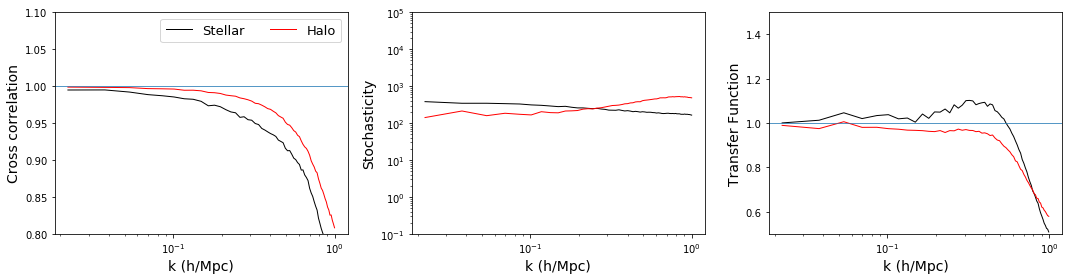

In [716]:
fig, ax = dg.plot_2pt(datap, fitp, label='Stellar')
dg.plot_2pt(datap2, fitp2, axin=ax, color='r', label='Halo')

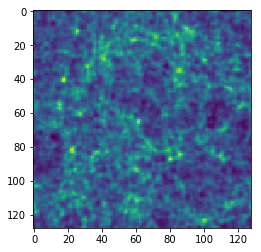

In [717]:
plt.imshow((fitpsm - datapsm)[...].sum(axis=0))

In [718]:
mm = 10**10.
print((datap[...] > mm).sum()/nc**3, (datapsm[...] > mm).sum()/nc**3)
# print('%0.2e'%mm**2)
mm2 = 1e12
print((datap2[...] > mm2).sum()/nc**3, (datapsm2[...] > mm2).sum()/nc**3)

0.0992980003357 0.152088165283
0.0925631523132 0.177592277527


In [719]:
for i in np.logspace(8, 10, 6):
    print(np.log10(i), (datap[...] > i).sum()/nc**3, (datapsm[...] > i).sum()/nc**3)
    

8.0 0.171090602875 0.871866703033
8.4 0.167497158051 0.794901847839
8.8 0.160801410675 0.68275976181
9.2 0.148963928223 0.530178070068
9.6 0.129203796387 0.342249393463
10.0 0.0992980003357 0.152088165283


In [720]:
for i in np.logspace(8, 12, 5):
    print(np.log10(i), (datapsm2[...] > i).sum()/nc**3)

8.0 0.991483211517
9.0 0.96231508255
10.0 0.863797187805
11.0 0.601941108704
12.0 0.177592277527


In [721]:
mexp = 1
M0 = 1e8**mexp
respsm = (fitpsm - datapsm)/M0

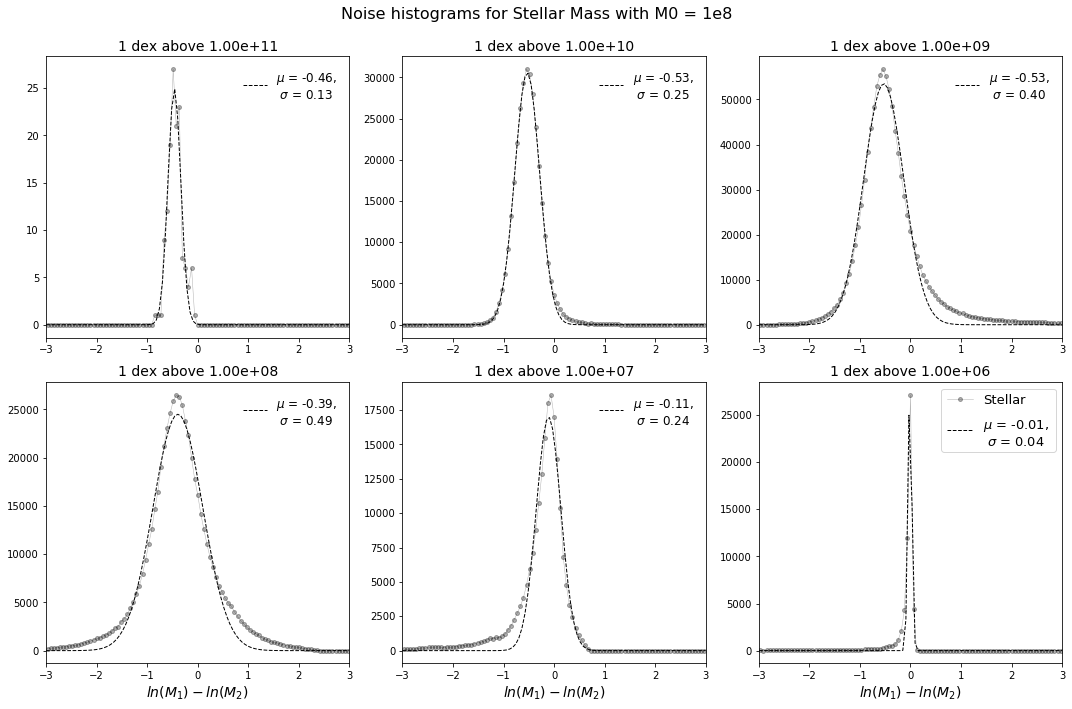

In [722]:
M0 = 1e8**mexp
mbinsm = (np.logspace(6, 11, 6)[::-1])**mexp
bins= np.linspace(-3, 3, 100)
fig, ax = dg.plot_noise(datapsm, fitpsm, M0, mbin=mbinsm, func=dg.normal, label='Stellar', binfit=bins)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Noise histograms for Stellar Mass with M0 = 1e8', fontsize=16)
# dg.plot_noise(datapsm2, fitpsm2, M0, mbin=mbinsm, func=dg.normal, axin=ax, c='r', label='Halo')

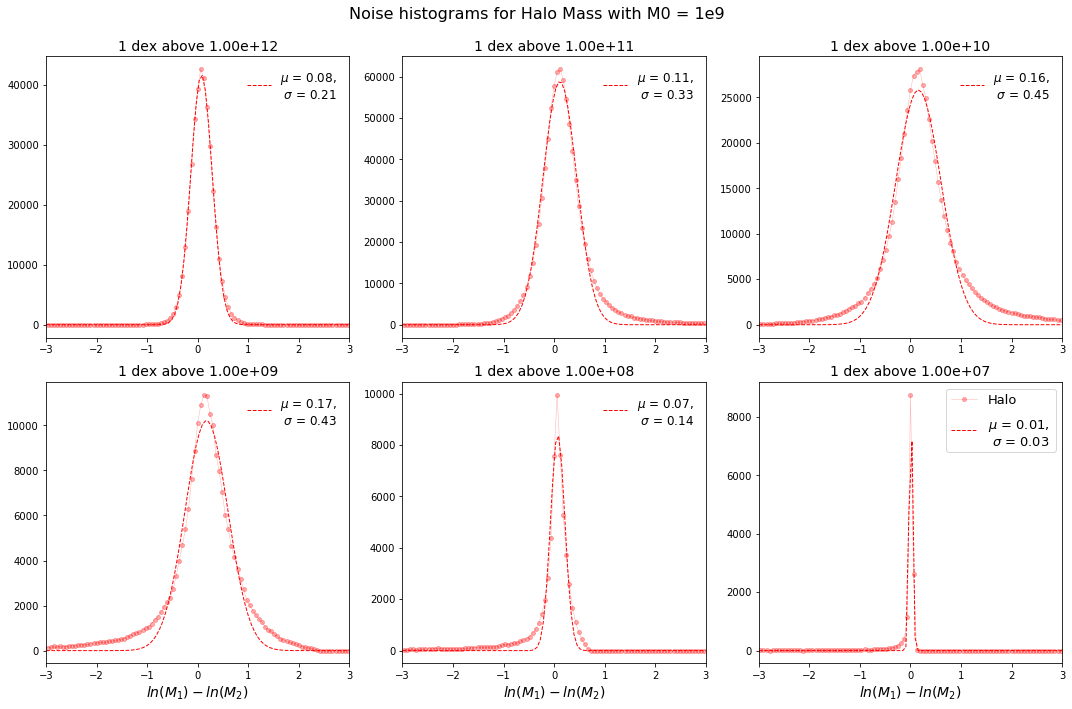

In [723]:
M0 = 1e9**mexp
mbinsm = (np.logspace(7, 12, 6)[::-1])**mexp
bins= np.linspace(-3, 3, 100)
fig, ax = dg.plot_noise(datapsm2, fitpsm2, M0, mbin=mbinsm, func=dg.normal, label='Halo', binfit=bins, c='r')
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Noise histograms for Halo Mass with M0 = 1e9', fontsize=16)
# dg.plot_noise(datapsm2, fitpsm2, M0, mbin=mbinsm, func=dg.normal, axin=ax, c='r', label='Halo')

 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b2fcb0c2048>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x2b2fce2e8b00>]], dtype=object)]

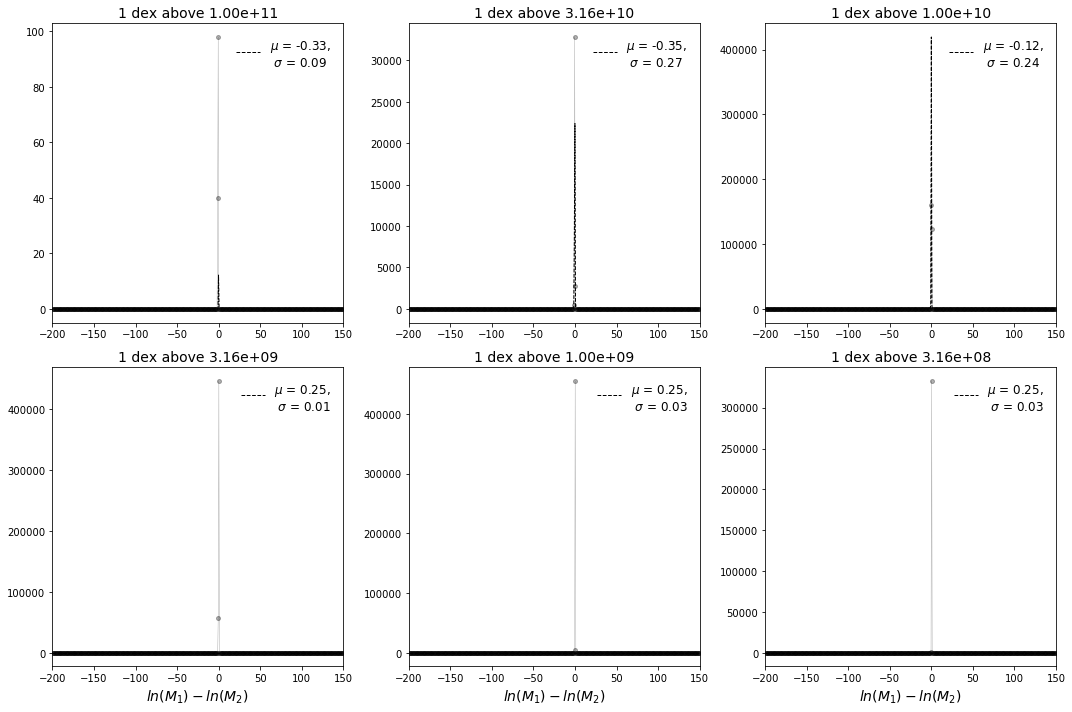

In [961]:
M0 = 1e11
mbinsm = np.logspace(7, 11, 9)[::-1]**mexp
bins = np.linspace(-200, 150, 500)
dg.plot_mnoise(datapsm, fitpsm, M0, mbin=mbinsm, func=dg.normal, binfit=bins)

In [969]:
importlib.reload(dg)

<module 'diagnostic' from '/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py'>

In [ ]:
M0 = 1e11
mbinsm = np.logspace(11, 13, 6)[::-1]
bins = np.linspace(-200, 200, 1000)
binfit = np.zeros((mbinsm.size, 1000 ))
for i in range(0, binfit.shape[0]):
    binfit[i] = np.linspace(-2*mbinsm[i]/M0, 2*mbinsm[i]/M0, binfit.shape[1])
fig, ax = dg.plot_mnoise(datapsm2, fitpsm2, M0, mbin=mbinsm, func=dg.normal, binfit=binfit)
fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.suptitle('Noise histograms for L2 error %s error for M0 = %0.2e\n \
    (note, x-axis is different in subplots)'%(r'$\frac{M_1-M_2}{M_0}$',M0), fontsize=14)
# fig.savefig('./figs/L2noise.pdf')

In [727]:
# plt.plot(fof['Mass'].compute()*1e10/1e3, datad.readout(fof2['PeakPosition']), ".", ms=1)
# plt.plot(fof['Mstellar'].compute()*1e10, datad.readout(fof2['PeakPosition']), ".", ms=1)
# plt.xscale('log')

##### use position mask

In [728]:
posmask = pm.paint(fof2['PeakPosition'].compute())
posmask[...][posmask[...]==0] = 1

In [729]:
fhalo = pm.create(mode='real', zeros=True)
# fhalo[...] = stellar_mass(predictr[...]/posmask)*posmask
fhalo[...] = (predictr[...]/posmask)**mexp*posmask
fhalosm = ft.smooth(fhalo, 3, 'fingauss')

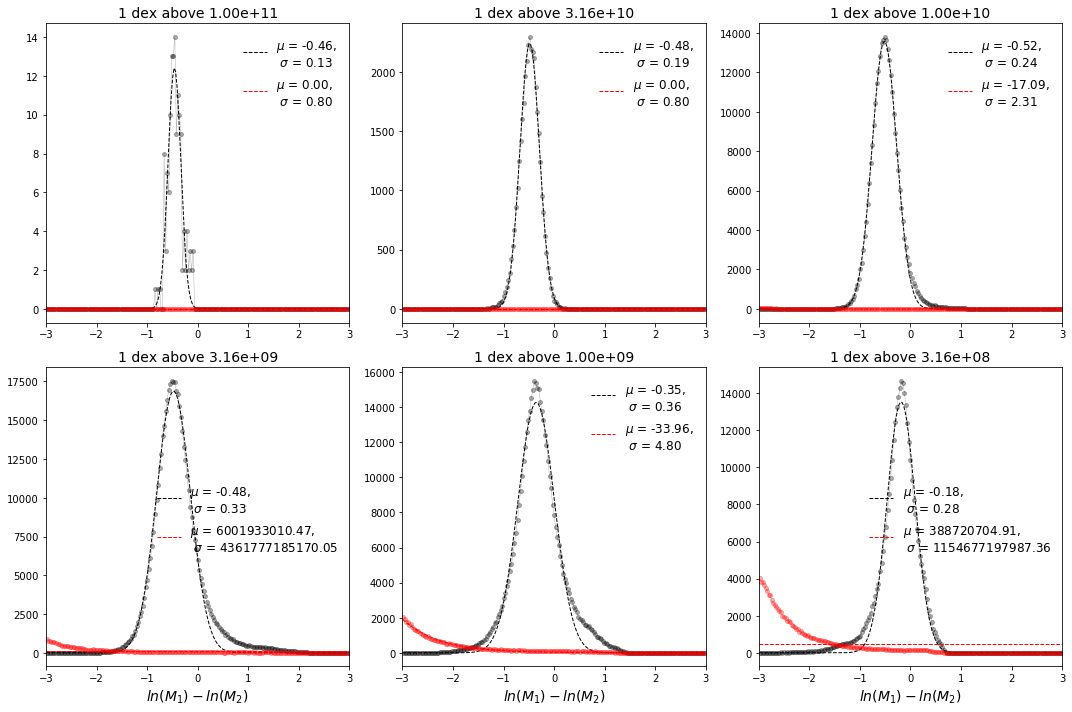

In [730]:
M0 = 1e9 **mexp
mbinsm = np.logspace(6, 11, 11)[::-1]**mexp
bins = np.linspace(-3, 3, 200)
fig, ax = dg.plot_noise(datapsm, fitpsm, M0, mbin=mbinsm, func=dg.normal, binfit=bins)
dg.plot_noise(datapsm, fhalosm, M0, mbin=mbinsm, func=dg.normal, axin=ax, c='r', binfit=bins)

Moster et al for stellar to halo mass relation <br>
http://iopscience.iop.org/article/10.1088/0004-637X/710/2/903/pdf

In [731]:

hmass = fof2['AMass'].compute()*1e10
smass = stellar_mass(hmass)

In [732]:
nmf = mass_function.Num_Mass_Func(bs = 400, nc = 128, M = 0.3175)

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/mymass_function.py:320: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

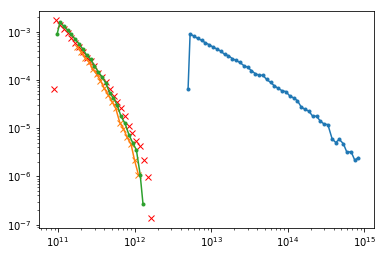

In [733]:
def fmexp(hmass, exp=None, cc=None):
# def fmexp(hmass, exp=0.45, cc=5.27):
# def fmexp(hmass, exp=0.8, cc=1.5):
    if exp is None: exp = 0.5
    if cc is None: cc = 4.6
    return 10**cc*hmass**exp

alpha, cc = None, None

nh, dummy, mh = nmf.calc_array(hmass, 11, 15, 0.05)
ns, dummy, ms = nmf.calc_array(smass, 9, 13, 0.05)

nh2, dummy, mh2 = nmf.calc_array(fmexp(hmass, alpha, cc), 9, 15, 0.05)
nh3, dummy, mh3 = nmf.calc_array( hmass**0.45, 6, 13, 0.05)
# plt.plot(hmass)
# shm(hmass)

plt.plot(mh, nh, marker=".")
plt.plot(mh2, nh2, "rx")
plt.plot(mh3*10**5.23, nh3, marker="x")
plt.plot(ms, ns, marker=".")
plt.loglog()

0.9 0.5
0.8 1.5
0.7 2.0
0.5 4.6


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/mymass_function.py:320: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


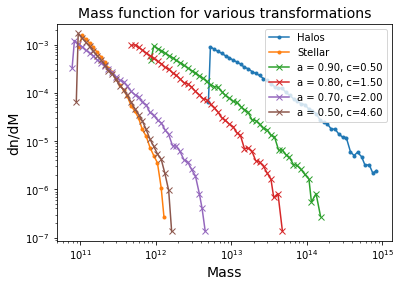

In [734]:
def fmexp(hmass, exp=None, cc=None):
# def fmexp(hmass, exp=0.45, cc=5.27):
# def fmexp(hmass, exp=0.8, cc=1.5):
    if exp is None: exp = 0.5
    if cc is None: cc = 4.6
    return 10**cc*hmass**exp

alpha, cc = None, None


plt.figure(figsize=(6, 4))
nh, dummy, mh = nmf.calc_array(hmass, 11, 15, 0.05)
ns, dummy, ms = nmf.calc_array(smass, 9, 13, 0.05)
plt.plot(mh, nh, marker=".", label='Halos')
plt.plot(ms, ns, marker=".", label='Stellar')

for alpha, cc in [[0.9, 0.5], [0.8, 1.5], [0.7, 2.0], [0.5, 4.6]]:
    print(alpha, cc)
    nh2, dummy, mh2 = nmf.calc_array(fmexp(hmass, alpha, cc), 9, 15, 0.05)
    plt.plot(mh2, nh2, marker="x", label='a = %0.2f, c=%0.2f'%(alpha, cc))
# plt.plot(hmass)
# shm(hmass)
plt.legend()
plt.loglog()
plt.xlabel('Mass', fontsize=14)
plt.ylabel('dn/dM', fontsize=14)
plt.title("Mass function for various transformations", fontsize=14)
# plt.savefig('./figs/mexp_transform.pdf')

In [735]:

datat = pm.create(mode='real', zeros=True)
datat = pm.paint(fof2['PeakPosition'], fmexp(fof2['AMass'].compute()*1e10, alpha, cc))

datap2c = pm.create(mode='real', zeros=True)
datap2c[...] = datap2[...]
datap2c[...] /= posmask
datap2c[...] = fmexp(datap2c, alpha, cc)
datap2c[...] = datap2c[...]*posmask

pred2 = pm.create(mode='real', zeros=True)
pred2[...] = ntools.relu(nnmass)
pred2[...] /= posmask
pred2[...] = fmexp(pred2, alpha, cc)
pred2[...] = pred2[...]*posmask*nnpred

pred3 = pm.create(mode='real', zeros=True)
pred3[...] = nnpred * ntools.relu(nnmass)
pred3[...] /= posmask
pred3[...] = fmexp(pred3, alpha, cc)
pred3[...] = pred3[...]*posmask

pred4 = pm.create(mode='real', zeros=True)
pred4[...] = nnpred * ntools.relu(nnmass)
pred4[...] = fmexp(pred4, alpha, cc)

pred5 = pm.create(mode='real', zeros=True)
pred5[...] = ntools.relu(nnmass)
pred5[...] = fmexp(pred5, alpha, cc)*nnpred

pred6 = pm.create(mode='real', zeros=True)
pred6[...] = (1+ ntools.relu(nnmass))
pred6[...] = fmexp(pred6, alpha, cc)*nnpred


pred4nf = pm.create(mode='real', zeros=True)
pred4nf[...] = nnpred * ntools.relu(nnmassnf)
pred4nf[...] = fmexp(pred4nf, alpha, cc)



In [736]:
(ntools.relu(nnmass) == 0 ).sum()/nc**3

0.20479679107666016

/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:396: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:397: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:402: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)


(0.9, 1.05)

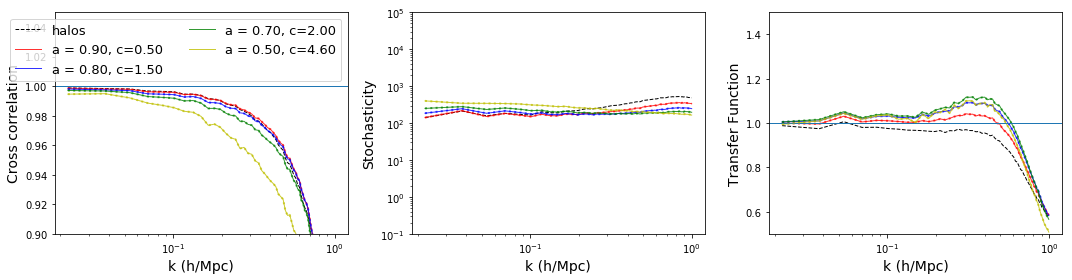

In [1090]:
# fig, ax = dg.plot_2pt(datat, datap2, label='halo')
# dg.plot_2pt(datat, datap2c, axin=ax, color='r', label='hs-posmask')
fig, ax = dg.plot_2pt(datap2, predictr, color='k', ls ="--", label='halos')

i=0
for alpha, cc in [[0.9, 0.5], [0.8, 1.5], [0.7, 2.0], [0.5, 4.6]]:
    datat = pm.paint(fof2['PeakPosition'], fmexp(fof2['AMass'].compute()*1e10, alpha, cc))
    pred4 = pm.create(mode='real', zeros=True)
#     pred4[...] = fmexp(nnpred * ntools.relu(nnmass), alpha, cc)
#     dg.plot_2pt(datat, pred4, axin=ax, color=colors[i], ls ="--", label='a = %0.2f, c=%0.2f'%(alpha, cc), lw=2, alpha=1)
    pred4[...] = nnpred *fmexp( ntools.relu(nnmass), alpha, cc)
    dg.plot_2pt(datat, pred4, axin=ax, color=colors[i], ls ="-", label='a = %0.2f, c=%0.2f'%(alpha, cc), lw=1, alpha=0.8)
    pred4[...] = nnpred *fmexp(1e7+ ntools.relu(nnmass), alpha, cc)
    dg.plot_2pt(datat, pred4, axin=ax, color=colors[i], ls =":", lw=2, alpha=0.7)
    i+=1

ax[0].set_ylim(0.9, 1.05)
# # dg.plot_2pt(datat, pred2, axin=ax, color='b', ls ="-", label='spred2', lw=2)
# # dg.plot_2pt(datat, pred3, axin=ax, color='c', ls =":", label='spred3', lw=3, alpha=0.7)
# dg.plot_2pt(datat, pred4, axin=ax, color='orange', ls ="--", label='spred4', lw=3, alpha=0.7)
# # dg.plot_2pt(datat, pred4nf, axin=ax, color='m', ls =":", label='spred4nf', lw=3, alpha=0.7)
# dg.plot_2pt(datat, pred5, axin=ax, color='g', ls ="-.", label='spred5', lw=2, alpha=0.7)
# dg.plot_2pt(datat, pred6, axin=ax, color='r', ls =":", label='spred6', lw=2, alpha=0.7)


In [433]:
R0 = 3
datatsm = ft.smooth(datat, R0, 'fingauss')
pred4sm = ft.smooth(pred4, R0, 'fingauss')
pred3sm = ft.smooth(pred3, R0, 'fingauss')
pred5sm = ft.smooth(pred5, R0, 'fingauss')

In [434]:
hmsg1, hpsg1 = dg.scatter_catalog(fmexp(fof2['AMass'].compute()*1e10), fof2['PeakPosition'].compute(), 0.2)
datatsg = pm.paint(hpsg1, hmsg1)
datatsgsm = ft.smooth(datatsg, 3, 'fingauss')

In [435]:
# M0 = 1e9 **mexp
# mbinsm = np.logspace(8, 12.5, 6)[::-1]**mexp
# bins = np.linspace(-3, 3, 200)
# fig, ax = dg.plot_noise(datapsm2, fitpsm2, M0, mbin=mbinsm, func=dg.normal, binfit=bins, normed=False)

# # mbinsm = np.logspace(6, 11, 6)[::-1]**mexp
# # bins = np.linspace(-3, 3, 200)
# # dg.plot_noise(datatsm, pred4sm, M0, mbin=mbinsm, func=dg.normal, axin=ax, c='r', binfit=bins, normed=True)

In [442]:
M0 = 10**9.2
(datatsm[...] > M0).sum()/nc**3

0.53017807006835938

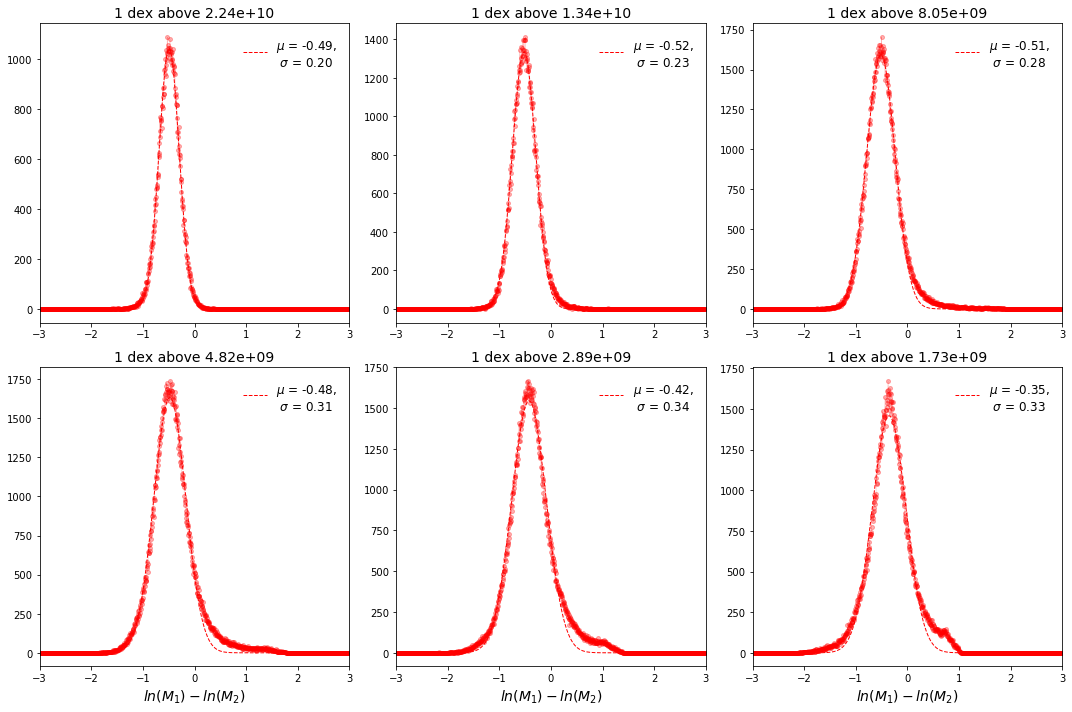

In [443]:

# mbinsm = np.logspace(5, 10, 6)[::-1]
mbinsm = 10**np.linspace(7.5, 11.5, 10)[::-1]
mbinsm = fmexp(mbinsm)
bins = np.linspace(-3, 3, 1000)
fig, ax= dg.plot_noise(datatsm, pred4sm, M0, mbin=mbinsm, func=dg.normal, c='r', binfit=bins)

# dg.plot_noise(datatsm, pred3sm, M0, mbin=mbinsm, func=dg.normal, c='b', binfit=bins, axin=ax)
# dg.plot_noise(datatsm, pred5sm, M0, mbin=mbinsm, func=dg.normal, c='g', binfit=bins, axin=ax)

# dg.plot_noise(datatsgsm, pred4sm, M0, mbin=mbinsm, func=dg.normal, c='b', binfit=bins, axin=ax)
# fig, ax= dg.plot_noise(datat, pred4, M0, mbin=mbinsm, func=dg.normal, c='r', binfit=bins)
# dg.plot_noise(datatsgsm, pred4, M0, mbin=mbinsm, func=dg.normal, c='b', binfit=bins, axin=ax)

In [444]:

glim = (np.logspace(1, 7, 12)*1e6)**mexp
# glim = (np.array([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])*1e6)**mexp
print('For test')
mhd = datat
mnd = pred4
for l in glim:
    print('    Above l=%0.2e, data = %d, predict = %d'%(l, (mhd[...]>l).sum(), (mnd[...]>l).sum()))
print('    Total, data = %0.3e, predict = %0.3e'%((mhd[...]).sum(), (mnd[...]).sum()))



For test
    Above l=1.00e+07, data = 365266, predict = 403169
    Above l=3.51e+07, data = 363082, predict = 361806
    Above l=1.23e+08, data = 357468, predict = 322477
    Above l=4.33e+08, data = 343964, predict = 284041
    Above l=1.52e+09, data = 313847, predict = 249934
    Above l=5.34e+09, data = 253424, predict = 232236
    Above l=1.87e+10, data = 153931, predict = 216489
    Above l=6.58e+10, data = 43061, predict = 112703
    Above l=2.31e+11, data = 2166, predict = 6741
    Above l=8.11e+11, data = 2, predict = 0
    Above l=2.85e+12, data = 0, predict = 0
    Above l=1.00e+13, data = 0, predict = 0
    Total, data = 1.037e+16, predict = 1.859e+16


### Verify

In [415]:

bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/Mexp70/opt_s999_iM100_10vsm3/'
t1 = BigFileMesh(bpath + '/datap/', 'mapp').paint()
t1d = BigFileMesh(bpath + '/datap/', 'd').paint()
t2 = BigFileMesh(bpath + '/fitp/', 'mapp').paint()


In [416]:
alpha, cc = 0.7, 2
tmp = pm.paint(fof2['PeakPosition'], fmexp(fof2['AMass'].compute()*1e10, alpha, cc))


meshdict = ntools.smoothft(t1d, R1=R1, R2=R2)
ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)
mftt = ntools.createdata(pm, meshdict, mftname, mlocal)
nnpredtmp = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
nnmasstmp = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)

tmp2 = pm.create(mode='real', zeros=True)
tmp2[...] = nnpredtmp* fmexp(ntools.relu(nnmasstmp), alpha, cc)

In [417]:
t1[...].max()/1e15, tmp[...].max()/1e15

(0.0023239290075852291, 0.0023239290075852221)

In [418]:
t2[...].max()/1e15, tmp2[...].max()/1e15

(0.0014089042388562097, 0.0014089042388562116)

In [419]:
R0 = 3
t1sm = ft.smooth(t1, 3, 'fingauss')
tmpsm = ft.smooth(tmp, 3, 'fingauss')
t2sm = ft.smooth(t2, 3, 'fingauss')
tmp2sm = ft.smooth(tmp2, 3, 'fingauss')


In [420]:
mm = 1e12
(t1[...] > mm).sum()/nc**3, (tmp[...] > mm).sum()/nc**3


(5.626678466796875e-05, 5.626678466796875e-05)

In [421]:
mm = 1e12
(t2[...] > mm).sum()/nc**3, (tmp2[...] > mm).sum()/nc**3

(3.1948089599609375e-05, 3.1948089599609375e-05)

In [422]:
abs(t1  - tmp).csum()

81.716804689287756

In [423]:
abs(t2  - tmp2).csum()/1e10, abs(t2  - tmp2)[...].max()/1e10 

(1997.7446762902464, 5.1262310404568714)

In [424]:
t2[...].flatten()[np.argmax(abs(t2  - tmp2)[...])], tmp2[...].flatten()[np.argmax(abs(t2  - tmp2)[...])]

(103771339.32547715, 51366081743.894188)

/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:366: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:367: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:372: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axe

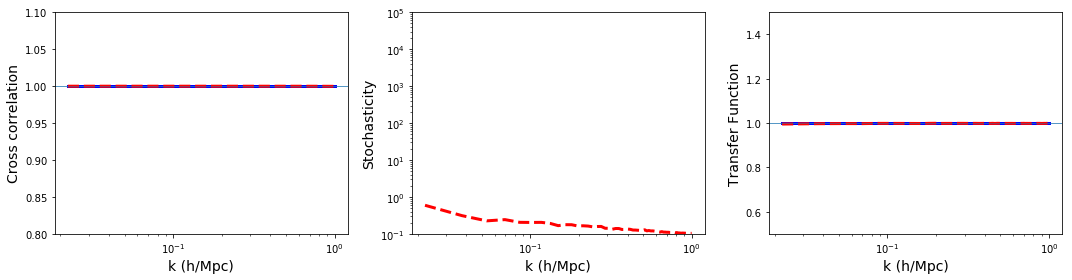

In [512]:
fig, ax = dg.plot_2pt(t1, tmp, lw=3, color='b')
dg.plot_2pt(t2, tmp2, lw=3, color='r', axin=ax, ls="--")



### Other loss functions

In [553]:
M0 = 1e10
R0 = 3
datapsm2m = ft.smooth(datap2 + M0, R0, 'fingauss')
predictsmm = ft.smooth(predict + M0, R0, 'fingauss')


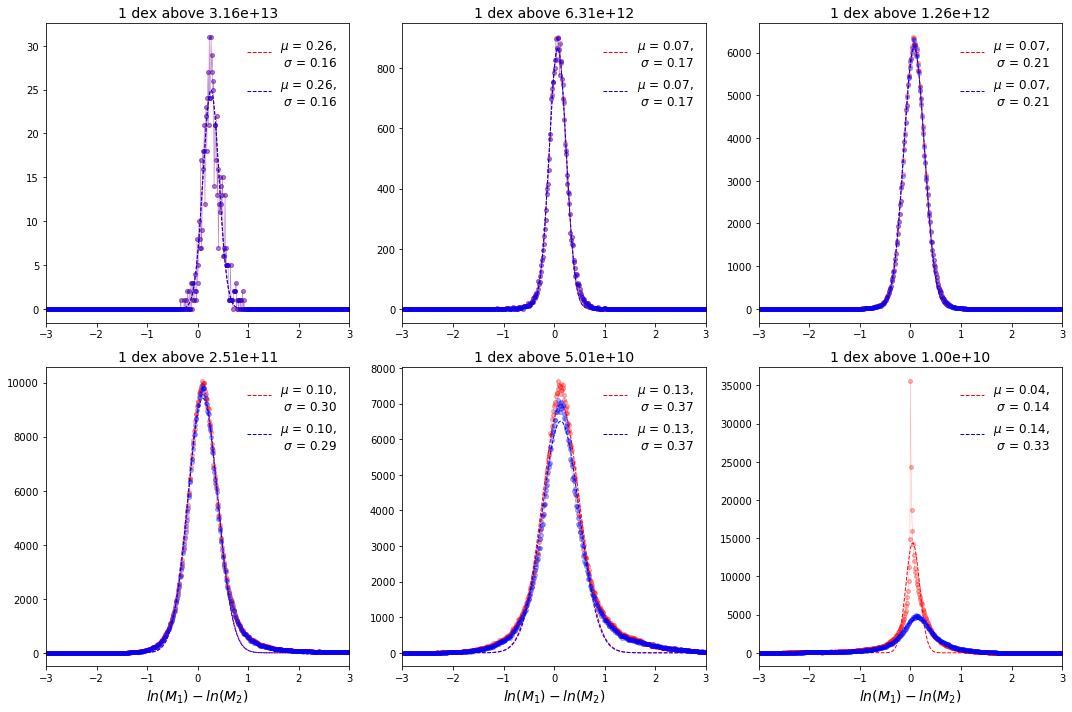

In [554]:
mbinsm = np.logspace(np.log10(M0), 13.5, 6)[::-1]
bins = np.linspace(-3, 3, 500)
fig, ax = dg.plot_noise(datapsm2m, predictsmm, 0, c='r', mbin=mbinsm, binfit=bins, func=dg.normal)
dg.plot_noise(datapsm2, predictsm, M0, c='b', mbin=mbinsm, binfit=bins, func=dg.normal, axin=ax)

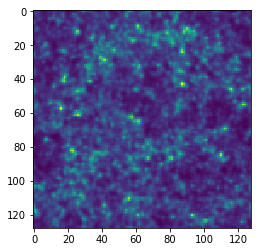

In [494]:
plt.imshow(datapsm2[...].sum(axis=0))

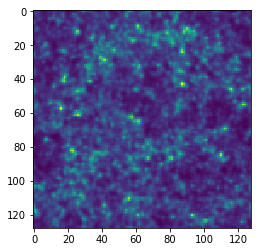

In [497]:
plt.imshow(datapsm2m[...].sum(axis=0))

In [863]:
importlib.reload(dg)

<module 'diagnostic' from '/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py'>

Kist type detected, assuming list of meshes to be combined


 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b2fc4e26400>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x2b2fc4f11748>]], dtype=object)]

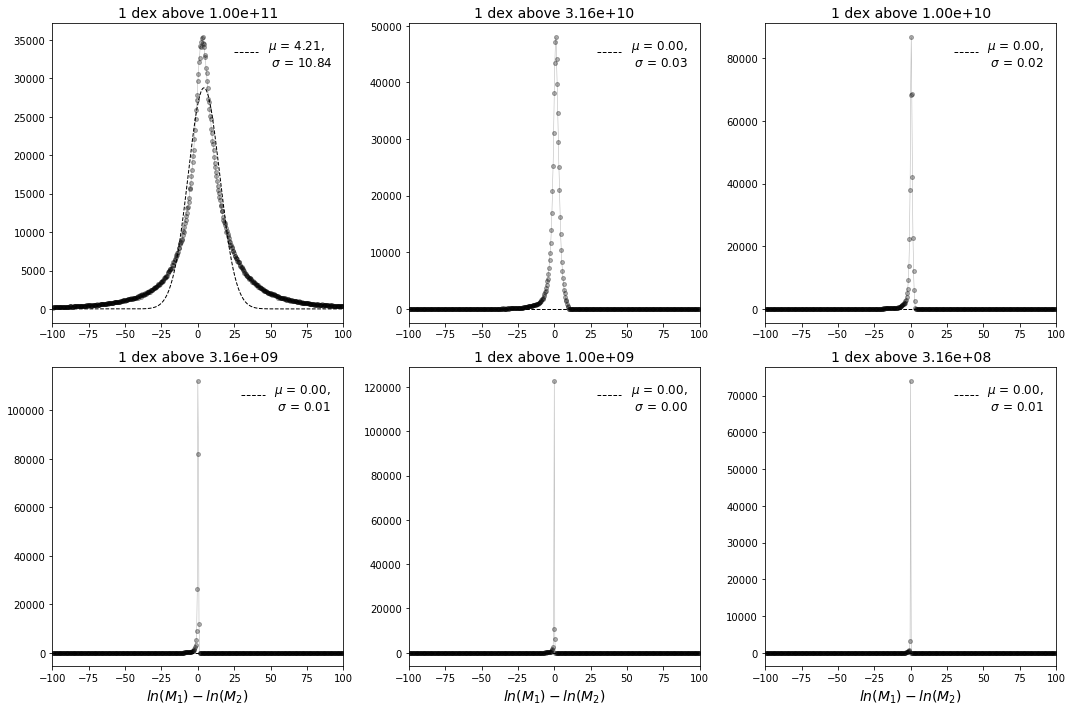

In [865]:
dg.plot_mnoise([datapsm2, datapsm2], [predictsm,predictsm], 1e10, func=dg.normal, mbin=mbinsm)

 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b2fc58a8ba8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x2b2fc4da3ba8>]], dtype=object)]

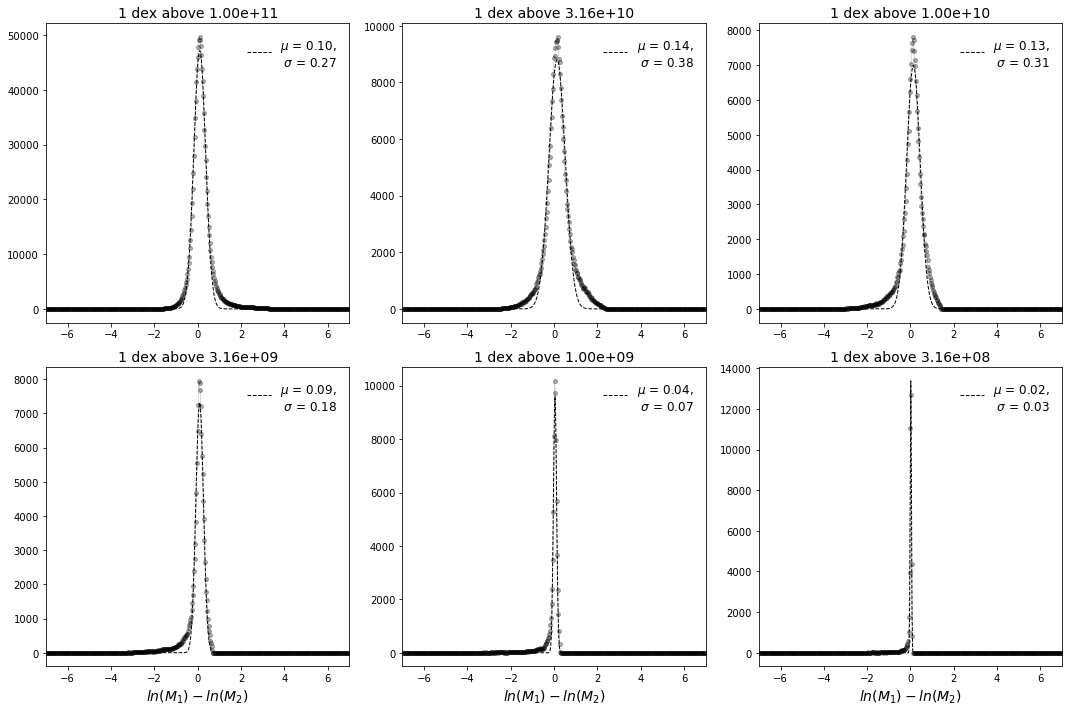

In [857]:
dg.plot_noise(datapsm2, predictsm, 1e10, func=dg.normal, mbin=mbinsm)

## Check Noise

In [67]:
tmp = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM92bf98_100vsm3n3d100voff/noise_M92/', 'ivar3d').paint()
tmp2 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM90bf98_200vf100vsm3n3d200voff/noise_M90', 'ivar3d').paint()
tmp3 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM90bf98_50vf100vsm3n3d50voff/noise_M90', 'ivar3d').paint()
tmpd = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM92bf98_100vsm3n3d100voff/datap//', 'mapp').paint()
tmpd3 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/Mexp50/opt_s999_iM90bf98_200vf100vsm3n3d200voff/datap//', 'mapp').paint()

# tmp3 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/opt_s999_iM11bf12_01vsm3n3d100voff/noise_M110/', 'ivar3d').paint()
# tmp4 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/nolog/opt_s999_iM11bf12_01vsm3n3d100voff/datap//', 'mapp').paint()

In [933]:
tmpf = np.loadtxt('/global/cscratch1/sd/chmodi/cosmo4d/train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/Mexp50/hist_M90_mass.txt').T
tmpf2 = np.loadtxt('/global/cscratch1/sd/chmodi/cosmo4d/train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/hist_M110_mass.txt').T

In [1032]:
tmp[...] = tmp[...]**-1
tmp2[...] = tmp2[...]**-1
tmp3[...] = tmp3[...]**-1


In [1033]:
np.unique(tmp3[...])

array([  5.00000000e-01,   7.68082323e-01,   1.80492201e+00,
         4.64237437e+00,   1.01343382e+01,   2.04128643e+01,
         3.82748861e+01,   6.13863480e+01,   1.11470657e+02,
         2.54014384e+02,   5.19015314e+02])

In [1034]:
np.unique(tmp2[...])

array([   0.76808232,    1.80492201,    2.        ,    4.64237437,
         10.1343382 ,   20.41286433,   38.27488606,   61.38634802,
        111.47065731,  254.01438367,  519.01531383])

In [1035]:
tmpd[(tmpd[...] > 0)]

array([  8.30251624e+10,   7.10432802e+10,   3.92397757e+09, ...,
         3.97523840e+10,   4.95127189e+10,   1.48346871e+10])

In [1040]:
tmpdsm = ft.smooth(tmpd, 3, 'fingauss')

In [1003]:
np.unique(tmp[...])

array([   0.56639514,    1.        ,    1.33224294,    2.91975621,
          5.54611083,   10.56290077,   17.57996742,   27.42424339,
         48.88251861,  105.0708273 ,  206.62371755])

In [909]:
(tmp[...]**0.5 <= 1.12).sum()/nc**3


0.50794792175292969

In [929]:
(tmp3[...]== 1).sum()/nc**3, (tmp[...]== 1).sum()/nc**3


(0.24000167846679688, 0.4242854118347168)

In [934]:
tmpf[0]/10**9

array([  7.07945784e+03,   7.07945784e+01,   4.32876128e+01,
         2.64683746e+01,   1.61841878e+01,   9.89588285e+00,
         6.05087501e+00,   3.69983041e+00,   2.26227530e+00,
         1.38327679e+00,   8.45809828e-01,   5.17173619e-01])

In [907]:
tmpm = 10**9.2
tmpf[-1]


array([ 14.3744119 ,  10.2504062 ,   6.99160344,   5.23681615,
         4.19284717,   3.25006166,   2.35501822,   1.70872941,
         1.15422829,   0.75259228,   0.510672  ,   0.3313909 ])

In [927]:
tmpf2[-1]

array([ 53.39068222,  27.53523715,  14.26238958,   7.3208506 ,
         3.90059789,   2.25575855,   1.30406062,   0.71009214,
         0.35972184,   0.17952428])

In [886]:
tmp[tmp2[...] < 10**9.2].max()

206.62371754894755

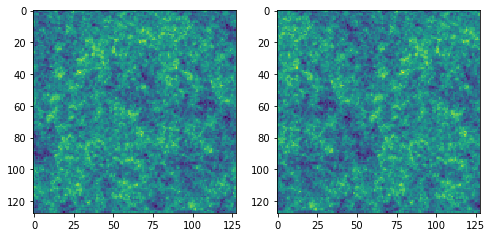

In [254]:
fig, ax = plt.subplots(1, 2, figsize =(8,4))
ax[0].imshow(tmp[...].sum(axis=0))
ax[1].imshow(np.roll(tmp[...], 50, axis=-1).sum(axis=0))
#You should not see a verticaal line when you roll?

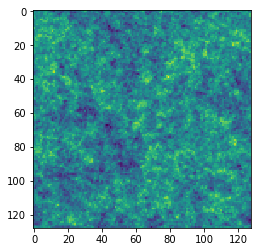

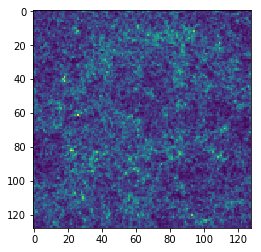

In [871]:
plt.imshow(tmp2[...].sum(axis=0))

In [56]:
from functools import partial
from scipy.optimize import minimize
from scipy.optimize import curve_fit as cf


In [ ]:
cf()

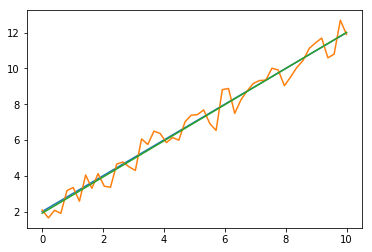

In [55]:
def line(x, a, b):
    return a*x + b

xxt = np.linspace(0, 10)
yyd = line(xxt, 1, 2)
yydn = yyd + np.random.normal(0, 0.5, xxt.size)
p0 = [3, 5]

def chi2(p, y, func, x):
    yp = func(x, *p)
    return np.sum((y - yp)**2)

chi2p = partial(chi2, y=yydn, func=line, x=xxt)
res = minimize(chi2p, p0, method='Nelder-Mead')

plt.plot(xxt, yyd)
plt.plot(xxt, yydn)
plt.plot(xxt, line(xxt, *res.x))


In [71]:
pk = FFTPower(tmp/tmp.cmean(), mode='1d').power

In [73]:
pk['modes']

array([    1,    26,    66,   158,   234,   410,   470,   738,   872,
        1164,  1406,  1578,  1970,  2366,  2538,  3074,  3306,  3932,
        4284,  4778,  5318,  5754,  6392,  6912,  7370,  8330,  8778,
        9686,  9858, 11162, 11358, 12770, 13162, 14194, 14910, 15848,
       16748, 17550, 18650, 19610, 20382, 21842, 22570, 24082, 24822,
       26120, 26740, 28462, 29522, 30882, 31946, 33638, 34456, 36268,
       36670, 39130, 39882, 41258, 43310, 44226, 46370, 47334, 48946, 51322])

In [60]:
xxtn = xxt.copy()
xxtn[3] =np.nan
np.isnan(xxtn)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [102]:
tmp =BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/data/L0400_N0128_S0100_40step/mesh/', 's').paint()

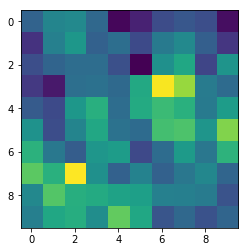

In [108]:
plt.imshow(tmp[:10, :10, 0])

In [ ]:
%matplotlib inline
colors = ['r', 'b', 'g', 'y', 'm', 'orange', 'brown', ]

fig, ax = plt.subplots(2, 3, figsize = (15, 8))

###down from M12

j=0
labels = ['400Mpc: No offset, Constant std', 'Mass Offset, Constant std', 'Mass Offset, Noise std']
for i, key in enumerate(skeys('400')):
    if key in skeys('na'):
        pass
    else:
        dgrep.summary(report[key], fig, ax, c=colors[i%7], lw=2, ls = '-', label=labels[j])
        j+=1
labels = ['500Mpc, n=1e-3', '500Mpc, n=5e-4']
j=0
for i, key in enumerate(skeys('500')):
    if key in skeys('na'):
        pass
    else:
        print(key)
        dgrep.summary(report[key], fig, ax, c=colors[(i)%7], lw=2, ls = '--', label=labels[i])
        j+=1

        
for axis in ax[0]:
    axis.set_ylim(0.5, 1.05)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')
for axis in ax[1]:
    axis.set_ylim(0.5, 1.2)
    axis.set_xlim(2e-2, 0.7)
    axis.axhline(1, lw=0.5, color ='k')

ax[0, 2].legend(loc=3)

fig.suptitle(r'Effect of adding offset in the Noise Model', fontsize =14)

# fig.savefig('./tfigs/offset.pdf')

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:170: RuntimeWarning: invalid value encountered in true_divide
  xm = xm['power'] / (pm1['power'] * pm2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:171: RuntimeWarning: invalid value encountered in true_divide
  xs = xs['power'] / (ps1['power'] * ps2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:172: RuntimeWarning: invalid value encountered in true_divide
  xd = xd['power'] / (pd1['power'] * pd2['power']) ** 0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:174: RuntimeWarning: invalid value encountered in true_divide
  tm = (pm1['power'] / pm2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:175: RuntimeWarning: invalid value encountered in true_divide
  ts = (ps1['power'] / ps2['power']) **0.5
/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/report.py:176: RuntimeWarning: invalid value encountered in true_divide
  td = (pd1['power']

5001m11
500m11


# Invert scatter

In [352]:
bs, nc, numd, seed = 400, 128, 1e-3, 100
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d'%(bs, nc, seed, numd*1e4)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)

import yaml
with open(scratch + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

train = '/global/cscratch1/sd/chmodi/cosmo4d/train/'

ptpath = train + cfg['%s-%s'%(bs,nc)][0][numd]['ppath']
mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpath']
# mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpathnf']
ptup, pftname, plocal, pdict = ntools.setuppos2(ptpath)
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1, R2 = pdict['R1'], pdict['R2']

num = int(numd*bs**3)
meshdict, hdict = ntools.readfiles(pm, scratch + '/data/L%04d_N%04d_S%04d_05step/'%(bs, nc, seed), R1=R1, R2=R2, mexp=None)
hdictf = ntools.gridhalos(pm, scratch +'/data/L%04d_N%04d_S%04d_40step/'%(bs, 4*nc, seed), rank=num, 
                          R1=R1, R2=R2, pmesh=True, mexp=None)

datapt = pm.create(mode='real', zeros=True)
datapt[...] = hdictf[0]['halomesh']
dataptsm = ft.smooth(datapt, 3, 'fingauss')
# datapt = pm.paint(hdictf['position'][:int(numd*bs**3)], hdictf['mass'][:int(numd*bs**3)])


ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)

mftt = ntools.createdata(pm, meshdict, mftname, mlocal)

nnpred = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
nnmass = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)
##
predict = pm.create(mode ='real')
predict[...] = nnpred*nnmass
predictsm = ft.smooth(predict, 3, 'fingauss')

predictr = pm.create(mode ='real')
predictr[...] = nnpred*ntools.relu(nnmass)


Network architecture for position: 30, relu; 10, relu; 1, sigmoid; 
Width of sigmoid is =  3
Position features are  ['final', 'R1', 'R12']
Network architecture for position: 10, elu; 5, elu; 1, linear; 
Match abundance
Match abundance


/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/mymass_function.py:320: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

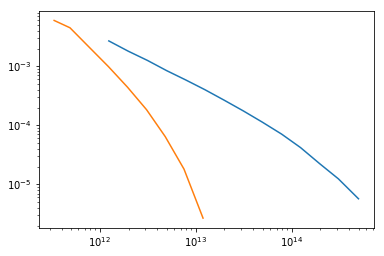

In [353]:
fof0 = BigFileCatalog('/global/cscratch1/sd/chmodi/cosmo4d/data/L0400_N0512_S0100_40step/FOF/', header='Header')[1:]

hmass = fof0['Mass'].compute()*1e10
mexp, cc = 0.5, 5.6
smass = mf.fmexp(hmass, mexp, cc)
nmf = mass_function.Num_Mass_Func(bs=400, nc=128, M=0.3175)

hmf, dummy, hmm = nmf.calc_array(hmass, 12, 15, 0.2)
smf, dummy, smm = nmf.calc_array(smass, 11, 13.5, 0.2)

plt.plot(hmm, hmf)
plt.plot(smm, smf)
plt.loglog()

[]

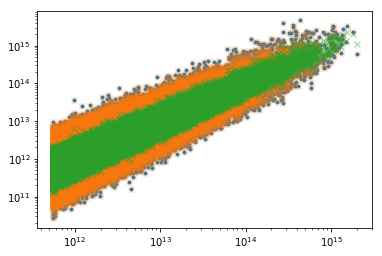

In [343]:
sg = 0.15
smasssg = dg.scatter_halos(smass, sg)
hmasssg = dg.scatter_halos(hmass, sg)
hmasssg2 = dg.scatter_halos(hmass, 2*sg)
hmass2 = (smasssg/10**cc)**(1/mexp) 

plt.plot(hmass, hmass2, '.')
plt.plot(hmass, hmasssg2, 's', alpha=0.1)
plt.plot(hmass, hmasssg, 'x', alpha=0.5)
plt.loglog()

In [385]:
tmp = pm.paint(fof0['PeakPosition'][:num], hmass2[:num])
tmpsm = ft.smooth(tmp, 3, 'fingauss')


In [390]:
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/'
h000 = BigFileMesh(bpath + '/opt_s999_MdowniM12-nasm3off/datap/', dataset= 'mapp').paint()
h100 = BigFileMesh(bpath + '/opt_s999_MdowniM12-3N1psm3sg10/datap/', dataset= 'mapp').paint()
h200 = BigFileMesh(bpath + '/opt_s999_MdowniM12-nasm3offsg20/datap/', dataset= 'mapp').paint()
h300 = BigFileMesh(bpath + '/opt_s999_MdowniM12-3N1psm3sg30/datap/', dataset= 'mapp').paint()

h000sm = ft.smooth(h000, 3, 'fingauss')
h200sm = ft.smooth(h200, 3, 'fingauss')
# h300r = ft.smooth(h300, 3, 'fingauss')



[ 13.   12.2  11.4  10.6   9.8   9. ]


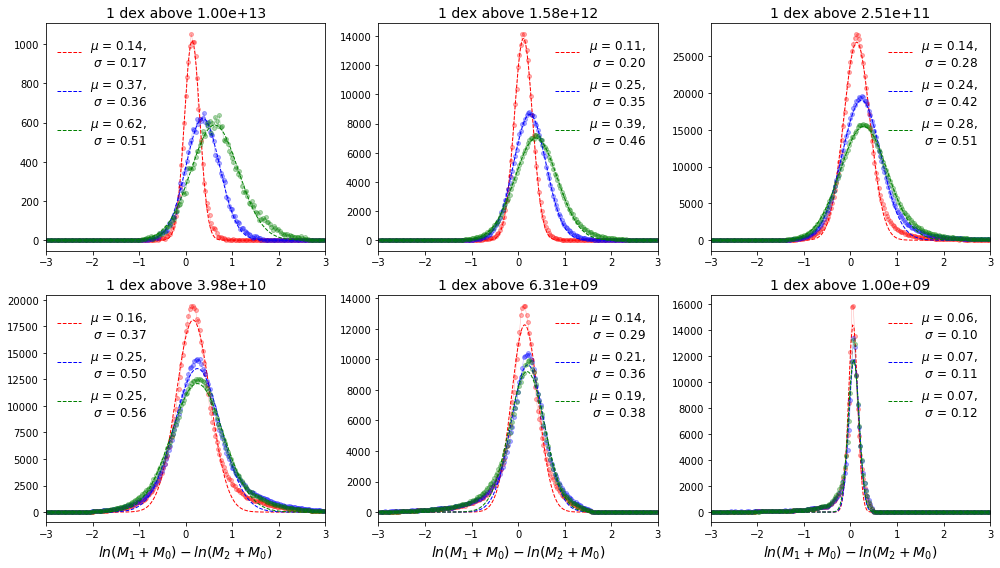

In [372]:
# mbinsm = np.linspace(9.5, 12.5, 7)[::-1]
mbinsm = np.linspace(9, 13, 6)[::-1]
print(mbinsm)
mbinsm = 10**mbinsm
M0 = 1e10
bins = np.linspace(-3, 3, 200)
func = dg.normal
fig, ax = plt.subplots(2, 3, figsize = (14, 8))
fit0 = dg.plot_noise(h000sm.value, predictsm.value, M0=M0, binfit=bins, c='r', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
fit2 = dg.plot_noise(h200sm.value, predictsm.value, M0=M0, binfit=bins, c='b', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]
fittmp = dg.plot_noise(tmpsm.value, predictsm.value, M0=M0, binfit=bins, c='g', axin=ax, func=func, mbin=mbinsm, retfit=True)[0]


/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:396: RuntimeWarning: invalid value encountered in true_divide
  if not type(color) == str:
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:397: RuntimeWarning: invalid value encountered in true_divide
  color = cstyle[color]
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:402: RuntimeWarning: invalid value encountered in true_divide
  pass
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


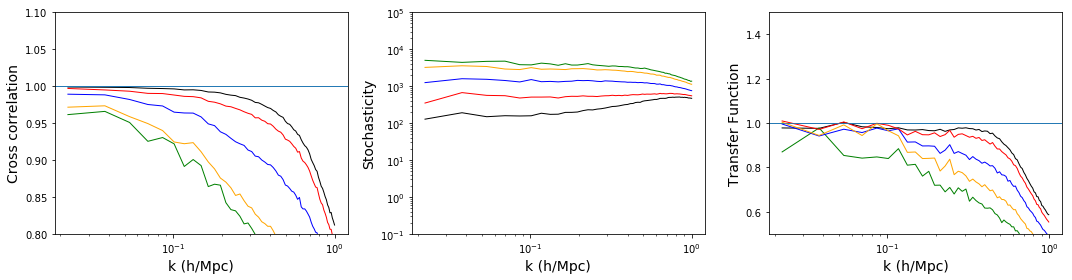

In [392]:
fig, ax = dg.plot_2pt(h000, predict)
dg.plot_2pt(tmp, predict, axin=ax, color='g')
dg.plot_2pt(h200, predict, axin=ax, color='b')
dg.plot_2pt(h100, predict, axin=ax, color='r')
dg.plot_2pt(h300, predict, axin=ax, color='orange')



In [461]:
datap5x = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_iM12-nam5xsm3off/datap', 'mapp').paint()
pred5x = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_iM12-nam5xsm3off/fitp/', 'mapp').paint()
datap = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-nasm3off/datap', 'mapp').paint()
pred = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/opt_s999_MdowniM12-nasm3off/fitp/', 'mapp').paint()


In [460]:
np.unique(datap5x[datap[...]>0]/datap[datap[...]>0])

array([ 5.01187234,  5.01187234,  5.01187234,  5.01187234,  5.01187234,
        5.01187234,  5.01187234,  5.01187234,  5.01187234])

In [467]:
datapsm = ft.smooth(datap, 3, 'fingauss')
datap5xsm = ft.smooth(datap5x, 3, 'fingauss')
predsm = ft.smooth(pred, 3, 'fingauss')
pred5xsm = ft.smooth(pred5x, 3, 'fingauss')

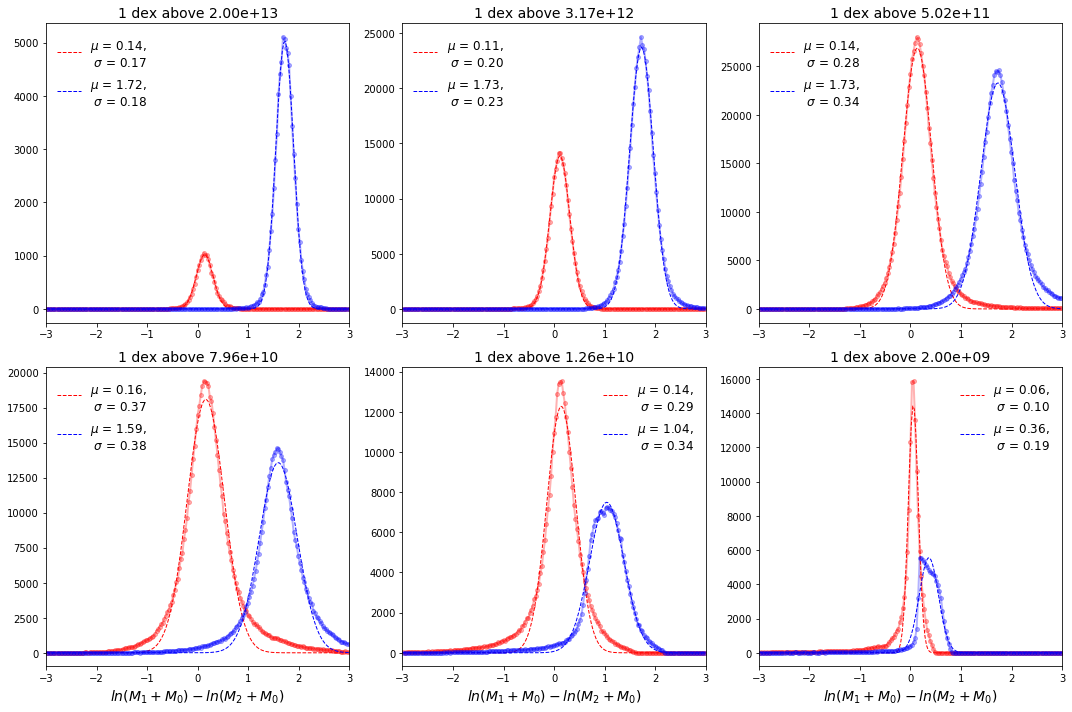

In [476]:
fig, ax = dg.plot_noise(datapsm, predsm, M0=1e10, binfit=bins, mbin=mbinsm, lw=2, c='r', func=dg.normal)
dg.plot_noise(datap5xsm, pred5xsm, axin=ax, M0=1e10, binfit=bins, mbin=2*mbinsm, lw=2, c='b', func=dg.normal, x0=[1000, 2, 0.5])

In [458]:
(tmpsm[...] > 5e12).sum()/nc**3

0.18348312377929688


# 1000 Mpc/h

In [28]:
bs = 1000
nc = 128
numd = 1e-3
num = int(bs**3 * numd)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)
pm2 = PMnew(BoxSize=bs, Nmesh=[2*nc]*3)
dpath = '/project/projectdirs/astro250/chmodi/cosmo4d/'
fofall = BigFileCatalog(dpath + 'data/z00/L1000_N1024_S0100_40step/FOF', header='Header')
# fofall = BigFileCatalog(dpath + 'data/z00/L1000_N1024_S0100_40step/FOF', header='Header')

In [29]:
hmesh = pm.paint(fofall['PeakPosition'][:num], resampler='nearest')
hmesh2 = pm2.paint(fofall['PeakPosition'][:num])

In [22]:
%matplotlib inline

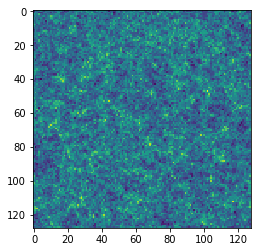

In [23]:
plt.imshow(hmesh[...].sum(axis=0))


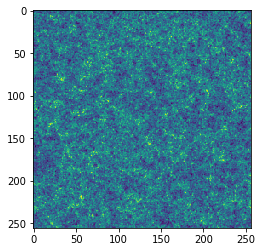

In [30]:
plt.imshow(hmesh2[...].sum(axis=0))


In [32]:
(hmesh[...] > 0).sum()/nc**3, (hmesh2[...] > 0).sum()/nc**3/8

(0.28701162338256836, 0.28673255443572998)

In [54]:
hmass = fofall['Mass'][1:num].compute()*1e10

In [55]:
hmass.size

999999

In [174]:
nmf = mass_function.Num_Mass_Func(bs, nc, M=0.3175)
lMin, lMax, dlM = 11, 16, 0.1
lMin, lMax = np.log10(hmass[-1]), np.log10(hmass[0])
dlM = (lMax - lMin)/100

mf, mcounts, mm = nmf.calc_array(hmass[:-1], lMin, lMax, dlM)

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/mymass_function.py:323: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

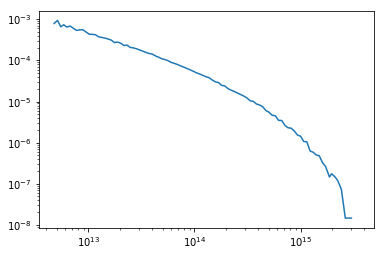

In [175]:
plt.plot(mm, mf)
plt.loglog()

[]

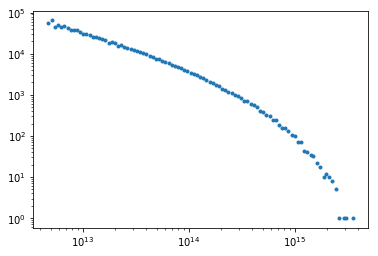

In [176]:
plt.plot(mm, mcounts, ".")
plt.loglog()

In [331]:
lMin, lMax = np.log10(hmass[-1]), np.log10(hmass[0])
dlM = (lMax - lMin)/100
# lMax += dlM
# lMin -= dlM
mf, mcounts, mm = nmf.calc_array(hmass[:-1], lMin, lMax, dlM)
mmr = 10**(np.arange(lMin, lMax, dlM))
mmr = mmr[::-1]
tots = 10000
maxsize = 100

/global/homes/c/chmodi/Programs/cosmo4d/cosmo4d/mymass_function.py:323: RuntimeWarning: Mean of empty slice.
  Mmean[foo] = (10**(lsorthalomass[int(ranks[foo]):int(ranks[foo+ 1])])).mean()
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [332]:
ranks = hmass.size - np.searchsorted(hmass[::-1], mmr)
ratios = (ranks[1:] - ranks[:-1])/ranks[-1]
ranks, ratios;


In [333]:
index, counts, mmc = [], [], []
for i, r in enumerate(ranks[:-1]):
    truesize = ranks[i+1] - r
    size = int(tots * truesize/ranks[-1])
                 
    if truesize:
        if truesize < maxsize:
            index.append(np.random.choice(np.arange(r, ranks[i+1], 1), truesize))
            counts.append(truesize)
            mmc.append(mmr[i])
        else:
            size = int(tots * truesize/ranks[-1]) + int(maxsize)
#             size = int(tots * truesize/ranks[-1])
#             if size < maxsize: size += int(maxsize)
            index.append(np.random.choice(np.arange(r, ranks[i+1], 1), size))
            counts.append(size)
            mmc.append(mmr[i])
index = np.concatenate(index)

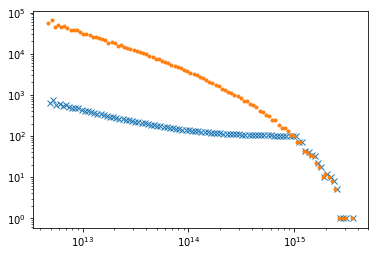

In [334]:
plt.plot(mmc, counts, 'x')
plt.plot(mm, mcounts, ".")
plt.xscale('log')
plt.yscale('log')

In [335]:
np.array(counts).sum()*7*3/1e6, np.array(counts).sum()/tots

(0.38310300000000003, 1.8243)

# Position

In [11]:
bs, nc, numd, seed = 400, 128, 1e-3, 100
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d'%(bs, nc, seed, numd*1e4)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)

import yaml
with open(scratch + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

train = '/global/cscratch1/sd/chmodi/cosmo4d/train/'

ptpath = train + cfg['%s-%s'%(bs,nc)][0][numd]['ppath']
mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpath']
ptup, pftname, plocal, pdict = ntools.setuppos2(ptpath)
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1, R2 = pdict['R1'], pdict['R2']

num = int(numd*bs**3)
meshdict, hdict = ntools.readfiles(pm, scratch + '/data/L%04d_N%04d_S%04d_05step/'%(bs, nc, seed), R1=R1, R2=R2)
hdictf = ntools.gridhalos(pm, scratch +'/data/L%04d_N%04d_S%04d_40step/'%(bs, 4*nc, seed), rank=num, R1=R1, R2=R2, pmesh=True)

datapt = pm.create(mode='real', value=0)
datapt[...] = hdictf[0]['halomesh']
# datapt = pm.paint(hdictf['position'][:int(numd*bs**3)], hdictf['mass'][:int(numd*bs**3)])


print('working on the net prediction')
ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)

mftt = ntools.createdata(pm, meshdict, mftname, mlocal)

nnpred = pm.create(mode='real', value=ntools.applynet(ftt, ptup).reshape(nc, nc, nc))
nnmass = pm.create(mode='real', value=ntools.applynet(mftt, mtup).reshape(nc, nc, nc))
##
predict = pm.create(mode ='real', value=nnpred*nnmass)

#Other mesh
hposmesh = pm.create(mode='real', value=hdictf[0]['hposmesh'])
hmesh = pm.create(mode='real', value=hdictf[0]['halomesh'])
hposmeshsm = ft.smooth(pm.create(mode='real', value=hposmesh), 3, 'fingauss')
nnpredsm = ft.smooth(pm.create(mode='real', value=nnpred), 3, 'fingauss')
hmeshsm = ft.smooth(pm.create(mode='real', value=hmesh), 3, 'fingauss')
predictsm = ft.smooth(pm.create(mode='real', value=predict), 3, 'fingauss')


hproundmesh = hposmesh.copy()
hproundmesh[hproundmesh[...] > 0.1]  = 1
hproundmeshsm = ft.smooth(pm.create(mode='real', value=hproundmesh), 3, 'fingauss')


Network architecture for position: 30, relu; 10, relu; 1, sigmoid; 
Width of sigmoid is =  3
Position features are  ['final', 'R1', 'R12']
Network architecture for position: 10, elu; 5, elu; 1, linear; 
Read Halo files
BigFileCatalog read
Match abundance
BigFileCatalog read
Match abundance
working on the net prediction


/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:408: RuntimeWarning: invalid value encountered in true_divide
  axar[0].plot(k, crossp/(halop*fieldp)**0.5, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:409: RuntimeWarning: invalid value encountered in true_divide
  axar[1].plot(k, halop - crossp**2./fieldp, label = label, ls = ls, lw = lw, alpha = alpha, color = color)
/global/homes/c/chmodi/Programs/cosmo4d/train_nets/diagnostic.py:414: RuntimeWarning: invalid value encountered in true_divide
  axar[2].plot(k, fieldp/halop, label = label, ls = ls, lw = lw, alpha = alpha, color =  color)
No handles with labels found to put in legend.


Transfer function is for power


No handles with labels found to put in legend.


Transfer function is for power


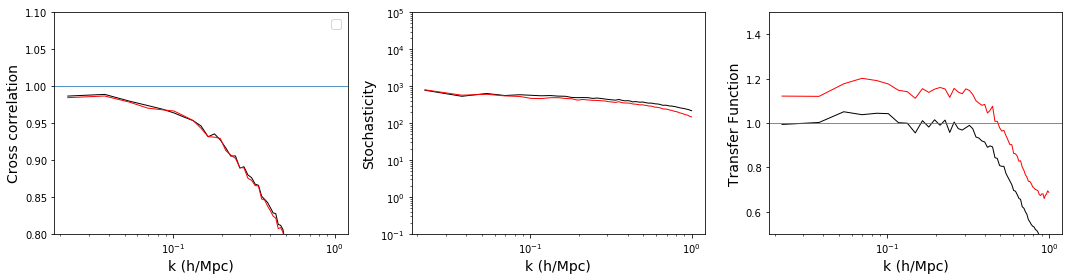

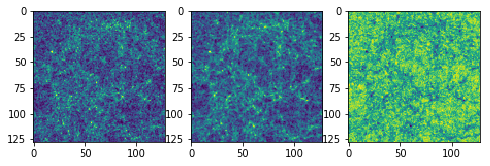

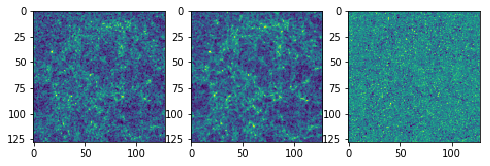

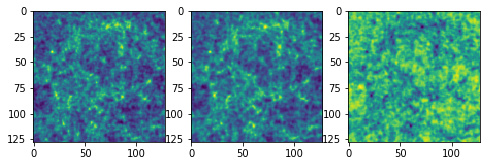

In [12]:

fig, ax = dg.plot_2pt(hposmesh, nnpred, pm=pm)
dg.plot_2pt(hproundmesh, nnpred, axin=ax, pm=pm, c='r')

fig, ax = plt.subplots(1, 3, figsize = (8, 3))
ax[0].imshow(hposmesh[...].sum(axis=0))
ax[1].imshow(nnpred[...].sum(axis=0))
ax[2].imshow((hposmesh - nnpred)[...].sum(axis=0))

fig, ax = plt.subplots(1, 3, figsize = (8, 3))
ax[0].imshow(hproundmesh[...].sum(axis=0))
ax[1].imshow(nnpred[...].sum(axis=0))
ax[2].imshow((hproundmesh - nnpred)[...].sum(axis=0))

fig, ax = plt.subplots(1, 3, figsize = (8, 3))
ax[0].imshow(hposmeshsm[...].sum(axis=0))
ax[1].imshow(nnpredsm[...].sum(axis=0))
ax[2].imshow((hposmeshsm - nnpredsm)[...].sum(axis=0))

In [13]:
mbins = np.logspace(11, 13, 9)[::-1]
scatter = dg.gridscatter(hposmeshsm, nnpredsm, mbins, hmeshsm)
scatterround = dg.gridscatter(hproundmeshsm, nnpredsm, mbins, hmeshsm)

ii = 4
pos = np.where((hmeshsm[...] > mbins[ii+1]) & (hmeshsm[...] < mbins[ii]))
print(hposmeshsm[pos].mean(), nnpredsm[pos].mean())

pos = np.where(hmeshsm[...] < 1e11)
print(nnpredsm[pos].max(), hposmeshsm[pos].max())
print(nnpred[pos].max(), hposmesh[pos].max())


0.0503343493884 0.16545163596
0.454601862866 0.0200603778153
1.0 0.00921175921134


[ 12.5  12.   11.5  11.   10.5  10.    9.5]


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


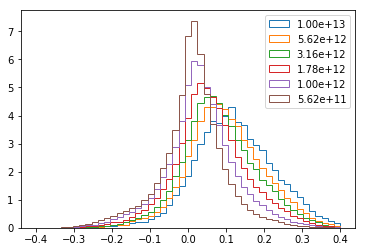

In [14]:

bins = np.linspace(-0.4, 0.4)
for i in range(6):
    plt.hist(scatterround[i][1] - scatterround[i][0], histtype='step', bins=bins, normed=True, color='C%d'%i, label='%0.2e'%mbins[i])
plt.legend()
# plt.hist(scatter[0][1] - scatter[0][0], histtype='step', bins=20, normed=True)
# plt.hist(scatter[3][1] - scatter[3][0], histtype='step', bins=20, normed=True)


dg.scatter_catalog(hdictf[1]['mass'], hdictf[1]['position'], 0.2)

mbinsm = np.linspace(9.5, 12.5, 7)[::-1]
# mbinsm = np.linspace(9, 13, 6)[::-1]
print(mbinsm)
mbinsm = 10**mbinsm

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


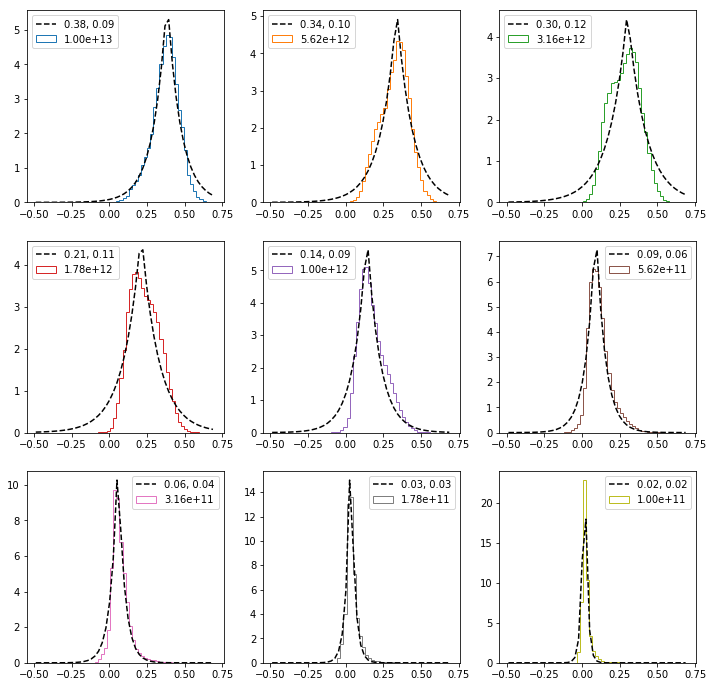

In [15]:

bins = np.linspace(-0.3, 0.7)
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
for i in range(9):
    axis = ax.flatten()[i]
    axis.hist(scatter[i][1] - scatter[i][0], histtype='step', bins=bins, normed=True, color='C%d'%i, label='%0.2e'%mbins[i])
    tmp, tmp2, tmp3 = dg.fitpdf(scatter[i][1] - scatter[i][0], dg.laplace, bins=np.linspace(-0.5, 0.7), normed=True, x0=[10, 0.2, 0.1])
    axis.plot(tmp, dg.laplace(tmp, *tmp3.x), 'k--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))
    axis.legend()
# plt.legend()
# plt.hist(scatter[0][1] - scatter[0][0], histtype='step', bins=20, normed=True)

# plt.hist(scatter[3][1] - scatter[3][0], histtype='step', bins=20, normed=True)




/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


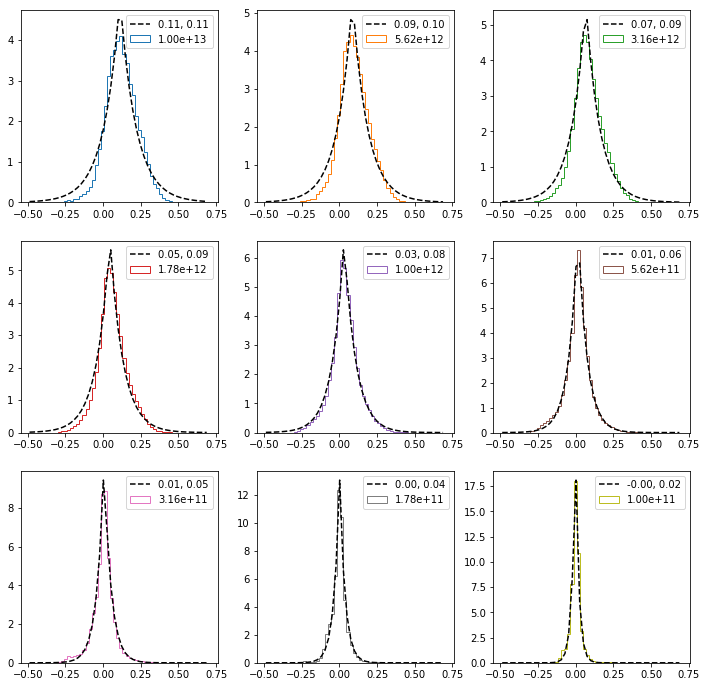

In [16]:

bins = np.linspace(-0.3, 0.7)
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
for i in range(9):
    axis = ax.flatten()[i]
    axis.hist(scatterround[i][1] - scatterround[i][0], histtype='step', bins=bins, normed=True, color='C%d'%i, label='%0.2e'%mbins[i])
    tmp, tmp2, tmp3 = dg.fitpdf(scatterround[i][1] - scatterround[i][0], dg.laplace, bins=np.linspace(-0.5, 0.7), normed=True, x0=[10, 0.2, 0.1])
    axis.plot(tmp, dg.laplace(tmp, *tmp3.x), 'k--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))
    axis.legend()
# plt.legend()
# plt.hist(scatter[0][1] - scatter[0][0], histtype='step', bins=20, normed=True)

# plt.hist(scatter[3][1] - scatter[3][0], histtype='step', bins=20, normed=True)

In [17]:
ivar3d = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/position/opt_s999_p1-mlimsm3n3d25voff/noise_M120', 'ivar3d').paint()
datam = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/position/opt_s999_p1-mlimsm3n3d25voff/datam', 'mapp').paint()
datamsm = ft.smooth(datam, 3, 'fingauss')

In [18]:
np.unique(ivar3d[...])

array([  1.00000000e-06,   4.06766872e+01,   4.52146392e+01,
         4.99905897e+01,   7.19220026e+01,   8.15242180e+01])

In [19]:
np.unique(ivar3d[datamsm[...] < 1e12])**-0.5

array([ 1000.])

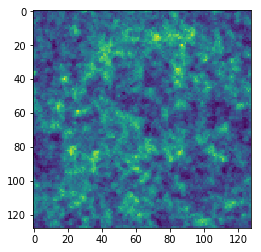

In [20]:
plt.imshow(ivar3d[...].sum(axis=0))

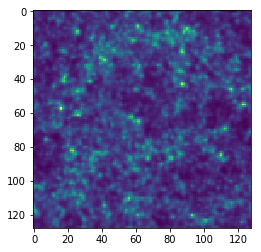

In [21]:
plt.imshow(datamsm[...].sum(axis=0))

In [22]:
nfile = np.loadtxt('/global/project/projectdirs/astro250/chmodi/cosmo4d/train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/hist_pos.txt').T

In [23]:
nfile[-1], nfile[-1]*2**0.5, np.unique(ivar3d)**-0.5

(array([ 0.08316984,  0.09595448,  0.10883156,  0.11034472,  0.09919773,
         0.07422505,  0.05638498,  0.0428752 ,  0.02930199,  0.01964475,
         0.0136133 ,  0.00937862,  0.00613252,  0.00409382,  0.00272609,
         0.00177471]),
 array([ 0.11761992,  0.13570012,  0.15391106,  0.15605099,  0.14028678,
         0.10497008,  0.0797404 ,  0.06063469,  0.04143927,  0.02778187,
         0.01925212,  0.01326338,  0.00867269,  0.00578953,  0.00385528,
         0.00250982]),
 array([  1.00000000e+03,   1.56793196e-01,   1.48716948e-01,
          1.41434666e-01,   1.17915016e-01,   1.10753301e-01]))

### Overdensity

In [24]:
%matplotlib inline

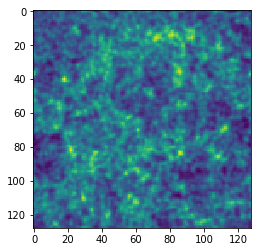

In [25]:
plt.imshow(hposmeshsm[...].sum(axis=0))

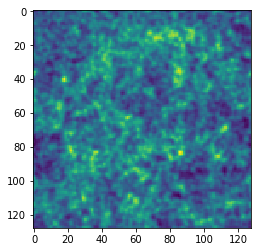

In [65]:
ovdpos = (hposmeshsm - hposmeshsm.cmean())/hposmeshsm.cmean()
ovdpospred = (nnpredsm - nnpredsm.cmean())/nnpredsm.cmean()
ovdposround = (hproundmeshsm - hproundmeshsm.cmean())/hproundmeshsm.cmean()

# ovdpos2 = ft.smooth((hposmesh - hposmeshsm.cmean())/hposmeshsm.cmean(), 3, 'fingauss')
# ovdpospred2 = ft.smooth((nnpred - nnpredsm.cmean())/nnpredsm.cmean(), 3, 'fingauss')

plt.imshow((ovdposround)[...].sum(axis=0))

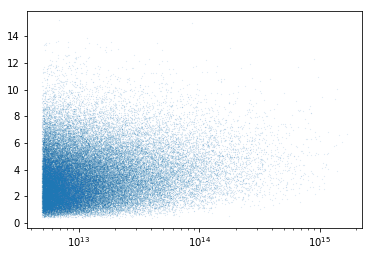

In [49]:
plt.plot(hdictf[1]['mass'], ovdpos.readout(hdictf[1]['position']), '.', ms=0.1)
plt.xscale('log')


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.00e+13 1.77 4.55 2.38
6.31e+12 1.52 3.90 2.17
3.98e+12 1.37 3.33 1.96
2.51e+12 1.20 2.68 1.69
1.58e+12 1.01 1.97 1.38
1.00e+12 0.84 1.31 1.08
6.31e+11 0.67 0.72 0.80
3.98e+11 0.56 0.23 0.58
2.51e+11 0.39 -0.15 0.39
1.58e+11 0.27 -0.44 0.26
1.00e+11 0.19 -0.63 0.17
6.31e+10 0.13 -0.76 0.11
3.98e+10 0.09 -0.85 0.07
2.51e+10 0.06 -0.90 0.04
1.58e+10 0.04 -0.94 0.03
1.00e+10 0.03 -0.96 0.02


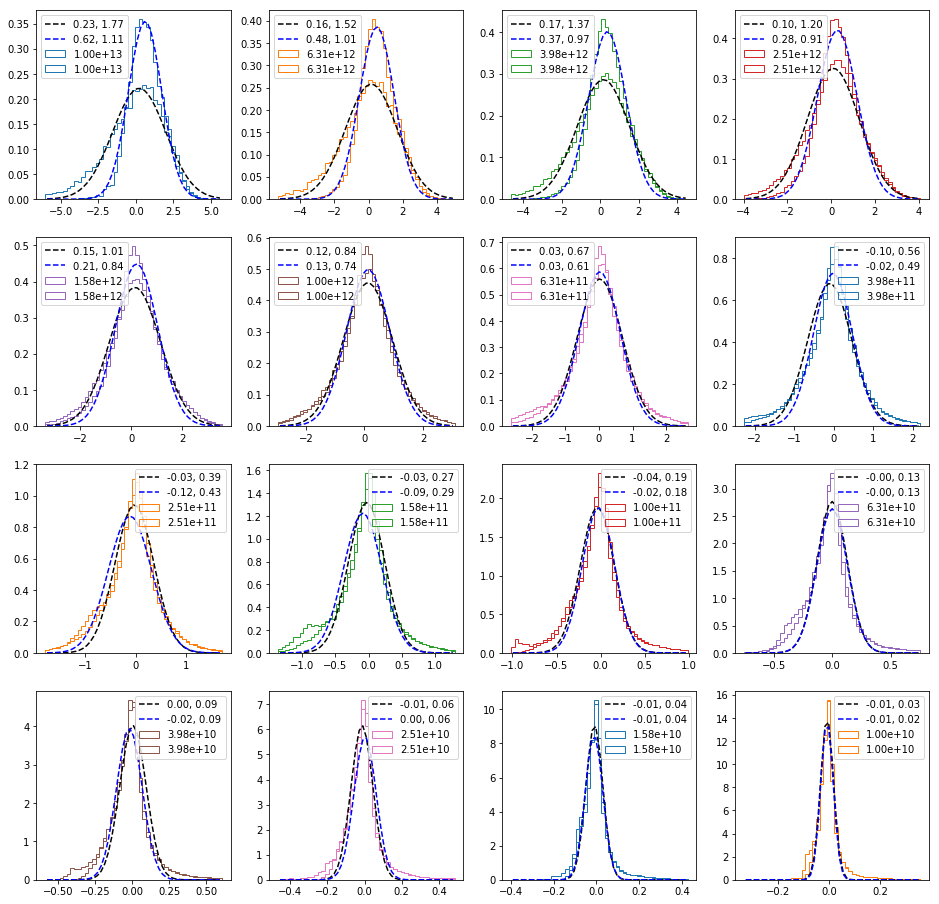

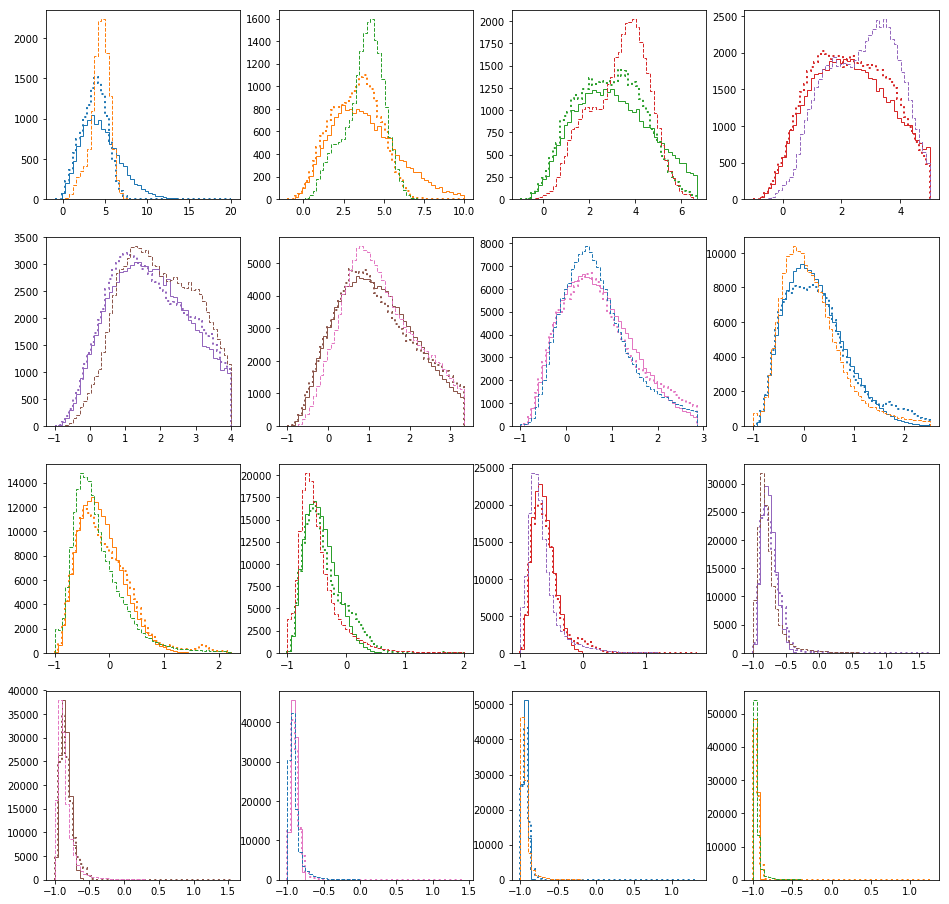

In [76]:
M0 = 0

mbins = np.logspace(10, 13, 16)[::-1]
scatter = dg.gridscatter(ovdpos, ovdpospred, mbins, hmeshsm)
scatter2 = dg.gridscatter(ovdposround, ovdpospred2, mbins, hmeshsm)


bins = np.linspace(-10, 10)
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
fig2, ax2 = plt.subplots(4, 4, figsize = (16, 16))
for i in range(16):
    mean, std = (scatter[i][1] - scatter[i][0]).mean(), (scatter[i][1] - scatter[i][0]).std()
    bins = np.linspace(mean - 3*std, mean + 3*std)
#   print(mean, std)
    axis = ax.flatten()[i]
    
    axis.hist(scatter[i][1] - scatter[i][0], histtype='step', bins=bins, normed=True, color='C%d'%(i%7), label='%0.2e'%mbins[i])
    axis.hist(scatter2[i][1] - scatter2[i][0], histtype='step', bins=bins, normed=True, color='C%d'%(i%7), label='%0.2e'%mbins[i], )
    
    tmp, tmp2, tmp3 = dg.fitpdf(scatter[i][1] - scatter[i][0], dg.normal, bins=bins, normed=True, x0=[scatter[i][0].size, mean, std])
    axis.plot(tmp, dg.normal(tmp, *tmp3.x), 'k--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))
    print('%0.2e'%mbins[i], '%0.2f'%tmp3.x[-1], '%0.2f'%(scatter[i][0].mean()), '%0.2f'%(scatter[i][0].std()))

    tmp, tmp2, tmp3 = dg.fitpdf(scatter2[i][1] - scatter2[i][0], dg.normal, bins=bins, normed=True, x0=[scatter[i][0].size, mean, std])
    axis.plot(tmp, dg.normal(tmp, *tmp3.x), 'b--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))

    ax2.flatten()[i].hist(scatter[i][0], histtype='step', bins=np.linspace(-1, 20/(i+1)), normed=False, color='C%d'%(i%7), label='%0.2e'%mbins[i])
    ax2.flatten()[i].hist(scatter2[i][0], histtype='step', bins=np.linspace(-1, 20/(i+1)), normed=False, color='C%d'%(i%7), label='%0.2e'%mbins[i], ls=":", lw=2)
    ax2.flatten()[i].hist(scatter[i][1], histtype='step', bins=np.linspace(-1, 20/(i+1)), normed=False, color='C%d'%((i+1)%7), label='%0.2e'%mbins[i], ls="--")

    axis.legend()
# plt.legend()
# plt.hist(scatter[0][1] - scatter[0][0], histtype='step', bins=20, normed=True)

# plt.hist(scatter[3][1] - scatter[3][0], histtype='step', bins=20, normed=True)


# Fourier Noise

In [18]:
bs, nc, numd, seed = 400, 128, 1e-3, 100
bpath = '/global/cscratch1/sd/chmodi/cosmo4d/output/L%04d_N%04d_05step-fof/lhd_S%04d/n%02d'%(bs, nc, seed, numd*1e4)
pm = PMnew(BoxSize=bs, Nmesh=[nc]*3)

import yaml
with open(scratch + 'train/models.yaml', 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

train = '/global/cscratch1/sd/chmodi/cosmo4d/train/'

ptpath = train + cfg['%s-%s'%(bs,nc)][0][numd]['ppath']
mtpath = ptpath + cfg['%s-%s'%(bs,nc)][0][numd]['mpath']
ptup, pftname, plocal, pdict = ntools.setuppos2(ptpath)
mtup, mftname, mlocal, mdict = ntools.setupmass(mtpath )
R1, R2 = pdict['R1'], pdict['R2']

num = int(numd*bs**3)
meshdict, hdict = ntools.readfiles(pm, scratch + '/data/L%04d_N%04d_S%04d_05step/'%(bs, nc, seed), R1=R1, R2=R2)
hdictf = ntools.gridhalos(pm, scratch +'/data/L%04d_N%04d_S%04d_40step/'%(bs, 4*nc, seed), rank=num, R1=R1, R2=R2, pmesh=True)

datapt = pm.create(mode='real', value=0)
datapt[...] = hdictf[0]['halomesh']
hposmesh = hdictf[0]['hposmesh']
hmesh = hdictf[0]['halomesh']
hposmeshsm = ft.smooth(pm.create(mode='real', value=hposmesh), 3, 'fingauss')
hmeshsm = ft.smooth(pm.create(mode='real', value=hmesh), 3, 'fingauss')
# datapt = pm.paint(hdictf['position'][:int(numd*bs**3)], hdictf['mass'][:int(numd*bs**3)])


print('working on the net prediction')
ftt = ntools.createdata(pm, meshdict, pdict['pftname'], plocal)

mftt = ntools.createdata(pm, meshdict, mftname, mlocal)

nnpred = ntools.applynet(ftt, ptup).reshape(nc, nc, nc)
nnmass = ntools.applynet(mftt, mtup).reshape(nc, nc, nc)
##
predict = pm.create(mode ='real')
predict[...] = nnpred*nnmass
nnpredsm = ft.smooth(pm.create(mode='real', value=nnpred), 3, 'fingauss')
predictsm = ft.smooth(pm.create(mode='real', value=predict), 3, 'fingauss')


# hproundmesh = hposmesh.copy()
# hproundmesh[hproundmesh > 0.1]  = 1
# hproundmeshsm = ft.smooth(pm.create(mode='real', value=hproundmesh), 3, 'fingauss')


Network architecture for position: 30, relu; 10, relu; 1, sigmoid; 
Width of sigmoid is =  3
Position features are  ['final', 'R1', 'R12']
Network architecture for position: 10, elu; 5, elu; 1, linear; 
Read Halo files
BigFileCatalog read
Match abundance
BigFileCatalog read
Match abundance
working on the net prediction


In [19]:
M0 = 1e12

# res = pm.create(mode='real', value=hmesh - predict)
# ressm = pm.create(mode='real', value=hmeshsm - predictsm)
res = pm.create(mode='real', value=hmesh/(hmesh.mean()+M0) - predict/(predict.cmean()+M0))
ressm = pm.create(mode='real', value=hmeshsm/hmeshsm.cmean() - predictsm/predictsm.cmean())

ressmlog = pm.create(mode='real', value=np.log(hmeshsm[...] +  M0) - np.log(predictsm[...] +  M0))

In [20]:
from matplotlib.colors import SymLogNorm

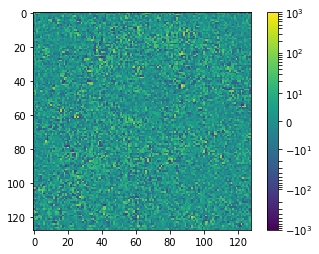

In [21]:
# im = plt.imshow(res[...].sum(axis=0), norm=SymLogNorm(1e10, vmin=-1e13, vmax=1e13))
im = plt.imshow(res[...].sum(axis=0),  norm=SymLogNorm(10, vmin=-1e3, vmax=1e3))
plt.colorbar(im)

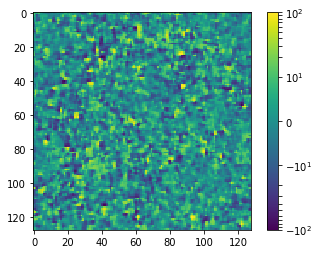

In [22]:
# im = plt.imshow(ressm[...].sum(axis=0), norm=SymLogNorm(1e10, vmin=-1e13, vmax=1e13))
im = plt.imshow(ressm[...].sum(axis=0), norm=SymLogNorm(1e1, vmin=-1e2, vmax=1e2))
plt.colorbar(im)

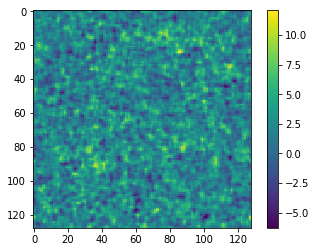

In [23]:
im = plt.imshow(ressmlog[...].sum(axis=0))#, norm=SymLogNorm(1e10, vmin=-1e13, vmax=1e13))
plt.colorbar(im)

In [24]:
pkreslog = FFTPower(ressmlog, mode='1d').power
kk = pkreslog['k']

pkreslog = FFTPower(ressmlog/ressmlog.cmean(), mode='1d').power['power']
# pkres = FFTPower(res/res.cmean(), mode='1d').power['power']
# pkressm = FFTPower(ressm/ressm.cmean(), mode='1d').power['power']
pkres = FFTPower(res, mode='1d').power['power']
pkressm = FFTPower(ressm, mode='1d').power['power']

pkhh = FFTPower(pm.create(mode='real', value=hmesh)/hmesh.mean(), mode='1d').power['power']
pkpred = FFTPower(pm.create(mode='real', value=predict)/predict.cmean(), mode='1d').power['power']
pkcross = FFTPower(pm.create(mode='real', value=hmesh)/hmesh.mean(), 
                   second=pm.create(mode='real', value=predict)/predict.cmean(), mode='1d').power['power']

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


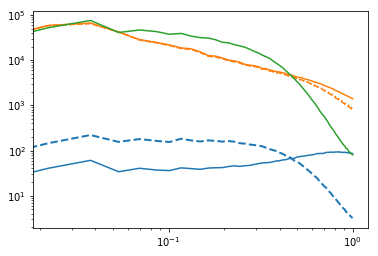

In [25]:
plt.plot(kk, pkres, 'C0')
plt.plot(kk, pkressm, 'C0--', lw=2)
plt.plot(kk, pkhh, 'C1')
plt.plot(kk, pkpred, 'C1--')
plt.plot(kk, pkcross, 'C1:')

plt.plot(kk, pkreslog, 'C2')
plt.xscale('log')
plt.yscale('log')


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


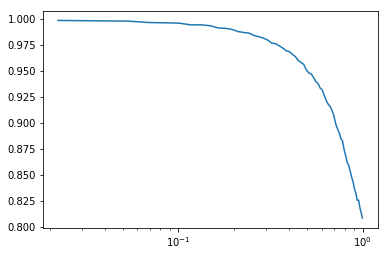

In [28]:
plt.plot(kk, pkcross/np.sqrt(pkhh*pkpred))
plt.xscale('log')

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


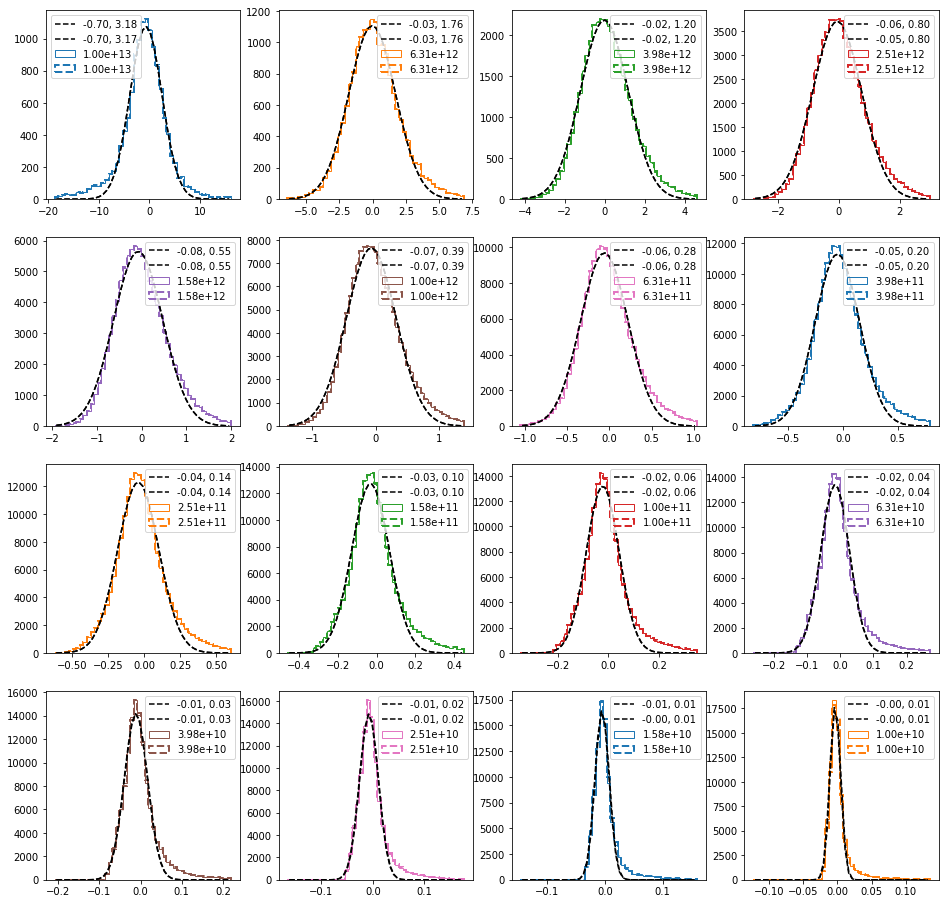

In [42]:
M0 = 1e10

mbins = np.logspace(10, 13, 16)[::-1]
scatter = dg.gridscatter(hmeshsm/(M0+hmeshsm.cmean()), predictsm/(M0+predictsm.cmean()), mbins, hmeshsm)
scatter2 = dg.gridscatter((M0+hmeshsm)/(M0+hmeshsm.cmean()), (M0+predictsm)/(M0+predictsm.cmean()), mbins, hmeshsm)


bins = np.linspace(-10, 10)
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
for i in range(16):
    mean, std = (scatter[i][1] - scatter[i][0]).mean(), (scatter[i][1] - scatter[i][0]).std()
    bins = np.linspace(mean - 3*std, mean + 3*std)
#     bins = np.linspace(-10/(i+1), 10/(i+1))
    axis = ax.flatten()[i]
    axis.hist(scatter[i][1] - scatter[i][0], histtype='step', bins=bins, normed=False, color='C%d'%(i%7), label='%0.2e'%mbins[i])
    tmp, tmp2, tmp3 = dg.fitpdf(scatter[i][1] - scatter[i][0], dg.normal, bins=bins, normed=False, x0=[scatter[i][0].size, 0.2, 1])
    axis.plot(tmp, dg.normal(tmp, *tmp3.x), 'k--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))

    axis.hist(scatter2[i][1] - scatter2[i][0], histtype='step', bins=bins, normed=False, color='C%d'%(i%7), label='%0.2e'%mbins[i], ls="--", lw=2)
    tmp, tmp2, tmp3 = dg.fitpdf(scatter2[i][1] - scatter2[i][0], dg.normal, bins=bins, normed=False, x0=[scatter2[i][0].size, 0.2, 1])
    axis.plot(tmp, dg.normal(tmp, *tmp3.x), 'k--', label='%0.2f, %0.2f'%(tmp3.x[1], tmp3.x[2]))
    axis.legend()
# plt.legend()
# plt.hist(scatter[0][1] - scatter[0][0], histtype='step', bins=20, normed=True)

# plt.hist(scatter[3][1] - scatter[3][0], histtype='step', bins=20, normed=True)




In [ ]:
plt.imshow(hmesh[...].sum(axis=0))

In [ ]:
plt.imshow((hmesh/hmesh.mean())[...].sum(axis=0))

In [ ]:
((predictsm - predictsm.cmean())/predictsm.cmean())[...].min()

In [ ]:
try: 'yerew'%(5)
except TypeError: print('%dyerew'%(5))


In [ ]:
predictsm[...].min()

In [ ]:
1/pm.Nmesh.prod()

In [ ]:

itermesh = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/overdensity/opt_s999_p1-nowsm3n3d20voff/M0_120/128-03-4.00/0020/fit_p', 'mapp').paint()
itermesh2 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/overdensity/opt_s999_p1-M0sm3n3d20voff/M0_120/128-01-4.00/0010/fit_p', 'mapp').paint()

In [ ]:
tmpf = np.loadtxt('/project/projectdirs/astro250/chmodi/cosmo4d/train/L0400_N0128_05step-n10/width_3/Wts_30_10_1/r1rf1/hlim-13_nreg-43_batch-5/eluWts-10_5_1/blim-20_nreg-23_batch-100/hist_ovd_M120_na.txt').T
ivar3d = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/overdensity/opt_s999_p1-nowsm3n3d20voff/noise_M120/', 'ivar3d').paint()
ivar3d2 = BigFileMesh('/global/cscratch1/sd/chmodi/cosmo4d/output/L0400_N0128_05step-fof/lhd_S0100/n10/overdensity/opt_s999_p1-M0sm3n3d20voff/noise_M120/', 'ivar3d').paint()

In [ ]:
np.unique(ivar3d2[...]**-0.5)/np.sqrt(2)

In [ ]:
tmpf[-1][::-1]

In [ ]:
0.2**0.5

In [ ]:
itermesh[...].sum()/1e12, datamsm[...].sum()/1e12

In [ ]:
itermesh2[...].sum()/1e12, datamsm[...].sum()/1e12

In [ ]:
itermesh[...].mean()/1e10, datamsm[...].mean()/1e10

In [ ]:
itermesh2[...].mean()/1e10, datamsm[...].mean()/1e10